## CAPTUM

========================================================================
## Importance Analysis  without CF (context features)
========================================================================

In [1]:
import h5py
import wandb
import os
import numpy as np
import torch
import sys
import pandas as pd
from torch.utils.data import DataLoader, Subset

# Pfade zur Modell- und Datendefinition
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))
#from models.morning_stars_v1.beta.v1_mha_1024_res_flatten import TCR_Epitope_Transformer, LazyTCR_Epitope_Dataset
from models.morning_stars_v1.beta.v6_1024_all_features_pe_sameAtten import TCR_Epitope_Transformer_AllFeatures, LazyFullFeatureDataset #, BidirectionalCrossAttention
# from models.morning_stars_v1.beta.v6_1024_all_features_pe_doubleCross import TCR_Epitope_Transformer_AllFeatures, LazyFullFeatureDataset #, BidirectionalCrossAttention

# File paths
test_path = '../../../../../data/splitted_datasets/allele/beta/test.tsv'
train_path = '../../../../../data/splitted_datasets/allele/beta/train.tsv'
valid_path = '../../../../../data/splitted_datasets/allele/beta/validation.tsv'

test_data = pd.read_csv(test_path, sep='\t')
train_data = pd.read_csv(train_path, sep="\t")
# valid_data = pd.read_csv(valid_path, sep="\t")


# physchem mapping laden
# physchem_map = pd.read_csv("../../../../data/physico/descriptor_encoded_physchem_mapping.tsv", sep="\t")
physchem_map = pd.read_csv("../../../../../data/physico/descriptor_encoded_physchem_mapping.tsv", sep="\t")

# Merge mit physchem_index
test_data = pd.merge(test_data, physchem_map, on=["TRB_CDR3", "Epitope"], how="left")

# ========== Load vocab from training ==========
trbv_dict = {v: i for i, v in enumerate(train_data["TRBV"].unique())}
trbj_dict = {v: i for i, v in enumerate(train_data["TRBJ"].unique())}
mhc_dict  = {v: i for i, v in enumerate(train_data["MHC"].unique())}
UNKNOWN_TRBV_IDX = len(trbv_dict)
UNKNOWN_TRBJ_IDX = len(trbj_dict)
UNKNOWN_MHC_IDX  = len(mhc_dict)

# Apply mapping to test data
test_data["TRBV_Index"] = test_data["TRBV"].map(trbv_dict).fillna(UNKNOWN_TRBV_IDX).astype(int)
test_data["TRBJ_Index"] = test_data["TRBJ"].map(trbj_dict).fillna(UNKNOWN_TRBJ_IDX).astype(int)
test_data["MHC_Index"]  = test_data["MHC"].map(mhc_dict).fillna(UNKNOWN_MHC_IDX).astype(int)

# Vokabulargrößen bestimmen
trbv_vocab_size = UNKNOWN_TRBV_IDX + 1
trbj_vocab_size = UNKNOWN_TRBJ_IDX + 1
mhc_vocab_size  = UNKNOWN_MHC_IDX + 1

print(trbv_vocab_size)
print(trbj_vocab_size)
print(mhc_vocab_size)

# Sicherstellen, dass die 'task'-Spalte aus der Datei kommt
assert "task" in test_data.columns, "'task'-Spalte fehlt im test.tsv"
print("\n TPP-Verteilung im Testset (aus Datei):")
print(test_data["task"].value_counts())

def load_h5_lazy(file_path):
    return h5py.File(file_path, 'r')

tcr_test = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_test_tcr_embeddings_final.h5"
epitope_test = "../../../../../data/embeddings/beta/allele/dimension_1024/padded_test_epitope_embeddings_final.h5"
  

print('Lade Embeddings...')
tcr_test_embeddings = load_h5_lazy(tcr_test)
epitope_test_embeddings = load_h5_lazy(epitope_test)

physchem_path = "../../../../../data/physico/descriptor_encoded_physchem.h5"

with h5py.File(physchem_path, 'r') as f:
    inferred_physchem_dim = f["tcr_encoded"].shape[1]

physchem_file = h5py.File(physchem_path, 'r')

# Dataset & Dataloader
test_dataset = LazyFullFeatureDataset(test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
                                  trbv_dict, trbj_dict, mhc_dict)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Modell aufsetzen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCR_Epitope_Transformer_AllFeatures(
    embed_dim=128,
    num_heads=4,
    num_layers=1,
    max_tcr_length=43,
    max_epitope_length=43,
    dropout=0.3,
    physchem_dim=inferred_physchem_dim,
    trbv_vocab_size=trbv_vocab_size,
    trbj_vocab_size=trbj_vocab_size,
    mhc_vocab_size=mhc_vocab_size
    # use_checkpointing=False  # Set to False if memory isn't an issue 
).to(device)

# Modell von wandb laden
print("Lade Modell von wandb...")
api = wandb.Api()
runs = api.runs("ba_cancerimmunotherapy/dataset-allele")

epoch_model = 3

# Direktes Laden über bekannten Namen
# ba_cancerimmunotherapy/dataset-allele/Run_v6_doubleCross_oversample_epoch_1:v1
# ba_cancerimmunotherapy/dataset-allele/Run_v6_sameAtt_oversample_normDrop_epoch_1:v0
# ba_cancerimmunotherapy/dataset-allele/Run_v6_sameAtt_fullyRot_wMacrof1h_epoch_1:v0
artifact_name = f"ba_cancerimmunotherapy/dataset-allele/Run_v6_sameAtt_fullyRot_wMacrof1h_epoch_{epoch_model}:v0" #anpassen, wenn andere version 
artifact = wandb.Api().artifact(artifact_name, type="model")
artifact_dir = artifact.download()
model_file = os.path.join(artifact_dir, os.listdir(artifact_dir)[0])

# Load model directly
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print("✅ Modell geladen:", artifact.name)

/tmp/ipykernel_60124/2002116260.py:22: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(train_path, sep="\t")


165
30
59

 TPP-Verteilung im Testset (aus Datei):
task
TPP2    29816
TPP1    18164
TPP3     5407
TPP4      817
Name: count, dtype: int64
Lade Embeddings...
Lade Modell von wandb...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


✅ Modell geladen: Run_v6_sameAtt_fullyRot_wMacrof1h_epoch_3:v0


/tmp/ipykernel_60124/2002116260.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=device))


In [6]:
# Step-by-step TCR Feature Importance Analysis
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

# STEP 1: Test basic model functionality
def test_model_with_single_sample(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file):
    """
    Test if we can run the model on a single sample
    """
    print("=== STEP 1: Testing Model with Single Sample ===")
    
    # Get first sample from test data
    sample_row = test_data.iloc[0]
    print(f"Sample TCR: {sample_row['TRB_CDR3']}")
    print(f"Sample Epitope: {sample_row['Epitope']}")
    print(f"True Label: {sample_row['Binding']}")
    
    # Extract data
    tcr_id = sample_row["TRB_CDR3"]
    epitope_id = sample_row["Epitope"]
    phys_idx = sample_row["physchem_index"]
    
    # Get embeddings and features
    tcr_embedding = tcr_embeddings[tcr_id][:]  # Shape should be (43, 1024)
    epitope_embedding = epitope_embeddings[epitope_id][:]  # Shape should be (43, 1024)
    tcr_physchem = physchem_file["tcr_encoded"][phys_idx]  # Shape should be (102,)
    epi_physchem = physchem_file["epi_encoded"][phys_idx]  # Shape should be (102,)
    
    print(f"TCR embedding shape: {tcr_embedding.shape}")
    print(f"Epitope embedding shape: {epitope_embedding.shape}")
    print(f"TCR physchem shape: {tcr_physchem.shape}")
    print(f"Epi physchem shape: {epi_physchem.shape}")
    
    # Get categorical indices
    trbv_index = sample_row["TRBV_Index"]
    trbj_index = sample_row["TRBJ_Index"]
    mhc_index = sample_row["MHC_Index"]
    
    print(f"TRBV index: {trbv_index}")
    print(f"TRBJ index: {trbj_index}")
    print(f"MHC index: {mhc_index}")
    
    # Convert to tensors and add batch dimension
    tcr_tensor = torch.tensor(tcr_embedding, dtype=torch.float32).unsqueeze(0)  # (1, 43, 1024)
    epitope_tensor = torch.tensor(epitope_embedding, dtype=torch.float32).unsqueeze(0)  # (1, 43, 1024)
    tcr_phys_tensor = torch.tensor(tcr_physchem, dtype=torch.float32).unsqueeze(0)  # (1, 102)
    epi_phys_tensor = torch.tensor(epi_physchem, dtype=torch.float32).unsqueeze(0)  # (1, 102)
    trbv_tensor = torch.tensor([trbv_index], dtype=torch.long)  # (1,)
    trbj_tensor = torch.tensor([trbj_index], dtype=torch.long)  # (1,)
    mhc_tensor = torch.tensor([mhc_index], dtype=torch.long)  # (1,)
    
    # Move to device
    device = next(model.parameters()).device
    tcr_tensor = tcr_tensor.to(device)
    epitope_tensor = epitope_tensor.to(device)
    tcr_phys_tensor = tcr_phys_tensor.to(device)
    epi_phys_tensor = epi_phys_tensor.to(device)
    trbv_tensor = trbv_tensor.to(device)
    trbj_tensor = trbj_tensor.to(device)
    mhc_tensor = mhc_tensor.to(device)
    
    print(f"All tensors moved to device: {device}")
    
    # Test model forward pass
    model.eval()
    with torch.no_grad():
        try:
            output = model(tcr_tensor, epitope_tensor, tcr_phys_tensor, epi_phys_tensor, 
                          trbv_tensor, trbj_tensor, mhc_tensor)
            prediction = torch.sigmoid(output).item()
            print(f"✅ Model forward pass successful!")
            print(f"Raw output: {output.item():.4f}")
            print(f"Prediction probability: {prediction:.4f}")
            return True, {
                'tcr': tcr_tensor,
                'epitope': epitope_tensor, 
                'tcr_physchem': tcr_phys_tensor,
                'epi_physchem': epi_phys_tensor,
                'trbv': trbv_tensor,
                'trbj': trbj_tensor,
                'mhc': mhc_tensor
            }
        except Exception as e:
            print(f"❌ Model forward pass failed: {str(e)}")
            return False, None

# STEP 2: Test simple Captum integration
def test_simple_captum(model, sample_tensors):
    """
    Test basic Captum integration with the simplest possible setup
    """
    print("\n=== STEP 2: Testing Simple Captum Integration ===")
    
    try:
        # Create a model wrapper that takes individual inputs (how Captum expects it)
        def model_wrapper(tcr, epitope, tcr_phys, epi_phys, trbv, trbj, mhc):
            # Handle categorical features that might become floats during interpolation
            if trbv.dtype in [torch.float32, torch.float64]:
                trbv = torch.round(trbv).long()
                trbv = torch.clamp(trbv, 0, model.trbv_embed.num_embeddings - 1)
            if trbj.dtype in [torch.float32, torch.float64]:
                trbj = torch.round(trbj).long()
                trbj = torch.clamp(trbj, 0, model.trbj_embed.num_embeddings - 1)
            if mhc.dtype in [torch.float32, torch.float64]:
                mhc = torch.round(mhc).long()
                mhc = torch.clamp(mhc, 0, model.mhc_embed.num_embeddings - 1)
            
            return model(tcr, epitope, tcr_phys, epi_phys, trbv, trbj, mhc)
        
        # Prepare inputs as individual tensors
        inputs = (
            sample_tensors['tcr'],
            sample_tensors['epitope'],
            sample_tensors['tcr_physchem'], 
            sample_tensors['epi_physchem'],
            sample_tensors['trbv'],
            sample_tensors['trbj'],
            sample_tensors['mhc']
        )
        
        # Test the wrapper
        with torch.no_grad():
            output = model_wrapper(*inputs)  # Unpack the inputs
            print(f"Model wrapper output: {output.item():.4f}")
        
        # Create Integrated Gradients
        ig = IntegratedGradients(model_wrapper)
        
        # Create simple baselines (all zeros for continuous, valid indices for categorical)
        baselines = (
            torch.zeros_like(sample_tensors['tcr']),  # TCR baseline
            torch.zeros_like(sample_tensors['epitope']),  # Epitope baseline  
            torch.zeros_like(sample_tensors['tcr_physchem']),  # TCR physchem baseline
            torch.zeros_like(sample_tensors['epi_physchem']),  # Epi physchem baseline
            torch.zeros_like(sample_tensors['trbv']),  # TRBV baseline - use 0 (valid index)
            torch.zeros_like(sample_tensors['trbj']),  # TRBJ baseline - use 0 (valid index)
            torch.zeros_like(sample_tensors['mhc'])   # MHC baseline - use 0 (valid index)
        )
        
        print("Created baselines successfully")
        print(f"TRBV baseline value: {baselines[4].item()}")
        print(f"TRBJ baseline value: {baselines[5].item()}")
        print(f"MHC baseline value: {baselines[6].item()}")
        
        # Test baseline prediction
        with torch.no_grad():
            try:
                baseline_output = model_wrapper(*baselines)  # Unpack the baselines
                print(f"Baseline prediction: {baseline_output.item():.4f}")
            except Exception as e:
                print(f"⚠️  Baseline test failed: {str(e)}. Proceeding anyway...")
        
        print("✅ Simple Captum setup successful!")
        return True, ig, inputs, baselines
        
    except Exception as e:
        print(f"❌ Simple Captum setup failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return False, None, None, None

# STEP 3: Test attribution computation
def test_attribution_computation(ig, inputs, baselines):
    """
    Test if we can compute attributions
    """
    print("\n=== STEP 3: Testing Attribution Computation ===")
    
    try:
        # Make sure all inputs require gradients
        inputs_with_grad = []
        baselines_with_grad = []
        
        for inp, baseline in zip(inputs, baselines):
            # Only set requires_grad for float tensors (not categorical)
            if inp.dtype in [torch.float32, torch.float64]:
                inp_grad = inp.clone().detach().requires_grad_(True)
                baseline_grad = baseline.clone().detach().requires_grad_(True)
            else:
                # For categorical tensors, convert to float temporarily to enable gradients
                inp_grad = inp.clone().detach().float().requires_grad_(True)
                baseline_grad = baseline.clone().detach().float().requires_grad_(True)
            
            inputs_with_grad.append(inp_grad)
            baselines_with_grad.append(baseline_grad)
        
        # Update the inputs and baselines
        inputs = tuple(inputs_with_grad)
        baselines = tuple(baselines_with_grad)
        
        # Compute attributions with minimal steps first and allow_unused=True
        print("Computing attributions with 5 steps...")
        
        # Test with just continuous features first to isolate the issue
        print("Testing with only continuous features...")
        continuous_inputs = inputs[:4]  # TCR, Epitope, TCR_physchem, Epi_physchem
        continuous_baselines = baselines[:4]
        
        # Create a wrapper for continuous features only
        def continuous_model_wrapper(tcr, epitope, tcr_phys, epi_phys):
            # Use fixed values for categorical features during testing
            device = tcr.device
            batch_size = tcr.shape[0]
            
            # Use the original sample values for categorical features
            trbv = torch.tensor([4], device=device).expand(batch_size)  # Original TRBV value
            trbj = torch.tensor([6], device=device).expand(batch_size)  # Original TRBJ value  
            mhc = torch.tensor([0], device=device).expand(batch_size)   # Original MHC value
            
            return ig.forward_func(tcr, epitope, tcr_phys, epi_phys, trbv, trbj, mhc)
        
        # Create IG for continuous features
        continuous_ig = IntegratedGradients(continuous_model_wrapper)
        
        try:
            continuous_attributions = continuous_ig.attribute(
                continuous_inputs, 
                baselines=continuous_baselines, 
                n_steps=5
            )
            
            print("✅ Continuous features attribution successful!")
            print(f"Number of continuous attribution tensors: {len(continuous_attributions)}")
            
            # Print shapes for continuous features
            continuous_names = ['TCR', 'Epitope', 'TCR_physchem', 'Epi_physchem']
            for i, (name, attr) in enumerate(zip(continuous_names, continuous_attributions)):
                print(f"{name} attribution shape: {attr.shape}")
                attr_sum = torch.abs(attr).sum().item()
                print(f"{name} total absolute attribution: {attr_sum:.6f}")
            
            # For now, create dummy attributions for categorical features
            categorical_attributions = [
                torch.zeros_like(inputs[4]),  # TRBV
                torch.zeros_like(inputs[5]),  # TRBJ  
                torch.zeros_like(inputs[6])   # MHC
            ]
            
            # Combine all attributions
            all_attributions = list(continuous_attributions) + categorical_attributions
            
            return True, all_attributions
            
        except Exception as e:
            print(f"Continuous features attribution failed: {str(e)}")
            raise e
        
    except Exception as e:
        print(f"❌ Attribution computation failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return False, None

# STEP 4: Create simple visualization
def create_simple_visualization(attributions):
    """
    Create a simple bar plot of feature importance
    """
    print("\n=== STEP 4: Creating Simple Visualization ===")
    
    try:
        # Calculate total attribution for each feature type
        feature_names = ['TCR', 'Epitope', 'TCR_physchem', 'Epi_physchem', 'TRBV', 'TRBJ', 'MHC']
        importance_scores = []
        
        for attr in attributions:
            # Sum absolute attributions for each feature
            total_importance = torch.abs(attr).sum().item()
            importance_scores.append(total_importance)
        
        # Create simple bar plot
        plt.figure(figsize=(10, 6))
        bars = plt.bar(feature_names, importance_scores)
        plt.title('Feature Importance (Total Absolute Attribution)')
        plt.ylabel('Attribution Score')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, score in zip(bars, importance_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(importance_scores)*0.01,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("Feature Importance Summary:")
        for name, score in zip(feature_names, importance_scores):
            print(f"{name:15}: {score:.6f}")
        
        print("✅ Visualization created successfully!")
        return True
        
    except Exception as e:
        print(f"❌ Visualization failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# Main function to run all steps
def run_step_by_step_analysis(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file):
    """
    Run the complete step-by-step analysis
    """
    print("Starting step-by-step TCR feature importance analysis...\n")
    
    # Step 1: Test model
    success, sample_tensors = test_model_with_single_sample(
        model, test_data, tcr_embeddings, epitope_embeddings, physchem_file
    )
    if not success:
        print("❌ Step 1 failed. Cannot proceed.")
        return False
    
    # Step 2: Test Captum setup
    success, ig, inputs, baselines = test_simple_captum(model, sample_tensors)
    if not success:
        print("❌ Step 2 failed. Cannot proceed.")
        return False
    
    # Step 3: Test attribution computation
    success, attributions = test_attribution_computation(ig, inputs, baselines)
    if not success:
        print("❌ Step 3 failed. Cannot proceed.")
        return False
    
    # Step 4: Create visualization
    success = create_simple_visualization(attributions)
    if not success:
        print("❌ Step 4 failed.")
        return False
    
    print("\n🎉 All steps completed successfully!")
    print("You now have a working feature importance analysis!")
    return True

# Usage instructions
print("""
To use this step-by-step analysis:

1. Make sure you have loaded your model and data (as you showed in your code)
2. Run: 
   success = run_step_by_step_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

This will test each component step by step and show you exactly where any issues occur.
""")


To use this step-by-step analysis:

1. Make sure you have loaded your model and data (as you showed in your code)
2. Run: 
   success = run_step_by_step_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

This will test each component step by step and show you exactly where any issues occur.



Starting step-by-step TCR feature importance analysis...

=== STEP 1: Testing Model with Single Sample ===
Sample TCR: CASSPSQGMNTEAFF
Sample Epitope: RTLNAWVKV
True Label: 0
TCR embedding shape: (43, 1024)
Epitope embedding shape: (43, 1024)
TCR physchem shape: (102,)
Epi physchem shape: (102,)
TRBV index: 4
TRBJ index: 6
MHC index: 0
All tensors moved to device: cuda:0
✅ Model forward pass successful!
Raw output: -5.3433
Prediction probability: 0.0048

=== STEP 2: Testing Simple Captum Integration ===
Model wrapper output: -5.3433
Created baselines successfully
TRBV baseline value: 0
TRBJ baseline value: 0
MHC baseline value: 0
Baseline prediction: nan
✅ Simple Captum setup successful!

=== STEP 3: Testing Attribution Computation ===
Computing attributions with 5 steps...
Testing with only continuous features...
✅ Continuous features attribution successful!
Number of continuous attribution tensors: 4
TCR attribution shape: torch.Size([1, 43, 1024])
TCR total absolute attribution: 8.4

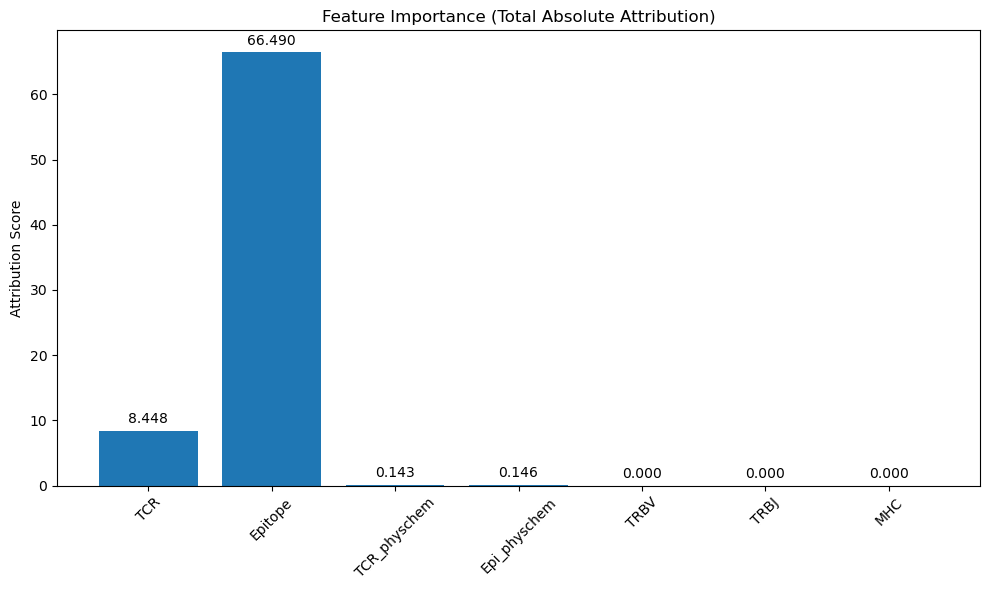

Feature Importance Summary:
TCR            : 8.447828
Epitope        : 66.490356
TCR_physchem   : 0.142646
Epi_physchem   : 0.146253
TRBV           : 0.000000
TRBJ           : 0.000000
MHC            : 0.000000
✅ Visualization created successfully!

🎉 All steps completed successfully!
You now have a working feature importance analysis!


In [37]:
success = run_step_by_step_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)


==================================
### comprehensive analysis
====================================

In [14]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients, GradientShap, DeepLift
import warnings
warnings.filterwarnings('ignore')

class ComprehensiveTCRAnalyzer:
    """
    Comprehensive TCR-Epitope feature importance analyzer
    """
    
    def __init__(self, model, device=None):
        self.model = model
        self.device = device or next(model.parameters()).device
        self.model.eval()
        
        # Create model wrapper for continuous features
        def continuous_model_wrapper(tcr, epitope, tcr_phys, epi_phys):
            batch_size = tcr.shape[0]
            # Use reasonable default values for categorical features
            trbv = torch.tensor([0], device=self.device).expand(batch_size)
            trbj = torch.tensor([0], device=self.device).expand(batch_size)  
            mhc = torch.tensor([0], device=self.device).expand(batch_size)
            return self.model(tcr, epitope, tcr_phys, epi_phys, trbv, trbj, mhc)
        
        # Initialize attribution methods
        self.ig = IntegratedGradients(continuous_model_wrapper)
        self.gs = GradientShap(continuous_model_wrapper)
        self.dl = DeepLift(continuous_model_wrapper)
    
    def extract_sample_data(self, test_data, tcr_embeddings, epitope_embeddings, physchem_file, sample_idx):
        """Extract and prepare data for a single sample"""
        sample_row = test_data.iloc[sample_idx]
        
        # Extract identifiers and labels
        tcr_id = sample_row["TRB_CDR3"]
        epitope_id = sample_row["Epitope"]
        phys_idx = sample_row["physchem_index"]
        
        # Extract embeddings and features
        tcr_embedding = tcr_embeddings[tcr_id][:]
        epitope_embedding = epitope_embeddings[epitope_id][:]
        tcr_physchem = physchem_file["tcr_encoded"][phys_idx]
        epi_physchem = physchem_file["epi_encoded"][phys_idx]
        
        # Convert to tensors with batch dimension
        sample_tensors = {
            'tcr': torch.tensor(tcr_embedding, dtype=torch.float32).unsqueeze(0).to(self.device),
            'epitope': torch.tensor(epitope_embedding, dtype=torch.float32).unsqueeze(0).to(self.device),
            'tcr_physchem': torch.tensor(tcr_physchem, dtype=torch.float32).unsqueeze(0).to(self.device),
            'epi_physchem': torch.tensor(epi_physchem, dtype=torch.float32).unsqueeze(0).to(self.device),
            'trbv': torch.tensor([sample_row["TRBV_Index"]], dtype=torch.long).to(self.device),
            'trbj': torch.tensor([sample_row["TRBJ_Index"]], dtype=torch.long).to(self.device),
            'mhc': torch.tensor([sample_row["MHC_Index"]], dtype=torch.long).to(self.device)
        }
        
        # Sample metadata
        sample_info = {
            'tcr_sequence': tcr_id,
            'epitope_sequence': epitope_id,
            'true_label': sample_row["Binding"],
            'trbv': sample_row["TRBV"],
            'trbj': sample_row["TRBJ"],
            'mhc': sample_row["MHC"],
            'task': sample_row.get("task", "unknown"),
            'sample_idx': sample_idx
        }
        
        return sample_tensors, sample_info
    
    def get_model_prediction(self, sample_tensors):
        """Get model prediction for a sample"""
        with torch.no_grad():
            output = self.model(
                sample_tensors['tcr'], sample_tensors['epitope'],
                sample_tensors['tcr_physchem'], sample_tensors['epi_physchem'],
                sample_tensors['trbv'], sample_tensors['trbj'], sample_tensors['mhc']
            )
            return torch.sigmoid(output).item()
    
    def compute_attributions(self, sample_tensors, method='integrated_gradients', n_steps=50):
        """Compute feature attributions using specified method"""
        
        # Prepare continuous inputs and baselines
        inputs = (
            sample_tensors['tcr'].requires_grad_(True),
            sample_tensors['epitope'].requires_grad_(True),
            sample_tensors['tcr_physchem'].requires_grad_(True),
            sample_tensors['epi_physchem'].requires_grad_(True)
        )
        
        baselines = (
            torch.zeros_like(sample_tensors['tcr']),
            torch.zeros_like(sample_tensors['epitope']),
            torch.zeros_like(sample_tensors['tcr_physchem']),
            torch.zeros_like(sample_tensors['epi_physchem'])
        )
        
        # Compute attributions based on method
        if method == 'integrated_gradients':
            attributions = self.ig.attribute(inputs, baselines=baselines, n_steps=n_steps)
        elif method == 'gradient_shap':
            attributions = self.gs.attribute(inputs, baselines=baselines, n_samples=50)
        elif method == 'deeplift':
            attributions = self.dl.attribute(inputs, baselines=baselines)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        return attributions
    
    def analyze_sample(self, test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                      sample_idx, methods=['integrated_gradients']):
        """Complete analysis of a single sample"""
        
        # Extract sample data
        sample_tensors, sample_info = self.extract_sample_data(
            test_data, tcr_embeddings, epitope_embeddings, physchem_file, sample_idx
        )
        
        # Get prediction
        prediction = self.get_model_prediction(sample_tensors)
        sample_info['predicted_prob'] = prediction
        
        print(f"Analyzing Sample {sample_idx}:")
        print(f"  TCR: {sample_info['tcr_sequence']}")
        print(f"  Epitope: {sample_info['epitope_sequence']}")
        print(f"  True Label: {sample_info['true_label']}")
        print(f"  Prediction: {prediction:.4f}")
        print(f"  MHC: {sample_info['mhc']}")
        
        results = {}
        
        for method in methods:
            print(f"\nComputing {method}...")
            
            # Compute attributions
            attributions = self.compute_attributions(sample_tensors, method=method)
            
            # Calculate importance scores
            importance_scores = {
                'TCR': torch.abs(attributions[0]).sum().item(),
                'Epitope': torch.abs(attributions[1]).sum().item(),
                'TCR_physchem': torch.abs(attributions[2]).sum().item(),
                'Epi_physchem': torch.abs(attributions[3]).sum().item()
            }
            
            # Store results
            results[method] = {
                'attributions': attributions,
                'importance_scores': importance_scores,
                'sample_info': sample_info
            }
        
        return results
    
    def analyze_sequence_positions(self, attributions, sample_info):
        """Analyze importance at sequence position level"""
        tcr_attr = attributions[0].squeeze(0)  # Remove batch dimension
        epitope_attr = attributions[1].squeeze(0)
        
        # Sum across embedding dimension to get per-position importance
        tcr_pos_importance = torch.abs(tcr_attr).sum(dim=-1).detach().cpu().numpy()
        epitope_pos_importance = torch.abs(epitope_attr).sum(dim=-1).detach().cpu().numpy()
        
        return {
            'tcr_positions': tcr_pos_importance,
            'epitope_positions': epitope_pos_importance
        }
    
    def create_comprehensive_visualization(self, all_results, sample_info):
        """Create comprehensive visualization of results"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'TCR-Epitope Feature Importance Analysis\n'
                    f'TCR: {sample_info["tcr_sequence"]} | Epitope: {sample_info["epitope_sequence"]}\n'
                    f'True: {sample_info["true_label"]} | Pred: {sample_info["predicted_prob"]:.3f} | MHC: {sample_info["mhc"]}', 
                    fontsize=14, fontweight='bold')
        
        methods = list(all_results.keys())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(methods)]
        
        # 1. Overall feature importance comparison
        ax1 = axes[0, 0]
        feature_names = ['TCR', 'Epitope', 'TCR_phys', 'Epi_phys']
        x = np.arange(len(feature_names))
        width = 0.25 if len(methods) > 1 else 0.6
        
        for i, (method, color) in enumerate(zip(methods, colors)):
            scores = [all_results[method]['importance_scores'][name] for name in 
                     ['TCR', 'Epitope', 'TCR_physchem', 'Epi_physchem']]
            offset = (i - len(methods)/2 + 0.5) * width if len(methods) > 1 else 0
            ax1.bar(x + offset, scores, width, label=method.replace('_', ' ').title(), color=color, alpha=0.7)
        
        ax1.set_xlabel('Feature Type')
        ax1.set_ylabel('Attribution Score')
        ax1.set_title('Feature Importance by Method')
        ax1.set_xticks(x)
        ax1.set_xticklabels(feature_names)
        if len(methods) > 1:
            ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Use first method for remaining plots
        primary_method = methods[0]
        scores = all_results[primary_method]['importance_scores']
        attributions = all_results[primary_method]['attributions']
        
        # 2. Feature group analysis (pie chart)
        ax2 = axes[0, 1]
        
        sequence_score = scores['TCR'] + scores['Epitope']
        physchem_score = scores['TCR_physchem'] + scores['Epi_physchem']
        
        pie_data = [sequence_score, physchem_score]
        pie_labels = ['Sequence Features', 'Physicochemical Features']
        pie_colors = ['#ff9999', '#66b2ff']
        
        wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%',
                                          colors=pie_colors, startangle=90)
        ax2.set_title(f'Feature Group Distribution\n({primary_method.replace("_", " ").title()})')
        
        # 3. TCR vs Epitope comparison
        ax3 = axes[0, 2]
        tcr_epitope_data = [scores['TCR'], scores['Epitope']]
        tcr_epitope_labels = ['TCR', 'Epitope']
        tcr_epitope_colors = ['#2ca02c', '#d62728']
        
        bars = ax3.bar(tcr_epitope_labels, tcr_epitope_data, color=tcr_epitope_colors, alpha=0.7)
        ax3.set_ylabel('Attribution Score')
        ax3.set_title('TCR vs Epitope Importance')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, tcr_epitope_data):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tcr_epitope_data)*0.01,
                    f'{value:.2f}', ha='center', va='bottom')
        
        # 4. Sequence position analysis
        seq_analysis = self.analyze_sequence_positions(attributions, sample_info)
        
        ax4 = axes[1, 0]
        positions = np.arange(len(seq_analysis['tcr_positions']))
        ax4.plot(positions, seq_analysis['tcr_positions'], 'o-', color='#2ca02c', linewidth=2, markersize=4)
        ax4.fill_between(positions, seq_analysis['tcr_positions'], alpha=0.3, color='#2ca02c')
        ax4.set_xlabel('Sequence Position')
        ax4.set_ylabel('Attribution Score')
        ax4.set_title('TCR Position Importance')
        ax4.grid(True, alpha=0.3)
        
        # Highlight top 3 positions
        top_positions = np.argsort(seq_analysis['tcr_positions'])[-3:]
        for pos in top_positions:
            ax4.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
            ax4.text(pos, seq_analysis['tcr_positions'][pos], f'{pos}', 
                    ha='center', va='bottom', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        ax5 = axes[1, 1]
        positions = np.arange(len(seq_analysis['epitope_positions']))
        ax5.plot(positions, seq_analysis['epitope_positions'], 'o-', color='#d62728', linewidth=2, markersize=4)
        ax5.fill_between(positions, seq_analysis['epitope_positions'], alpha=0.3, color='#d62728')
        ax5.set_xlabel('Sequence Position')
        ax5.set_ylabel('Attribution Score')
        ax5.set_title('Epitope Position Importance')
        ax5.grid(True, alpha=0.3)
        
        # Highlight top 3 positions
        top_positions = np.argsort(seq_analysis['epitope_positions'])[-3:]
        for pos in top_positions:
            ax5.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
            ax5.text(pos, seq_analysis['epitope_positions'][pos], f'{pos}', 
                    ha='center', va='bottom', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        # 6. Summary statistics
        ax6 = axes[1, 2]
        ax6.axis('off')
        
        summary_text = f"""
Sample Summary:
• Sample Index: {sample_info['sample_idx']}
• Task: {sample_info['task']}
• TRBV: {sample_info['trbv']}
• TRBJ: {sample_info['trbj']}

Feature Importance:
• Total Attribution: {sum(scores.values()):.3f}
• Epitope Dominance: {scores['Epitope']/scores['TCR']:.1f}x TCR
• Sequence vs Physchem: {sequence_score/physchem_score:.0f}:1

Model Performance:
• Confidence: {abs(sample_info['predicted_prob'] - 0.5)*2:.1%}
• Correct Prediction: {'✓' if (sample_info['predicted_prob'] > 0.5) == sample_info['true_label'] else '✗'}
        """
        
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        return fig
    
    def compare_multiple_samples(self, test_data, tcr_embeddings, epitope_embeddings, physchem_file,
                               sample_indices, method='integrated_gradients'):
        """Compare feature importance across multiple samples"""
        
        all_results = []
        
        for idx in sample_indices:
            print(f"\n{'='*50}")
            results = self.analyze_sample(
                test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                idx, methods=[method]
            )
            all_results.append(results[method])
        
        # Create comparison visualization
        self.create_comparison_visualization(all_results, method)
        
        return all_results
    
    def create_comparison_visualization(self, all_results, method):
        """Create visualization comparing multiple samples"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Multi-Sample Feature Importance Comparison ({method.replace("_", " ").title()})', 
                    fontsize=14, fontweight='bold')
        
        # Extract data for plotting
        sample_labels = []
        tcr_scores = []
        epitope_scores = []
        tcr_phys_scores = []
        epi_phys_scores = []
        predictions = []
        true_labels = []
        
        for i, result in enumerate(all_results):
            info = result['sample_info']
            scores = result['importance_scores']
            
            sample_labels.append(f"S{i}\n{info['true_label']}")
            tcr_scores.append(scores['TCR'])
            epitope_scores.append(scores['Epitope'])
            tcr_phys_scores.append(scores['TCR_physchem'])
            epi_phys_scores.append(scores['Epi_physchem'])
            predictions.append(info['predicted_prob'])
            true_labels.append(info['true_label'])
        
        # 1. Stacked bar chart of all features
        ax1 = axes[0, 0]
        x = np.arange(len(sample_labels))
        width = 0.6
        
        p1 = ax1.bar(x, tcr_scores, width, label='TCR', color='#2ca02c', alpha=0.8)
        p2 = ax1.bar(x, epitope_scores, width, bottom=tcr_scores, label='Epitope', color='#d62728', alpha=0.8)
        p3 = ax1.bar(x, tcr_phys_scores, width, 
                    bottom=np.array(tcr_scores) + np.array(epitope_scores), 
                    label='TCR Physchem', color='#ff7f0e', alpha=0.8)
        p4 = ax1.bar(x, epi_phys_scores, width,
                    bottom=np.array(tcr_scores) + np.array(epitope_scores) + np.array(tcr_phys_scores),
                    label='Epi Physchem', color='#1f77b4', alpha=0.8)
        
        ax1.set_xlabel('Samples (True Label)')
        ax1.set_ylabel('Attribution Score')
        ax1.set_title('Feature Importance by Sample')
        ax1.set_xticks(x)
        ax1.set_xticklabels(sample_labels)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. TCR vs Epitope ratio
        ax2 = axes[0, 1]
        ratios = np.array(epitope_scores) / (np.array(tcr_scores) + 1e-8)  # Add small epsilon to avoid division by zero
        colors = ['green' if label == 1 else 'red' for label in true_labels]
        
        bars = ax2.bar(range(len(ratios)), ratios, color=colors, alpha=0.7)
        ax2.set_xlabel('Sample')
        ax2.set_ylabel('Epitope/TCR Ratio')
        ax2.set_title('Epitope vs TCR Importance Ratio')
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal importance')
        ax2.set_xticks(range(len(sample_labels)))
        ax2.set_xticklabels([f"S{i}" for i in range(len(sample_labels))])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Prediction vs True Label
        ax3 = axes[1, 0]
        scatter_colors = ['green' if pred > 0.5 else 'red' for pred in predictions]
        scatter = ax3.scatter(true_labels, predictions, c=scatter_colors, alpha=0.7, s=100)
        
        ax3.plot([0, 1], [0.5, 0.5], 'k--', alpha=0.5, label='Decision boundary')
        ax3.set_xlabel('True Label')
        ax3.set_ylabel('Predicted Probability')
        ax3.set_title('Prediction vs True Label')
        ax3.set_xlim(-0.1, 1.1)
        ax3.set_ylim(-0.05, 1.05)
        ax3.grid(True, alpha=0.3)
        
        # Add sample labels
        for i, (true_label, pred) in enumerate(zip(true_labels, predictions)):
            ax3.annotate(f'S{i}', (true_label, pred), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)
        
        # 4. Summary statistics
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        # Calculate summary stats
        binding_samples = [i for i, label in enumerate(true_labels) if label == 1]
        non_binding_samples = [i for i, label in enumerate(true_labels) if label == 0]
        
        if binding_samples:
            binding_epitope_importance = np.mean([epitope_scores[i] for i in binding_samples])
            binding_tcr_importance = np.mean([tcr_scores[i] for i in binding_samples])
        else:
            binding_epitope_importance = binding_tcr_importance = 0
            
        if non_binding_samples:
            non_binding_epitope_importance = np.mean([epitope_scores[i] for i in non_binding_samples])
            non_binding_tcr_importance = np.mean([tcr_scores[i] for i in non_binding_samples])
        else:
            non_binding_epitope_importance = non_binding_tcr_importance = 0
        
        summary_text = f"""
Multi-Sample Analysis Summary:

Total Samples: {len(all_results)}
• Binding: {len(binding_samples)}
• Non-binding: {len(non_binding_samples)}

Average Importance (Binding):
• Epitope: {binding_epitope_importance:.2f}
• TCR: {binding_tcr_importance:.2f}
• Ratio: {binding_epitope_importance/(binding_tcr_importance+1e-8):.1f}

Average Importance (Non-binding):
• Epitope: {non_binding_epitope_importance:.2f}
• TCR: {non_binding_tcr_importance:.2f}
• Ratio: {non_binding_epitope_importance/(non_binding_tcr_importance+1e-8):.1f}

Overall Patterns:
• Max Epitope Importance: {max(epitope_scores):.2f}
• Max TCR Importance: {max(tcr_scores):.2f}
• Avg Epi/TCR Ratio: {np.mean(ratios):.1f}
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

# Usage functions
def analyze_single_sample(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                         sample_idx=0, methods=['integrated_gradients']):
    """Analyze a single sample with comprehensive visualization"""
    
    analyzer = ComprehensiveTCRAnalyzer(model)
    results = analyzer.analyze_sample(
        test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
        sample_idx, methods=methods
    )
    
    # Create visualization - pass the full results dictionary and sample info
    sample_info = results[methods[0]]['sample_info']  # Sample info is the same for all methods
    fig = analyzer.create_comprehensive_visualization(results, sample_info)
    plt.show()
    
    return results

def analyze_multiple_samples(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file,
                           sample_indices=[0, 1, 2, 3, 4], method='integrated_gradients'):
    """Analyze multiple samples with comparison visualization"""
    
    analyzer = ComprehensiveTCRAnalyzer(model)
    results = analyzer.compare_multiple_samples(
        test_data, tcr_embeddings, epitope_embeddings, physchem_file,
        sample_indices, method=method
    )
    
    return results

# Example usage
print("""
Comprehensive TCR Feature Importance Analysis

SINGLE SAMPLE ANALYSIS:
results = analyze_single_sample(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients', 'gradient_shap']
)

MULTIPLE SAMPLE COMPARISON:  
results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=[0, 1, 5, 10, 15],  # Mix of binding/non-binding samples
    method='integrated_gradients'
)
""")


Comprehensive TCR Feature Importance Analysis

SINGLE SAMPLE ANALYSIS:
results = analyze_single_sample(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients', 'gradient_shap']
)

MULTIPLE SAMPLE COMPARISON:  
results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=[0, 1, 5, 10, 15],  # Mix of binding/non-binding samples
    method='integrated_gradients'
)



Analyzing Sample 0:
  TCR: CASSPSQGMNTEAFF
  Epitope: RTLNAWVKV
  True Label: 0
  Prediction: 0.0048
  MHC: HLA-A*02:01

Computing integrated_gradients...

Computing gradient_shap...


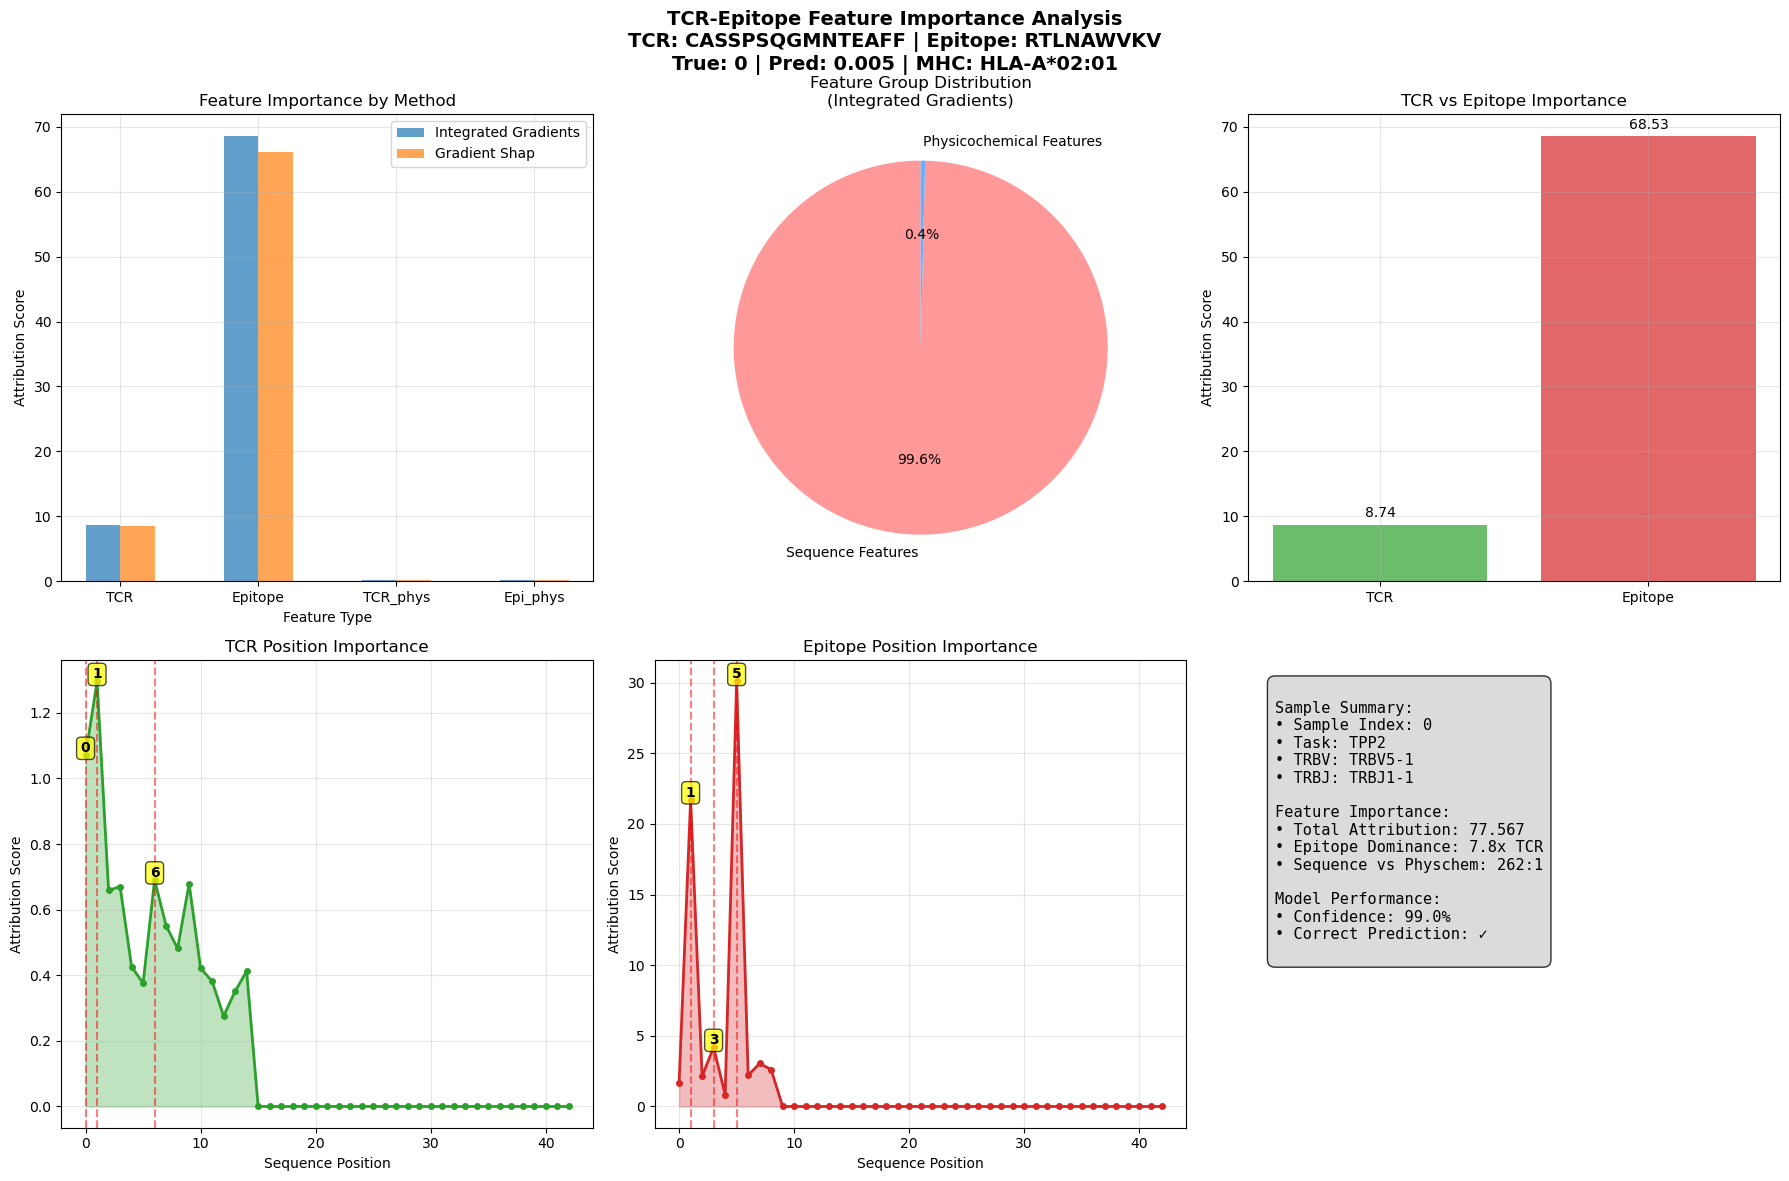

In [8]:
# Analyze one sample with multiple methods
results = analyze_single_sample(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients', 'gradient_shap']
)


Analyzing Sample 98:
  TCR: CASSYLPGQGDHYSNQPQHF
  Epitope: FLKEKGGL
  True Label: 1
  Prediction: 0.8525
  MHC: HLA-B*08

Computing integrated_gradients...

Analyzing Sample 99:
  TCR: CATSGGLSTEAFF
  Epitope: AVFDRKSDAK
  True Label: 1
  Prediction: 0.8686
  MHC: HLA-A*11:01

Computing integrated_gradients...

Analyzing Sample 100:
  TCR: CASSSWTSGGRSYNEQFF
  Epitope: KLGGALQAK
  True Label: 1
  Prediction: 0.9667
  MHC: HLA-A*03:01

Computing integrated_gradients...

Analyzing Sample 0:
  TCR: CASSPSQGMNTEAFF
  Epitope: RTLNAWVKV
  True Label: 0
  Prediction: 0.0048
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 1:
  TCR: CASSSTRDSTDTQYF
  Epitope: LLMGTLGIVC
  True Label: 0
  Prediction: 0.0024
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 2:
  TCR: CASSRGWGDNEQFF
  Epitope: RIAAWMATY
  True Label: 0
  Prediction: 0.0028
  MHC: HLA-A*03:01

Computing integrated_gradients...


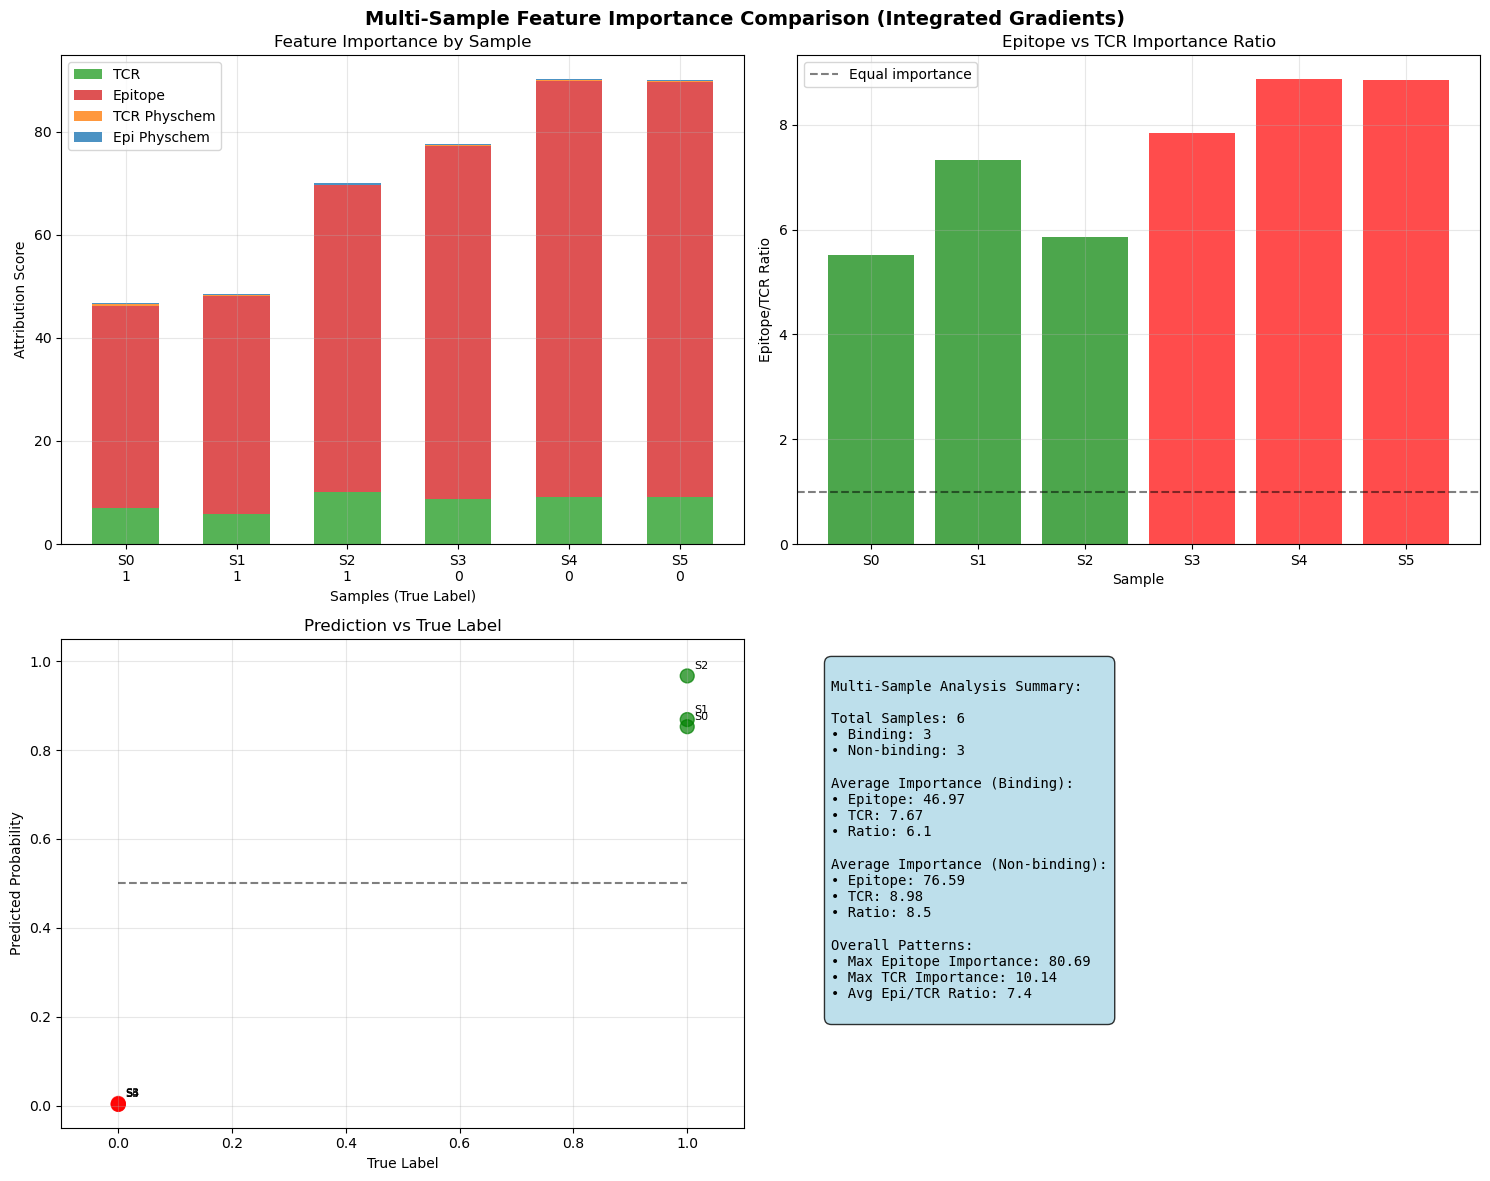

In [44]:
# Find some binding and non-binding samples
binding_samples = test_data[test_data['Binding'] == 1].index[:3].tolist()
non_binding_samples = test_data[test_data['Binding'] == 0].index[:3].tolist()
mixed_samples = binding_samples + non_binding_samples

results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=mixed_samples,
    method='integrated_gradients'
)


Analyzing Sample 0:
  TCR: CASSPSQGMNTEAFF
  Epitope: RTLNAWVKV
  True Label: 0
  Prediction: 0.0048
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 2:
  TCR: CASSRGWGDNEQFF
  Epitope: RIAAWMATY
  True Label: 0
  Prediction: 0.0028
  MHC: HLA-A*03:01

Computing integrated_gradients...

Analyzing Sample 3:
  TCR: CASRPWLWREGLNEQFF
  Epitope: IVTDFSVIK
  True Label: 0
  Prediction: 0.1193
  MHC: HLA-A*11:01

Computing integrated_gradients...

Analyzing Sample 4:
  TCR: CASSLSWGDTEAFF
  Epitope: GPAESAAGL
  True Label: 0
  Prediction: 0.0043
  MHC: HLA-B*07:02

Computing integrated_gradients...

Analyzing Sample 8:
  TCR: CASSLSGVGQPQHF
  Epitope: AYAQKIFKI
  True Label: 0
  Prediction: 0.0037
  MHC: HLA-A*24:02

Computing integrated_gradients...


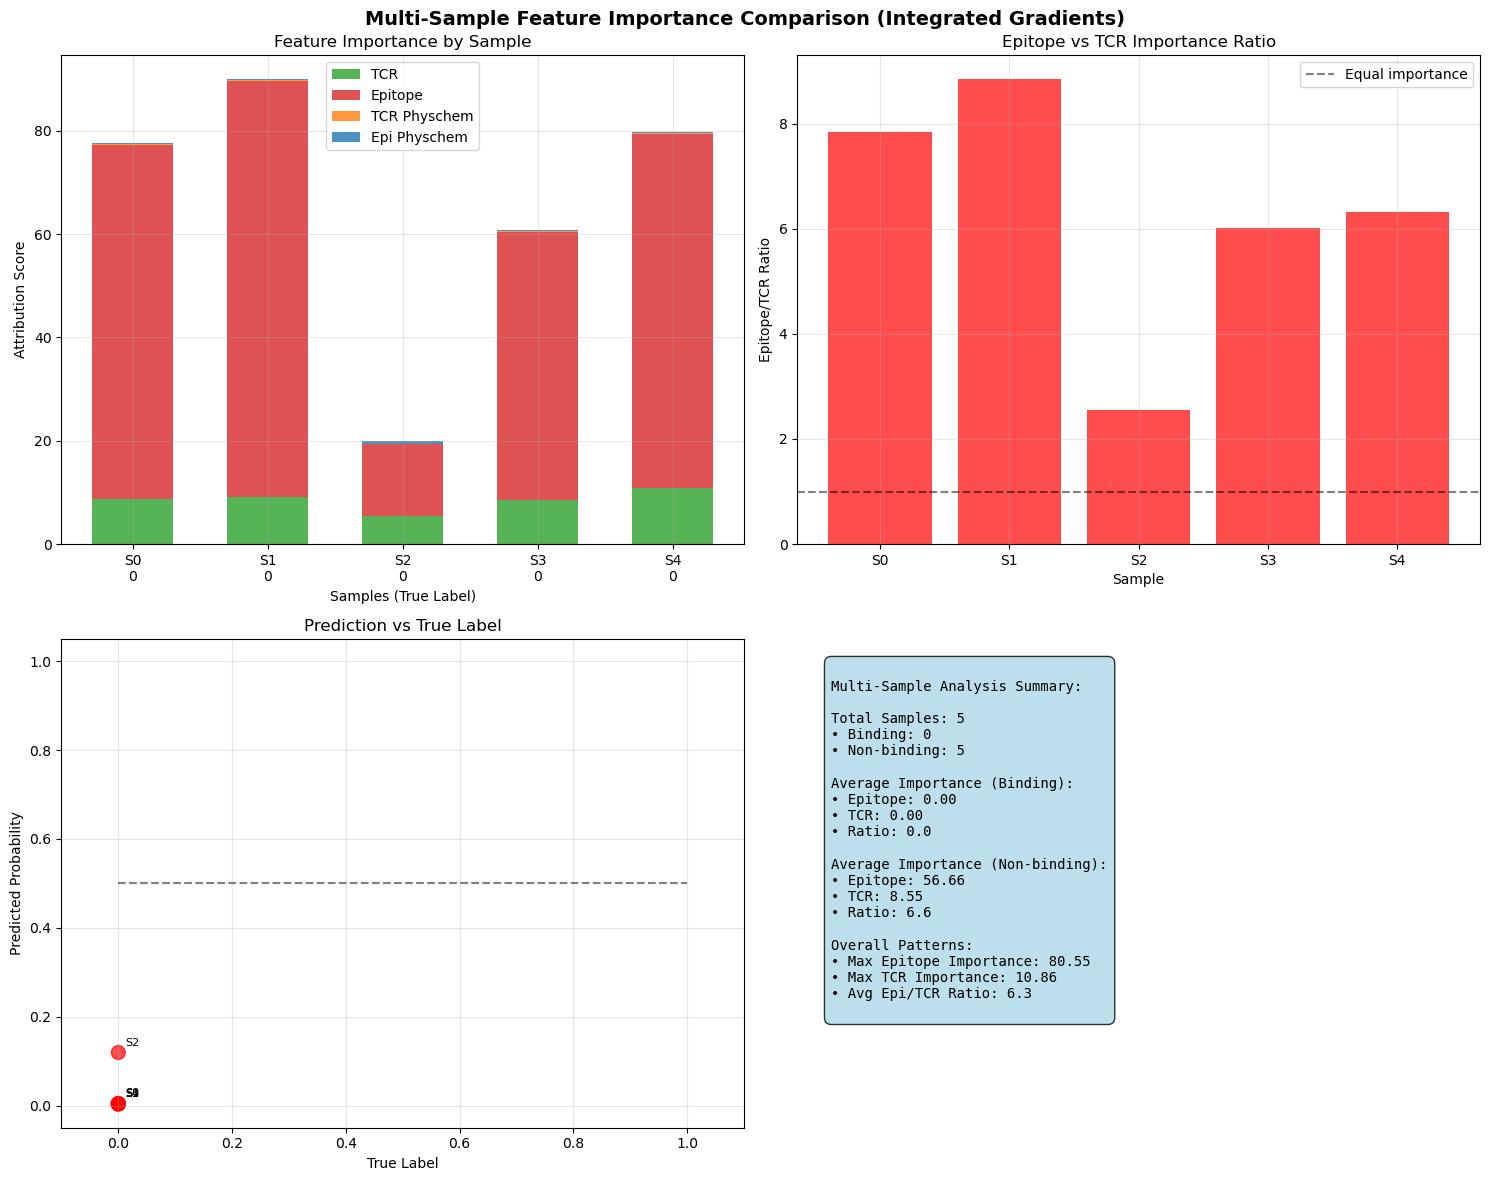

In [45]:
# Find samples with different MHC alleles
mhc_groups = test_data.groupby('MHC').head(1).index[:5].tolist()
results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=mhc_groups
)

In [10]:
# Sample across different categories
binding_samples = test_data[test_data['Binding'] == 1].sample(20).index.tolist()
non_binding_samples = test_data[test_data['Binding'] == 0].sample(20).index.tolist()

# Different MHC alleles
mhc_variety = []
for mhc in test_data['MHC'].value_counts().head(5).index:
    mhc_samples = test_data[test_data['MHC'] == mhc].sample(5).index.tolist()
    mhc_variety.extend(mhc_samples)

# Different tasks
task_variety = []
for task in test_data['task'].unique():
    task_samples = test_data[test_data['task'] == task].sample(5).index.tolist()
    task_variety.extend(task_samples)

# Combine for comprehensive analysis
comprehensive_sample_indices = list(set(binding_samples + non_binding_samples + mhc_variety + task_variety))


Analyzing Sample 9:
  TCR: CASSEYSKKLNYGYTF
  Epitope: CYTWNQMNL
  True Label: 0
  Prediction: 0.0015
  MHC: HLA-A*24:02

Computing integrated_gradients...

Analyzing Sample 27657:
  TCR: CASSPPEEFEQYF
  Epitope: TPRVTGGGAM
  True Label: 0
  Prediction: 0.6123
  MHC: HLA-B*07

Computing integrated_gradients...

Analyzing Sample 5643:
  TCR: CASSLIGNTGELFF
  Epitope: ATDALMTGF
  True Label: 1
  Prediction: 0.9352
  MHC: HLA-A*01:01

Computing integrated_gradients...

Analyzing Sample 43025:
  TCR: CSADPVPNIEQFF
  Epitope: TPRVTGGGAM
  True Label: 0
  Prediction: 0.5701
  MHC: HLA-B*07:02

Computing integrated_gradients...

Analyzing Sample 37907:
  TCR: CASSVGDFRELFF
  Epitope: KLGGALQAK
  True Label: 1
  Prediction: 0.9645
  MHC: HLA-A*03:01

Computing integrated_gradients...

Analyzing Sample 31763:
  TCR: CASSVLAGHGNGQFF
  Epitope: SLFNTVATLY
  True Label: 0
  Prediction: 0.8740
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 9245:
  TCR: CASTPGGLGQPQHF
  Epi

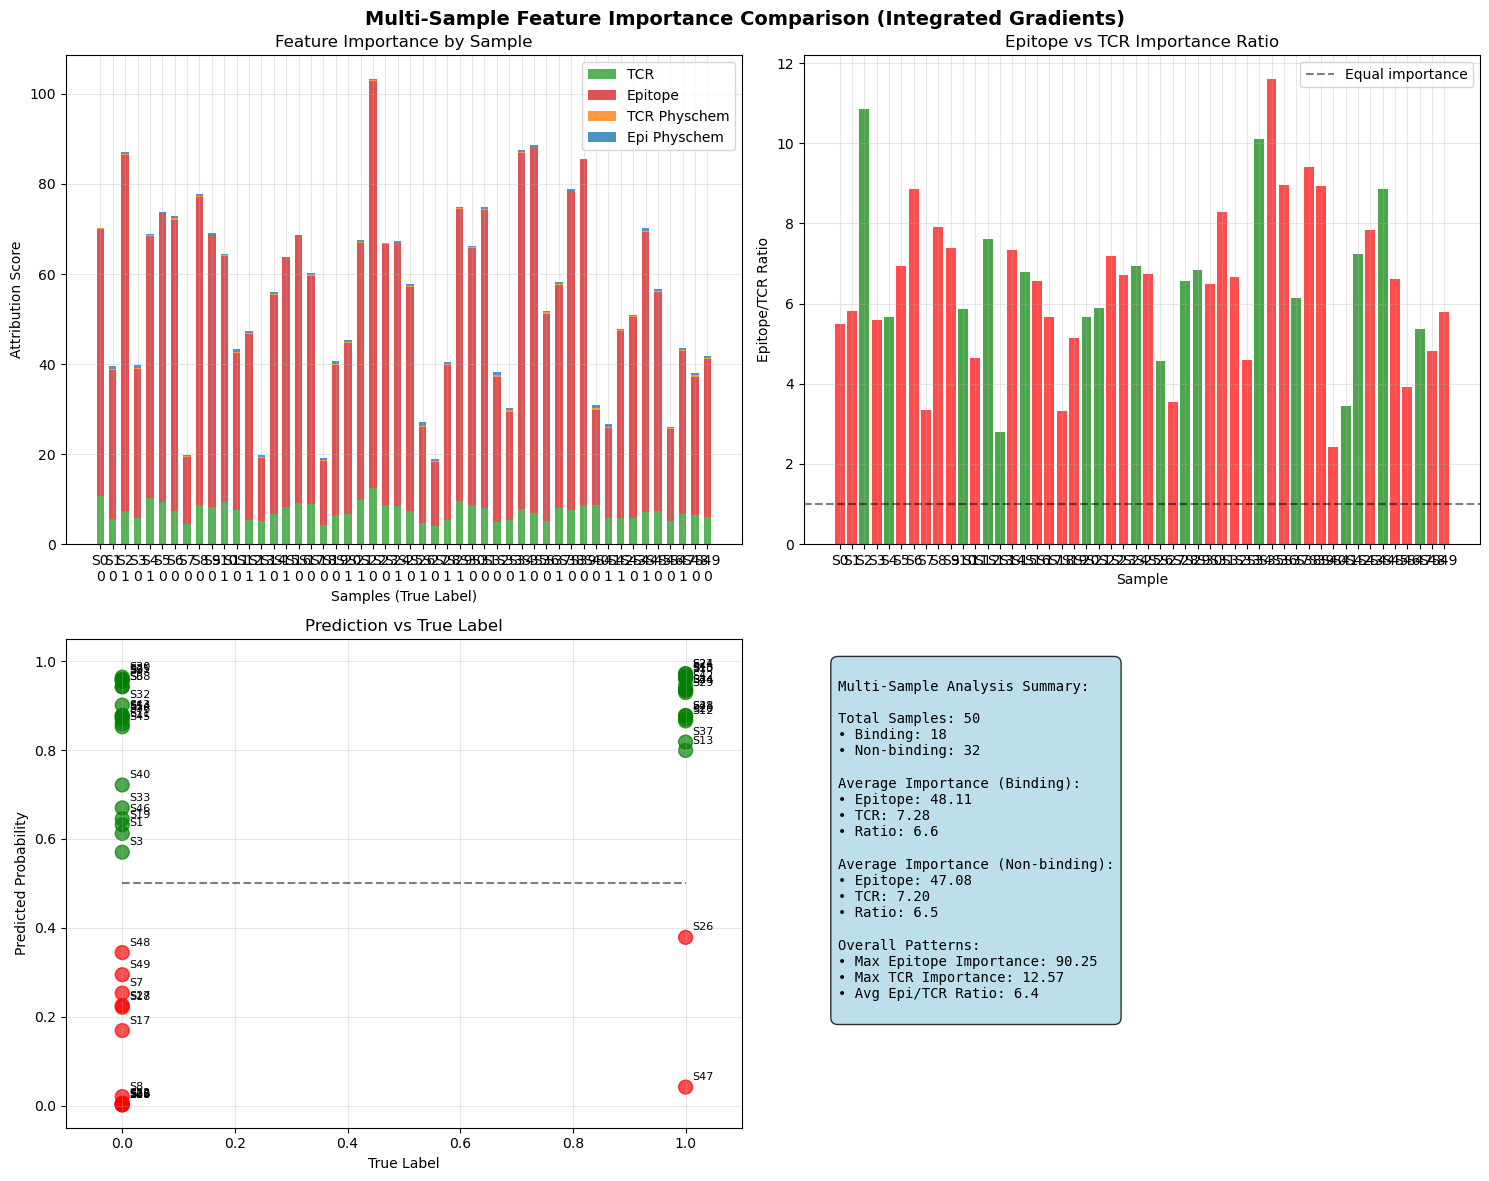

In [11]:
# Analyze many samples to get distributions
results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=comprehensive_sample_indices[:50],  # Start with 50 diverse samples
    method='integrated_gradients'
)


Analyzing Sample 52657:
  TCR: CASSDIAGGSYNEQFF
  Epitope: RPPIFIRRL
  True Label: 0
  Prediction: 0.1965
  MHC: HLA-B*07:02

Computing integrated_gradients...

Analyzing Sample 51824:
  TCR: CASSQDRGEGVEAFF
  Epitope: NLVPMVATV
  True Label: 0
  Prediction: 0.8842
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 10648:
  TCR: CASSFRGGKTQYF
  Epitope: ILDTAGKEEY
  True Label: 0
  Prediction: 0.9326
  MHC: HLA-A*01:01

Computing integrated_gradients...

Analyzing Sample 22506:
  TCR: CASSASTLETQYF
  Epitope: KAFSPEVIPMF
  True Label: 0
  Prediction: 0.5720
  MHC: HLA-B*57

Computing integrated_gradients...

Analyzing Sample 22872:
  TCR: CASSLMYEQYF
  Epitope: GLCTLVAML
  True Label: 0
  Prediction: 0.9725
  MHC: HLA-A*02

Computing integrated_gradients...

Analyzing Sample 31924:
  TCR: CSAQAGVDNSPLHF
  Epitope: EVDPIGHLY
  True Label: 0
  Prediction: 0.9497
  MHC: HLA-A*01:01:73

Computing integrated_gradients...

Analyzing Sample 42887:
  TCR: CASSGLGAEETQYF
 

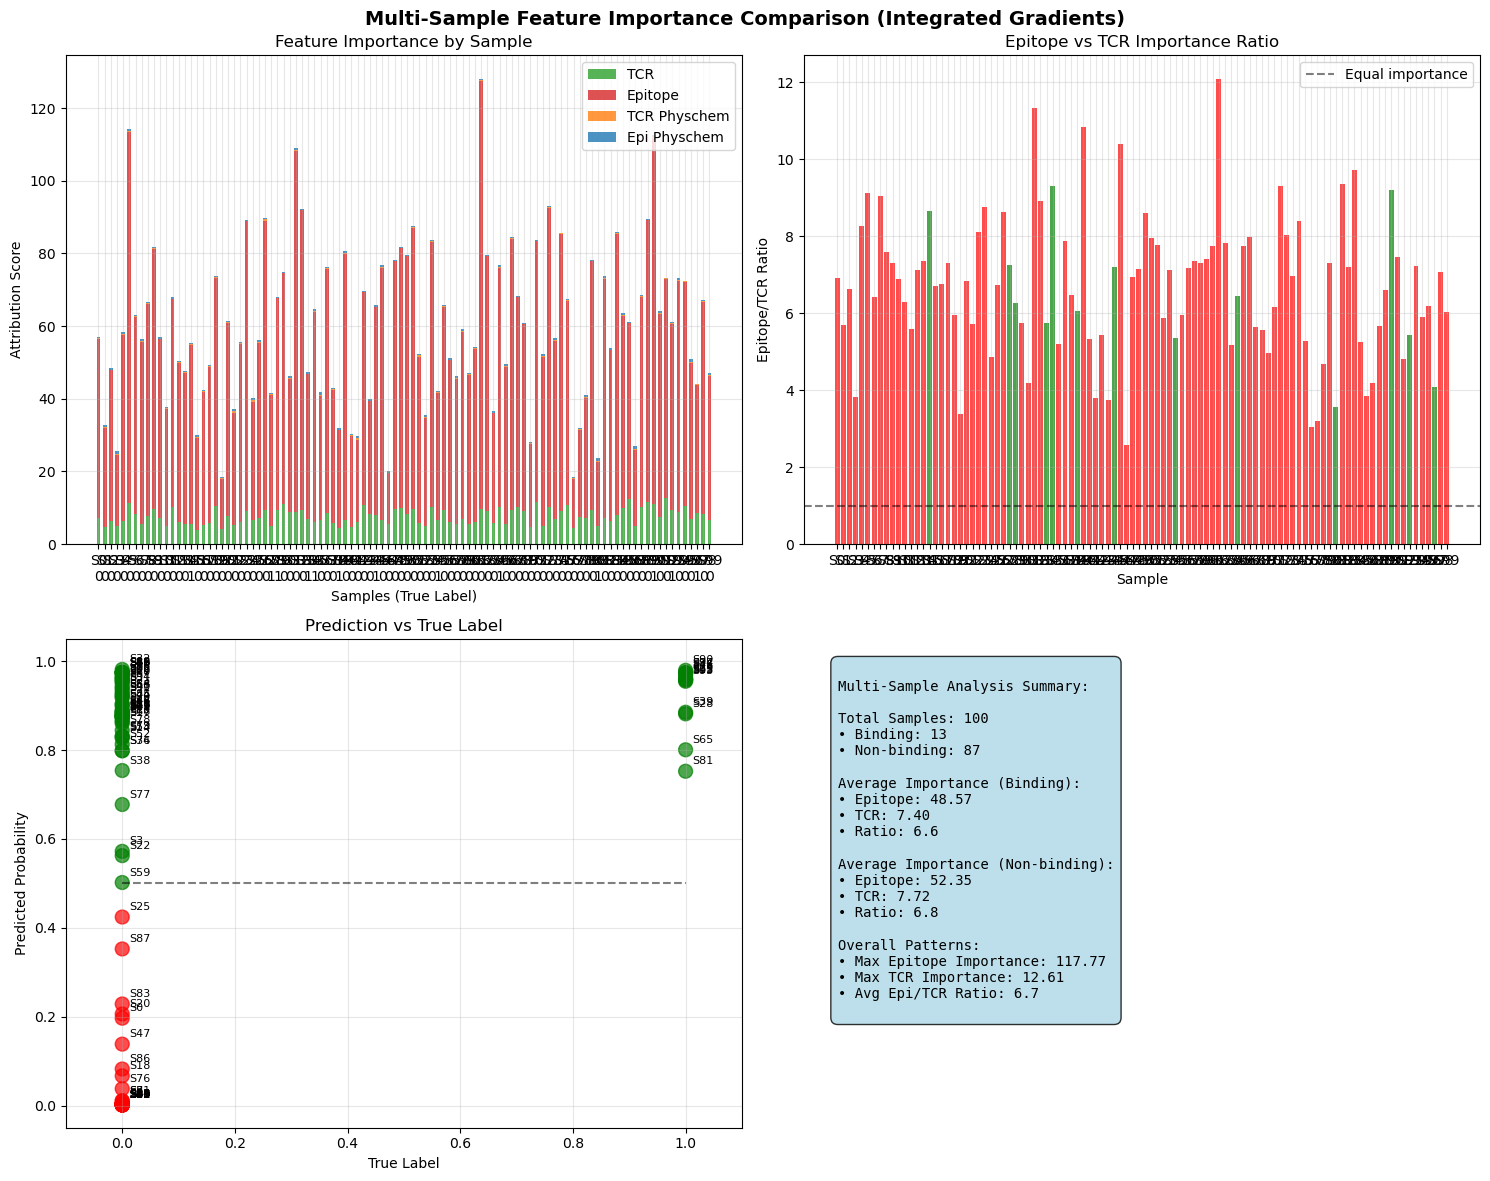

In [6]:
# Analyze 100+ diverse samples
large_sample = test_data.sample(100, random_state=42).index.tolist()
large_results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=large_sample
)

=============================
### Plot improvement

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_improved_comparison_visualization(all_results, method='integrated_gradients'):
    """
    Create an improved visualization comparing multiple samples with better readability
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Multi-Sample Feature Importance Comparison ({method.replace("_", " ").title()})', 
                fontsize=16, fontweight='bold')
    
    # Extract data for plotting
    sample_labels = []
    tcr_scores = []
    epitope_scores = []
    tcr_phys_scores = []
    epi_phys_scores = []
    predictions = []
    true_labels = []
    
    for i, result in enumerate(all_results):
        info = result['sample_info']
        scores = result['importance_scores']
        
        # Only use binding class labels (0 or 1) - remove sample IDs
        sample_labels.append(str(info['true_label']))
        tcr_scores.append(scores['TCR'])
        epitope_scores.append(scores['Epitope'])
        tcr_phys_scores.append(scores['TCR_physchem'])
        epi_phys_scores.append(scores['Epi_physchem'])
        predictions.append(info['predicted_prob'])
        true_labels.append(info['true_label'])
    
    # 1. Stacked bar chart of all features
    ax1 = axes[0, 0]
    x = np.arange(len(sample_labels))
    width = 0.8
    
    p1 = ax1.bar(x, tcr_scores, width, label='TCR', color='#2ca02c', alpha=0.8)
    p2 = ax1.bar(x, epitope_scores, width, bottom=tcr_scores, label='Epitope', color='#d62728', alpha=0.8)
    p3 = ax1.bar(x, tcr_phys_scores, width, 
                bottom=np.array(tcr_scores) + np.array(epitope_scores), 
                label='TCR Physchem', color='#ff7f0e', alpha=0.8)
    p4 = ax1.bar(x, epi_phys_scores, width,
                bottom=np.array(tcr_scores) + np.array(epitope_scores) + np.array(tcr_phys_scores),
                label='Epi Physchem', color='#1f77b4', alpha=0.8)
    
    ax1.set_xlabel('Samples (True Label)', fontsize=12)
    ax1.set_ylabel('Attribution Score', fontsize=12)
    ax1.set_title('Feature Importance by Sample', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(sample_labels, fontsize=10)  # Reduced font size for binding labels
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2. TCR vs Epitope ratio
    ax2 = axes[0, 1]
    ratios = np.array(epitope_scores) / (np.array(tcr_scores) + 1e-8)  # Add small epsilon to avoid division by zero
    # Use different colors to avoid confusion with feature colors
    colors = ['#4CAF50' if label == 1 else '#FF5722' for label in true_labels]  # Different shades: Green for binding, Orange-red for non-binding
    
    bars = ax2.bar(range(len(ratios)), ratios, color=colors, alpha=0.7)
    ax2.set_xlabel('Sample', fontsize=12)
    ax2.set_ylabel('Epitope/TCR Ratio', fontsize=12)
    ax2.set_title('Epitope vs TCR Importance Ratio', fontsize=14)
    ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal importance')
    ax2.set_xticks(range(0, len(sample_labels), max(1, len(sample_labels)//10)))  # Show fewer x-ticks
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Add color legend for binding status
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#4CAF50', alpha=0.7, label='Binding (1)'),
                      Patch(facecolor='#FF5722', alpha=0.7, label='Non-binding (0)')]
    ax2.legend(handles=legend_elements + [plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, label='Equal importance')], 
              fontsize=11, loc='upper right')
    
    # 3. Prediction vs True Label
    ax3 = axes[1, 0]
    # Use the same binding colors as plot 2 for consistency
    scatter_colors = ['#4CAF50' if pred > 0.5 else '#FF5722' for pred in predictions]
    scatter = ax3.scatter(true_labels, predictions, c=scatter_colors, alpha=0.7, s=60)
    
    ax3.plot([0, 1], [0.5, 0.5], 'k--', alpha=0.5, label='Decision boundary')
    ax3.set_xlabel('True Label', fontsize=12)
    ax3.set_ylabel('Predicted Probability', fontsize=12)
    ax3.set_title('Prediction vs True Label', fontsize=14)
    ax3.set_xlim(-0.1, 1.1)
    ax3.set_ylim(-0.05, 1.05)
    ax3.grid(True, alpha=0.3)
    
    # Add sample labels to points (reduced frequency for readability)
    for i in range(0, len(true_labels), max(1, len(true_labels)//20)):
        ax3.annotate(f'S{i}', (true_labels[i], predictions[i]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8, alpha=0.7)
    
    # 4. Enhanced Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate summary stats
    binding_samples = [i for i, label in enumerate(true_labels) if label == 1]
    non_binding_samples = [i for i, label in enumerate(true_labels) if label == 0]
    
    if binding_samples:
        binding_epitope_importance = np.mean([epitope_scores[i] for i in binding_samples])
        binding_tcr_importance = np.mean([tcr_scores[i] for i in binding_samples])
        binding_ratio = binding_epitope_importance / (binding_tcr_importance + 1e-8)
    else:
        binding_epitope_importance = binding_tcr_importance = binding_ratio = 0
        
    if non_binding_samples:
        non_binding_epitope_importance = np.mean([epitope_scores[i] for i in non_binding_samples])
        non_binding_tcr_importance = np.mean([tcr_scores[i] for i in non_binding_samples])
        non_binding_ratio = non_binding_epitope_importance / (non_binding_tcr_importance + 1e-8)
    else:
        non_binding_epitope_importance = non_binding_tcr_importance = non_binding_ratio = 0
    
    # Create larger, more readable summary text
    summary_text = f"""Multi-Sample Analysis Summary:

Total Samples: {len(all_results)}
• Binding: {len(binding_samples)}
• Non-binding: {len(non_binding_samples)}

Average Importance (Binding):
• Epitope: {binding_epitope_importance:.2f}
• TCR: {binding_tcr_importance:.2f}
• Ratio: {binding_ratio:.1f}

Average Importance (Non-binding):
• Epitope: {non_binding_epitope_importance:.2f}
• TCR: {non_binding_tcr_importance:.2f}
• Ratio: {non_binding_ratio:.1f}

Overall Patterns:
• Max Epitope Importance: {max(epitope_scores):.2f}
• Max TCR Importance: {max(tcr_scores):.2f}
• Avg Epi/TCR Ratio: {np.mean(ratios):.1f}"""
    
    # Make the summary box larger and more prominent
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=14,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.9, 
                     edgecolor='navy', linewidth=2))
    
    plt.tight_layout()
    plt.show()
    
    return fig

def apply_plot_improvements_to_existing_results(results_list):
    """
    Apply the improved visualization to your existing results
    
    Args:
        results_list: List of individual sample results from your analysis
    """
    
    # Convert your results to the expected format if needed
    formatted_results = []
    
    for result in results_list:
        # Assuming each result has the structure from your analysis
        # Adjust this based on your actual results structure
        formatted_result = {
            'sample_info': result.get('sample_info', {}),
            'importance_scores': result.get('importance_scores', {})
        }
        formatted_results.append(formatted_result)
    
    # Create the improved visualization
    return create_improved_comparison_visualization(formatted_results)

# If you have your results stored in a variable, use this:
def recreate_your_plot_with_improvements(your_results_data):
    """
    Recreate your specific plot with the requested improvements
    """
    
    # This assumes your_results_data is the data from your multi-sample analysis
    # Adjust the key names based on your actual data structure
    
    fig = create_improved_comparison_visualization(your_results_data)
    return fig

print("""
To apply these improvements to your plot:

1. If you have the raw results data:
   fig = create_improved_comparison_visualization(your_results_list)

2. If you need to rerun the analysis with improvements:
   # Rerun your multi-sample analysis, then use the improved plotting function

Key improvements made:
• Removed overlapping sample IDs from x-axis
• Kept only binding class labels (0, 1) for clarity
• Enlarged summary text box with better formatting
• Increased font sizes throughout
• Enhanced summary box styling with border
• Reduced x-tick frequency where appropriate for readability
""")


To apply these improvements to your plot:

1. If you have the raw results data:
   fig = create_improved_comparison_visualization(your_results_list)

2. If you need to rerun the analysis with improvements:
   # Rerun your multi-sample analysis, then use the improved plotting function

Key improvements made:
• Removed overlapping sample IDs from x-axis
• Kept only binding class labels (0, 1) for clarity
• Enlarged summary text box with better formatting
• Increased font sizes throughout
• Enhanced summary box styling with border
• Reduced x-tick frequency where appropriate for readability




Analyzing Sample 52657:
  TCR: CASSDIAGGSYNEQFF
  Epitope: RPPIFIRRL
  True Label: 0
  Prediction: 0.1965
  MHC: HLA-B*07:02

Computing integrated_gradients...

Analyzing Sample 51824:
  TCR: CASSQDRGEGVEAFF
  Epitope: NLVPMVATV
  True Label: 0
  Prediction: 0.8842
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 10648:
  TCR: CASSFRGGKTQYF
  Epitope: ILDTAGKEEY
  True Label: 0
  Prediction: 0.9326
  MHC: HLA-A*01:01

Computing integrated_gradients...

Analyzing Sample 22506:
  TCR: CASSASTLETQYF
  Epitope: KAFSPEVIPMF
  True Label: 0
  Prediction: 0.5720
  MHC: HLA-B*57

Computing integrated_gradients...

Analyzing Sample 22872:
  TCR: CASSLMYEQYF
  Epitope: GLCTLVAML
  True Label: 0
  Prediction: 0.9725
  MHC: HLA-A*02

Computing integrated_gradients...

Analyzing Sample 31924:
  TCR: CSAQAGVDNSPLHF
  Epitope: EVDPIGHLY
  True Label: 0
  Prediction: 0.9497
  MHC: HLA-A*01:01:73

Computing integrated_gradients...

Analyzing Sample 42887:
  TCR: CASSGLGAEETQYF
 

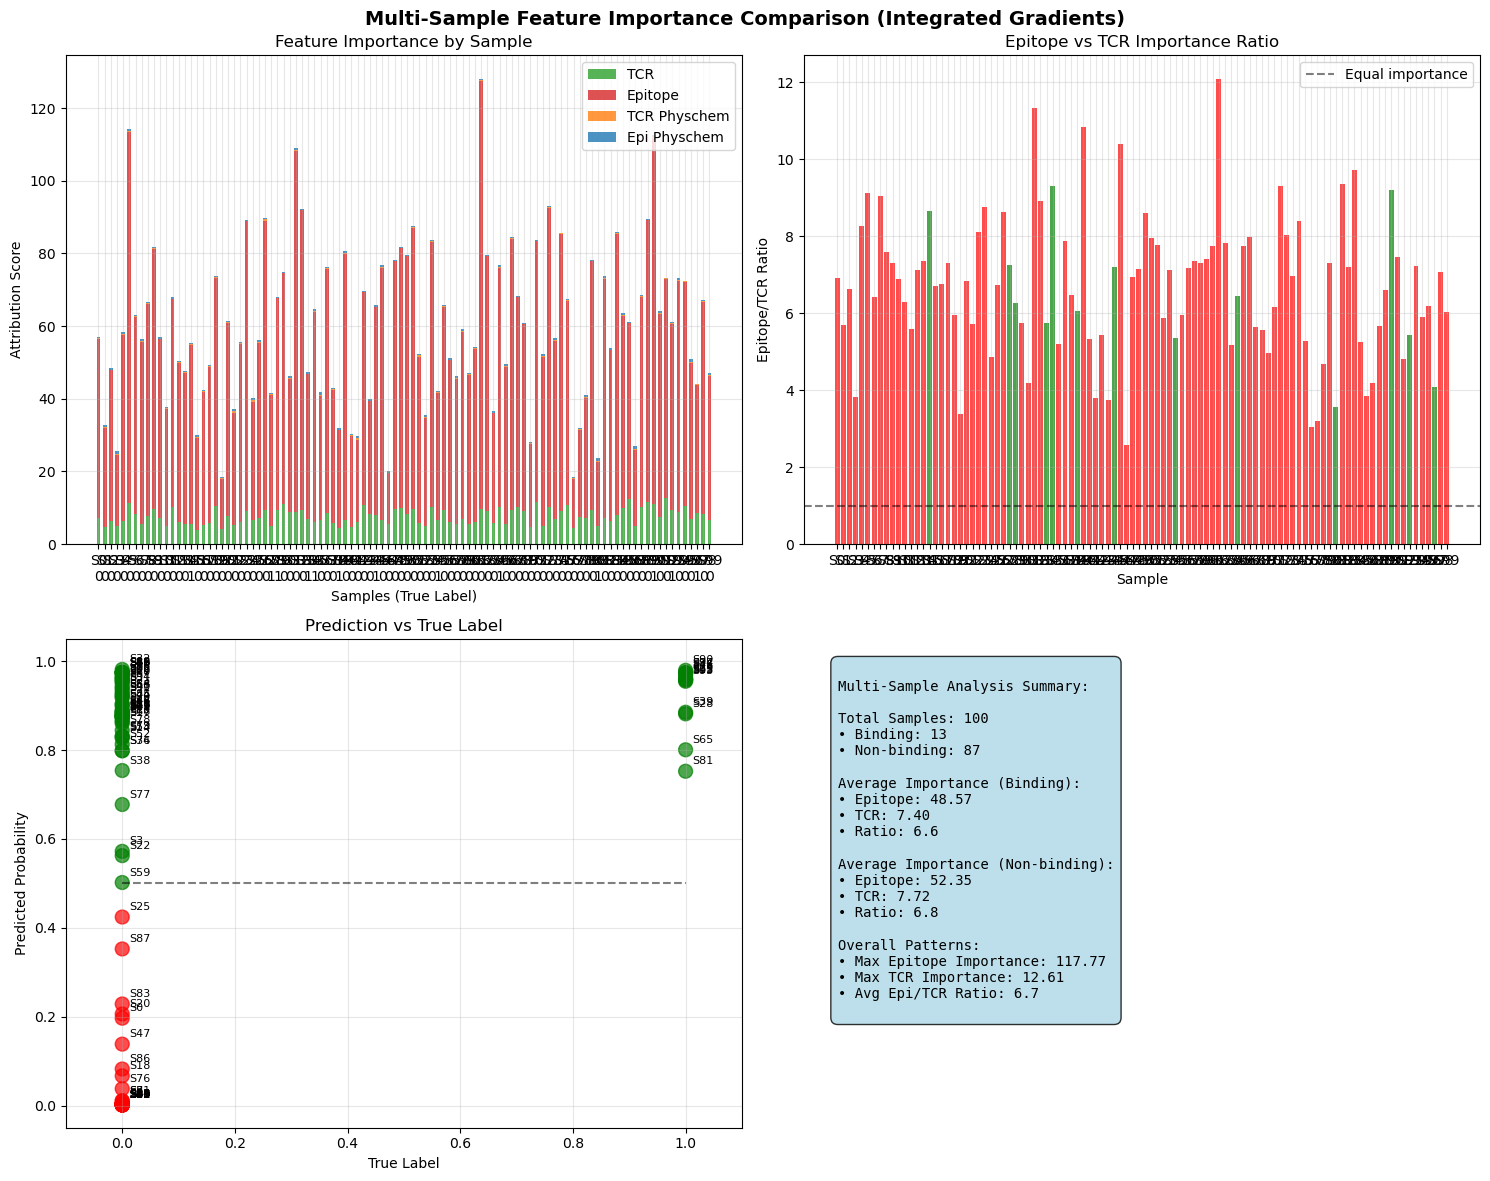

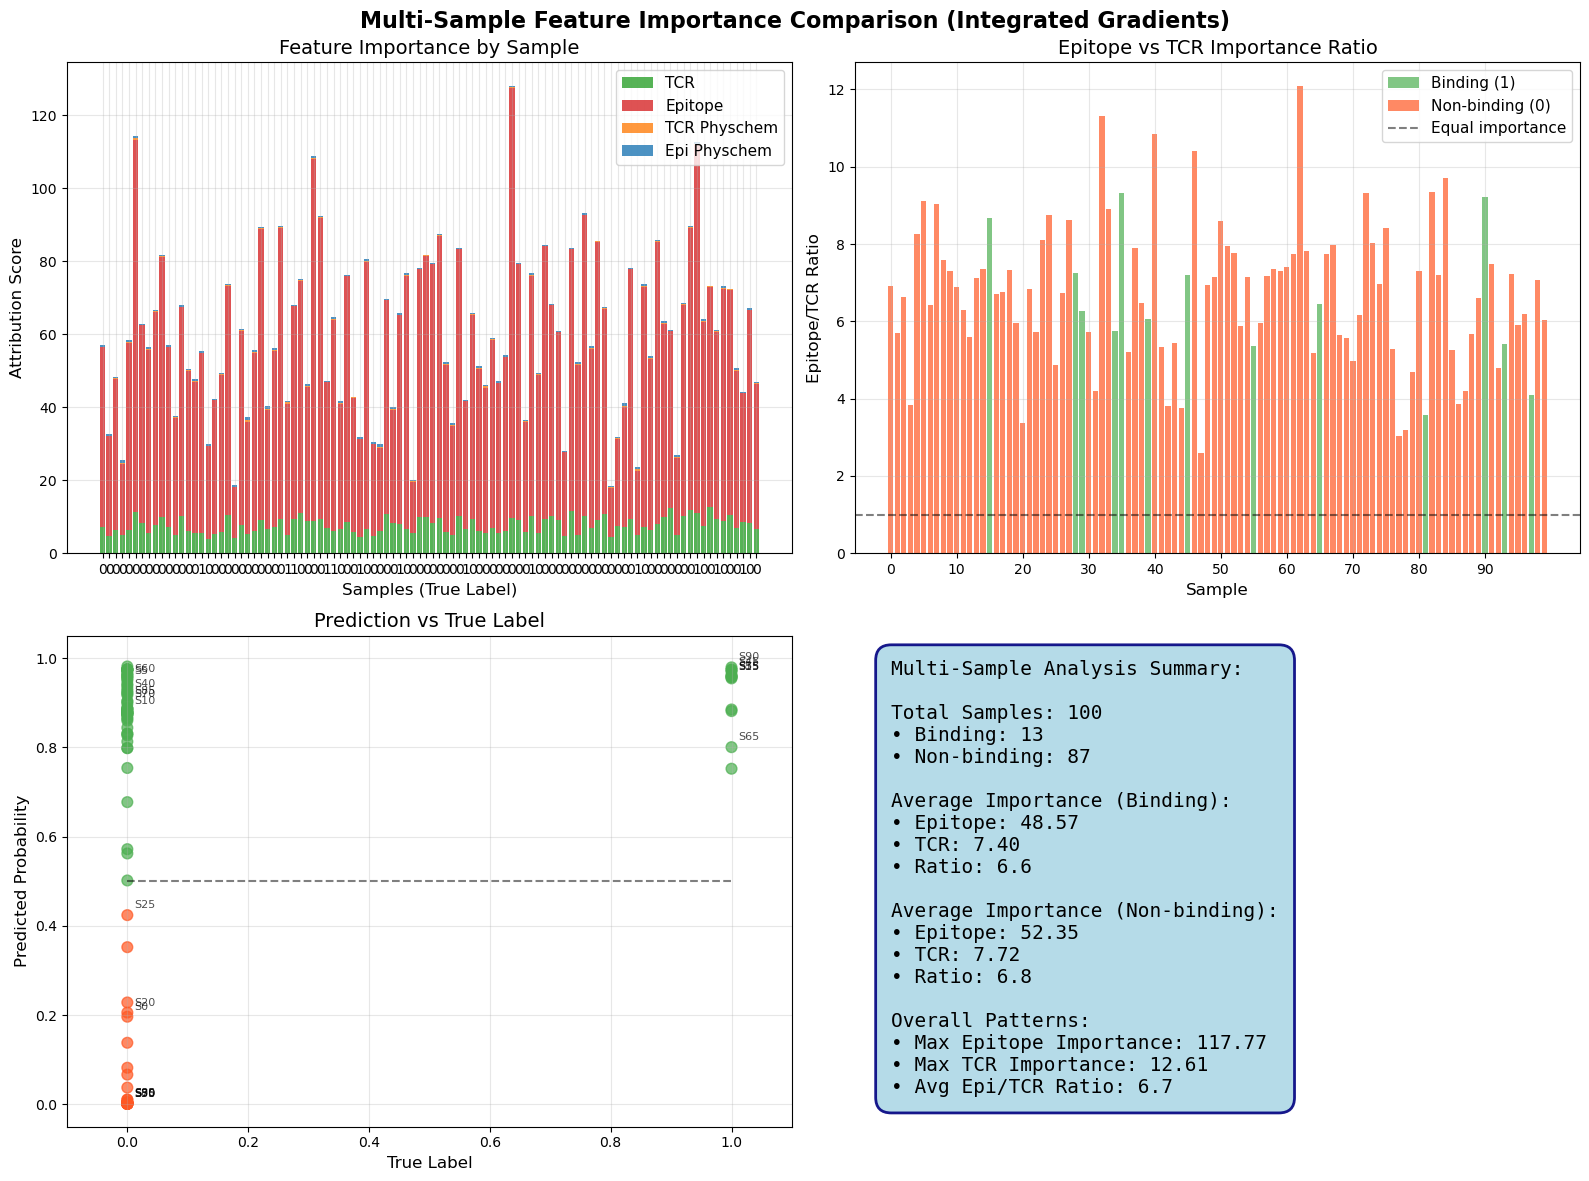

In [17]:
# If you need to rerun the analysis with the improved plotting
results = analyze_multiple_samples(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_indices=large_sample
)

# Then apply the improved visualization
fig = create_improved_comparison_visualization(results)

### Creating plots separately

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_stacked_feature_importance_plot(all_results, method='integrated_gradients'):
    """
    Create stacked bar chart of feature importance by sample
    """
    
    # Extract data for plotting
    tcr_scores = []
    epitope_scores = []
    tcr_phys_scores = []
    epi_phys_scores = []
    true_labels = []
    
    for result in all_results:
        info = result['sample_info']
        scores = result['importance_scores']
        
        tcr_scores.append(scores['TCR'])
        epitope_scores.append(scores['Epitope'])
        tcr_phys_scores.append(scores['TCR_physchem'])
        epi_phys_scores.append(scores['Epi_physchem'])
        true_labels.append(info['true_label'])
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    x = np.arange(len(true_labels))
    width = 0.8
    
    p1 = ax.bar(x, tcr_scores, width, label='TCR', color='#2ca02c', alpha=0.8)
    p2 = ax.bar(x, epitope_scores, width, bottom=tcr_scores, label='Epitope', color='#d62728', alpha=0.8)
    p3 = ax.bar(x, tcr_phys_scores, width, 
                bottom=np.array(tcr_scores) + np.array(epitope_scores), 
                label='TCR Physchem', color='#ff7f0e', alpha=0.8)
    p4 = ax.bar(x, epi_phys_scores, width,
                bottom=np.array(tcr_scores) + np.array(epitope_scores) + np.array(tcr_phys_scores),
                label='Epi Physchem', color='#1f77b4', alpha=0.8)
    
    ax.set_xlabel('Samples (True Label)', fontsize=12)
    ax.set_ylabel('Attribution Score', fontsize=12)
    ax.set_title(f'Feature Importance by Sample', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([str(label) for label in true_labels], fontsize=10)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_ratio_plot(all_results, method='integrated_gradients'):
    """
    Create epitope vs TCR importance ratio plot
    """
    
    # Extract data
    epitope_scores = []
    tcr_scores = []
    true_labels = []
    
    for result in all_results:
        info = result['sample_info']
        scores = result['importance_scores']
        
        epitope_scores.append(scores['Epitope'])
        tcr_scores.append(scores['TCR'])
        true_labels.append(info['true_label'])
    
    # Calculate ratios
    ratios = np.array(epitope_scores) / (np.array(tcr_scores) + 1e-8)
    colors = ['#4CAF50' if label == 1 else '#FF5722' for label in true_labels]
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    bars = ax.bar(range(len(ratios)), ratios, color=colors, alpha=0.7)
    ax.set_xlabel('Sample', fontsize=12)
    ax.set_ylabel('Epitope/TCR Ratio', fontsize=12)
    ax.set_title('Epitope vs TCR Importance Ratio', fontsize=14, fontweight='bold')
    ax.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Equal importance')
    ax.set_xticks(range(0, len(ratios), max(1, len(ratios)//10)))
    ax.grid(True, alpha=0.3)
    
    # Add color legend for binding status
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#4CAF50', alpha=0.7, label='Binding (1)'),
                      Patch(facecolor='#FF5722', alpha=0.7, label='Non-binding (0)'),
                      plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.5, label='Equal importance')]
    ax.legend(handles=legend_elements, fontsize=11, loc='upper right')
    
    plt.tight_layout()
    return fig

def create_prediction_scatter_plot(all_results):
    """
    Create prediction vs true label scatter plot
    """
    
    # Extract data
    predictions = []
    true_labels = []
    sample_indices = []
    
    for i, result in enumerate(all_results):
        info = result['sample_info']
        predictions.append(info['predicted_prob'])
        true_labels.append(info['true_label'])
        sample_indices.append(i)
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Use consistent colors with ratio plot
    scatter_colors = ['#4CAF50' if pred > 0.5 else '#FF5722' for pred in predictions]
    scatter = ax.scatter(true_labels, predictions, c=scatter_colors, alpha=0.7, s=60)
    
    ax.plot([0, 1], [0.5, 0.5], 'k--', alpha=0.5, label='Decision boundary')
    ax.set_xlabel('True Label', fontsize=12)
    ax.set_ylabel('Predicted Probability', fontsize=12)
    ax.set_title('Prediction vs True Label', fontsize=14, fontweight='bold')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)
    
    # Add sample labels to points (reduced frequency for readability)
    for i in range(0, len(true_labels), max(1, len(true_labels)//20)):
        ax.annotate(f'S{i}', (true_labels[i], predictions[i]), xytext=(5, 5), 
                   textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    return fig

def create_summary_plot(all_results):
    """
    Create summary statistics plot
    """
    
    # Extract data
    epitope_scores = []
    tcr_scores = []
    true_labels = []
    predictions = []
    
    for result in all_results:
        info = result['sample_info']
        scores = result['importance_scores']
        
        epitope_scores.append(scores['Epitope'])
        tcr_scores.append(scores['TCR'])
        true_labels.append(info['true_label'])
        predictions.append(info['predicted_prob'])
    
    # Calculate summary stats
    binding_samples = [i for i, label in enumerate(true_labels) if label == 1]
    non_binding_samples = [i for i, label in enumerate(true_labels) if label == 0]
    
    if binding_samples:
        binding_epitope_importance = np.mean([epitope_scores[i] for i in binding_samples])
        binding_tcr_importance = np.mean([tcr_scores[i] for i in binding_samples])
        binding_ratio = binding_epitope_importance / (binding_tcr_importance + 1e-8)
    else:
        binding_epitope_importance = binding_tcr_importance = binding_ratio = 0
        
    if non_binding_samples:
        non_binding_epitope_importance = np.mean([epitope_scores[i] for i in non_binding_samples])
        non_binding_tcr_importance = np.mean([tcr_scores[i] for i in non_binding_samples])
        non_binding_ratio = non_binding_epitope_importance / (non_binding_tcr_importance + 1e-8)
    else:
        non_binding_epitope_importance = non_binding_tcr_importance = non_binding_ratio = 0
    
    ratios = np.array(epitope_scores) / (np.array(tcr_scores) + 1e-8)
    
    # Create plot with text summary
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.axis('off')
    
    summary_text = f"""Multi-Sample Analysis Summary:

Total Samples: {len(all_results)}
• Binding: {len(binding_samples)}
• Non-binding: {len(non_binding_samples)}

Average Importance (Binding):
• Epitope: {binding_epitope_importance:.2f}
• TCR: {binding_tcr_importance:.2f}
• Ratio: {binding_ratio:.1f}

Average Importance (Non-binding):
• Epitope: {non_binding_epitope_importance:.2f}
• TCR: {non_binding_tcr_importance:.2f}
• Ratio: {non_binding_ratio:.1f}

Overall Patterns:
• Max Epitope Importance: {max(epitope_scores):.2f}
• Max TCR Importance: {max(tcr_scores):.2f}
• Avg Epi/TCR Ratio: {np.mean(ratios):.1f}"""
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=1.0', facecolor='lightblue', alpha=0.9, 
                     edgecolor='navy', linewidth=2))
    
    ax.set_title('Multi-Sample Analysis Summary', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Convenience functions to create all plots
def create_all_separate_plots(all_results, method='integrated_gradients', save_plots=False, save_dir='./'):
    """
    Create all four plots separately
    
    Args:
        all_results: List of results from multi-sample analysis
        method: Attribution method name for titles
        save_plots: Whether to save plots to files
        save_dir: Directory to save plots
    
    Returns:
        Dictionary containing all figure objects
    """
    
    plots = {}
    
    print("Creating separate multi-sample plots...")
    
    # 1. Stacked feature importance
    print("  - Creating stacked feature importance plot...")
    plots['stacked'] = create_stacked_feature_importance_plot(all_results, method)
    if save_plots:
        plots['stacked'].savefig(f"{save_dir}/feature_importance_stacked.png", dpi=300, bbox_inches='tight')
    
    # 2. Ratio plot
    print("  - Creating ratio plot...")
    plots['ratio'] = create_ratio_plot(all_results, method)
    if save_plots:
        plots['ratio'].savefig(f"{save_dir}/epitope_tcr_ratio.png", dpi=300, bbox_inches='tight')
    
    # 3. Prediction scatter
    print("  - Creating prediction scatter plot...")
    plots['scatter'] = create_prediction_scatter_plot(all_results)
    if save_plots:
        plots['scatter'].savefig(f"{save_dir}/prediction_scatter.png", dpi=300, bbox_inches='tight')
    
    # 4. Summary
    print("  - Creating summary plot...")
    plots['summary'] = create_summary_plot(all_results)
    if save_plots:
        plots['summary'].savefig(f"{save_dir}/analysis_summary.png", dpi=300, bbox_inches='tight')
    
    # Show all plots
    for plot_name, fig in plots.items():
        plt.show()
    
    print("✅ All plots created successfully!")
    return plots

# Individual plot creation functions
def plot_stacked_only(all_results, method='integrated_gradients'):
    """Create only the stacked feature importance plot"""
    return create_stacked_feature_importance_plot(all_results, method)

def plot_ratio_only(all_results, method='integrated_gradients'):
    """Create only the ratio plot"""
    return create_ratio_plot(all_results, method)

def plot_scatter_only(all_results):
    """Create only the scatter plot"""
    return create_prediction_scatter_plot(all_results)

def plot_summary_only(all_results):
    """Create only the summary plot"""
    return create_summary_plot(all_results)

print("""
Usage Examples:

# Create all plots separately:
plots = create_all_separate_plots(your_results, method='integrated_gradients')

# Create individual plots:
fig1 = plot_stacked_only(your_results)
fig2 = plot_ratio_only(your_results)
fig3 = plot_scatter_only(your_results)
fig4 = plot_summary_only(your_results)

# Save plots automatically:
plots = create_all_separate_plots(your_results, save_plots=True, save_dir='./plots/')

# Access individual plots:
stacked_fig = plots['stacked']
ratio_fig = plots['ratio']
scatter_fig = plots['scatter']
summary_fig = plots['summary']
""")


Usage Examples:

# Create all plots separately:
plots = create_all_separate_plots(your_results, method='integrated_gradients')

# Create individual plots:
fig1 = plot_stacked_only(your_results)
fig2 = plot_ratio_only(your_results)
fig3 = plot_scatter_only(your_results)
fig4 = plot_summary_only(your_results)

# Save plots automatically:
plots = create_all_separate_plots(your_results, save_plots=True, save_dir='./plots/')

# Access individual plots:
stacked_fig = plots['stacked']
ratio_fig = plots['ratio']
scatter_fig = plots['scatter']
summary_fig = plots['summary']



Creating separate multi-sample plots...
  - Creating stacked feature importance plot...
  - Creating ratio plot...
  - Creating prediction scatter plot...
  - Creating summary plot...


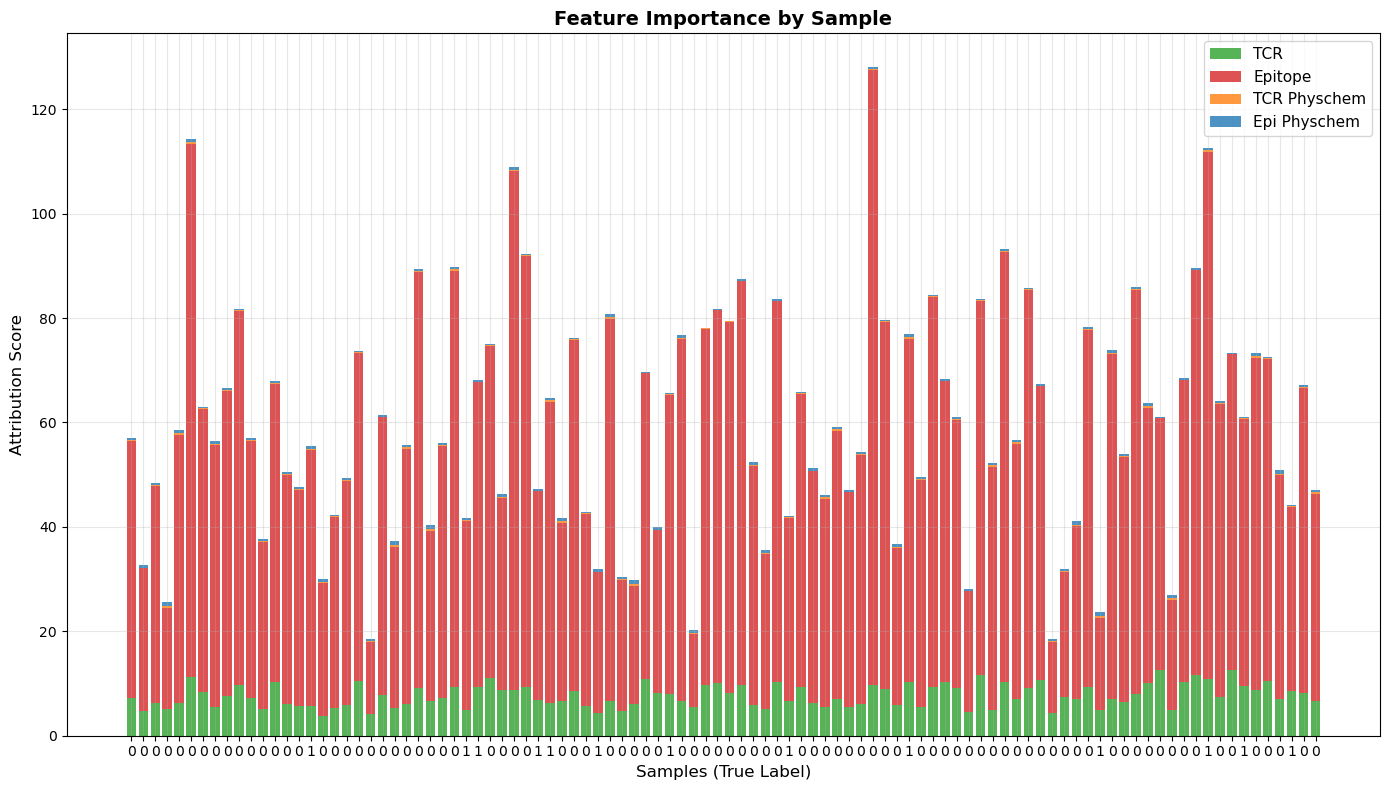

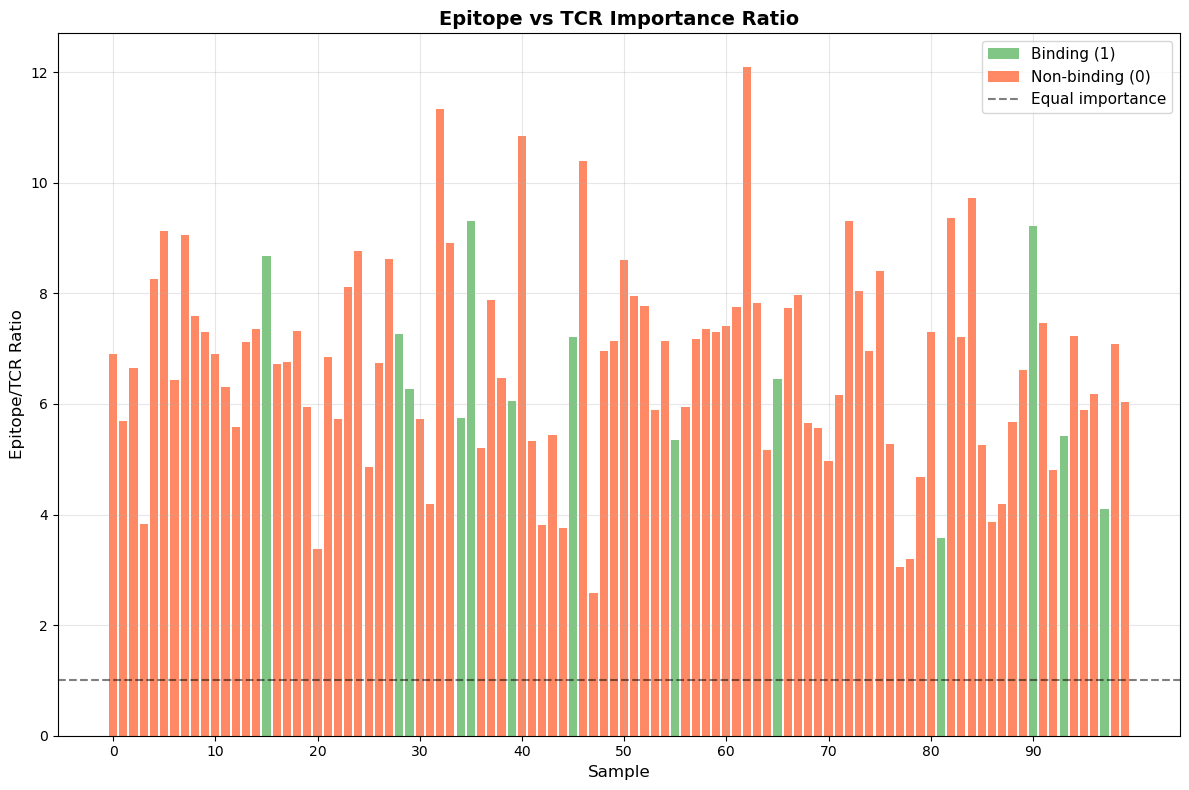

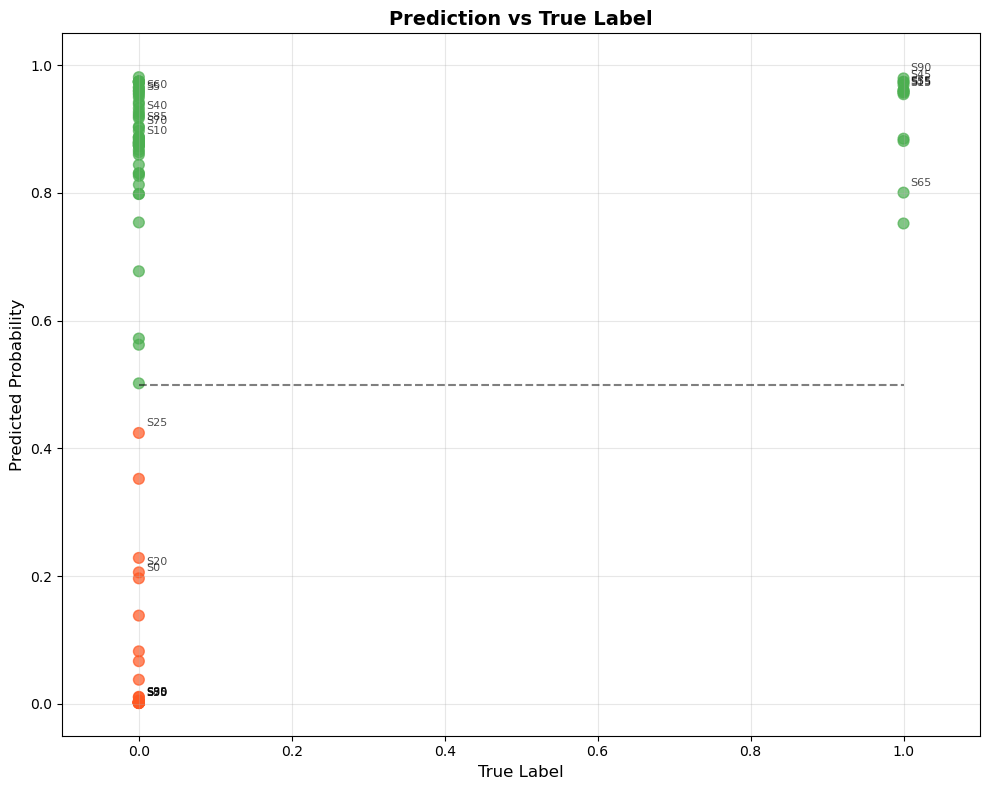

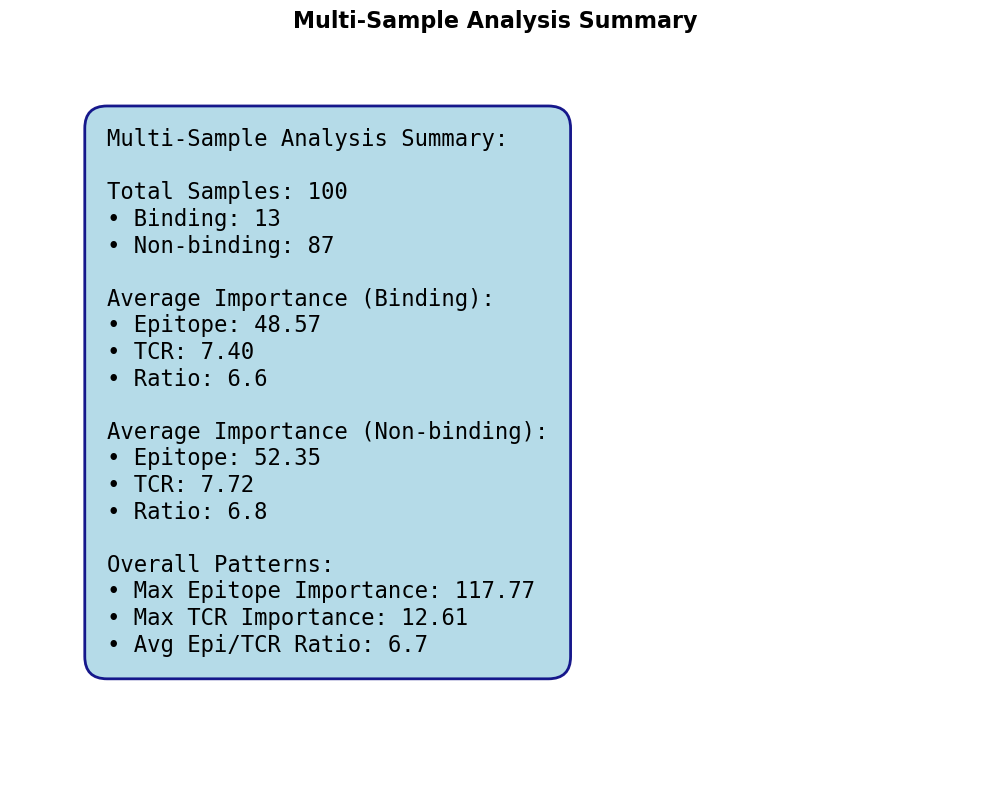

✅ All plots created successfully!


In [8]:
plots = create_all_separate_plots(large_results, method='integrated_gradients')


========================


Analyzing Sample 36486:
  TCR: CSAREELAGDADTQYF
  Epitope: KLGGALQAK
  True Label: 1
  Prediction: 0.9697
  MHC: HLA-A*03:01

Computing integrated_gradients...

Analyzing Sample 2674:
  TCR: CASSQGTSIGETQYF
  Epitope: ELAGIGILTV
  True Label: 1
  Prediction: 0.9746
  MHC: HLA-A*02

Computing integrated_gradients...

Analyzing Sample 5711:
  TCR: CASSPGQVGDQPQHF
  Epitope: KSKRTPMGF
  True Label: 1
  Prediction: 0.9440
  MHC: HLA-B*57:01

Computing integrated_gradients...

Analyzing Sample 1978:
  TCR: CASSQKDGGAYEQYF
  Epitope: HTQGYFPD
  True Label: 1
  Prediction: 0.6015
  MHC: HLA-B*57

Computing integrated_gradients...

Analyzing Sample 37739:
  TCR: CASSLESRGRETQYF
  Epitope: KLGGALQAK
  True Label: 1
  Prediction: 0.9666
  MHC: HLA-A*03:01

Computing integrated_gradients...

Analyzing Sample 36945:
  TCR: CASSTGGAWNEQFF
  Epitope: IVTDFSVIK
  True Label: 1
  Prediction: 0.8672
  MHC: HLA-A*11:01

Computing integrated_gradients...

Analyzing Sample 36504:
  TCR: CASTAVPNTEAFF
  E

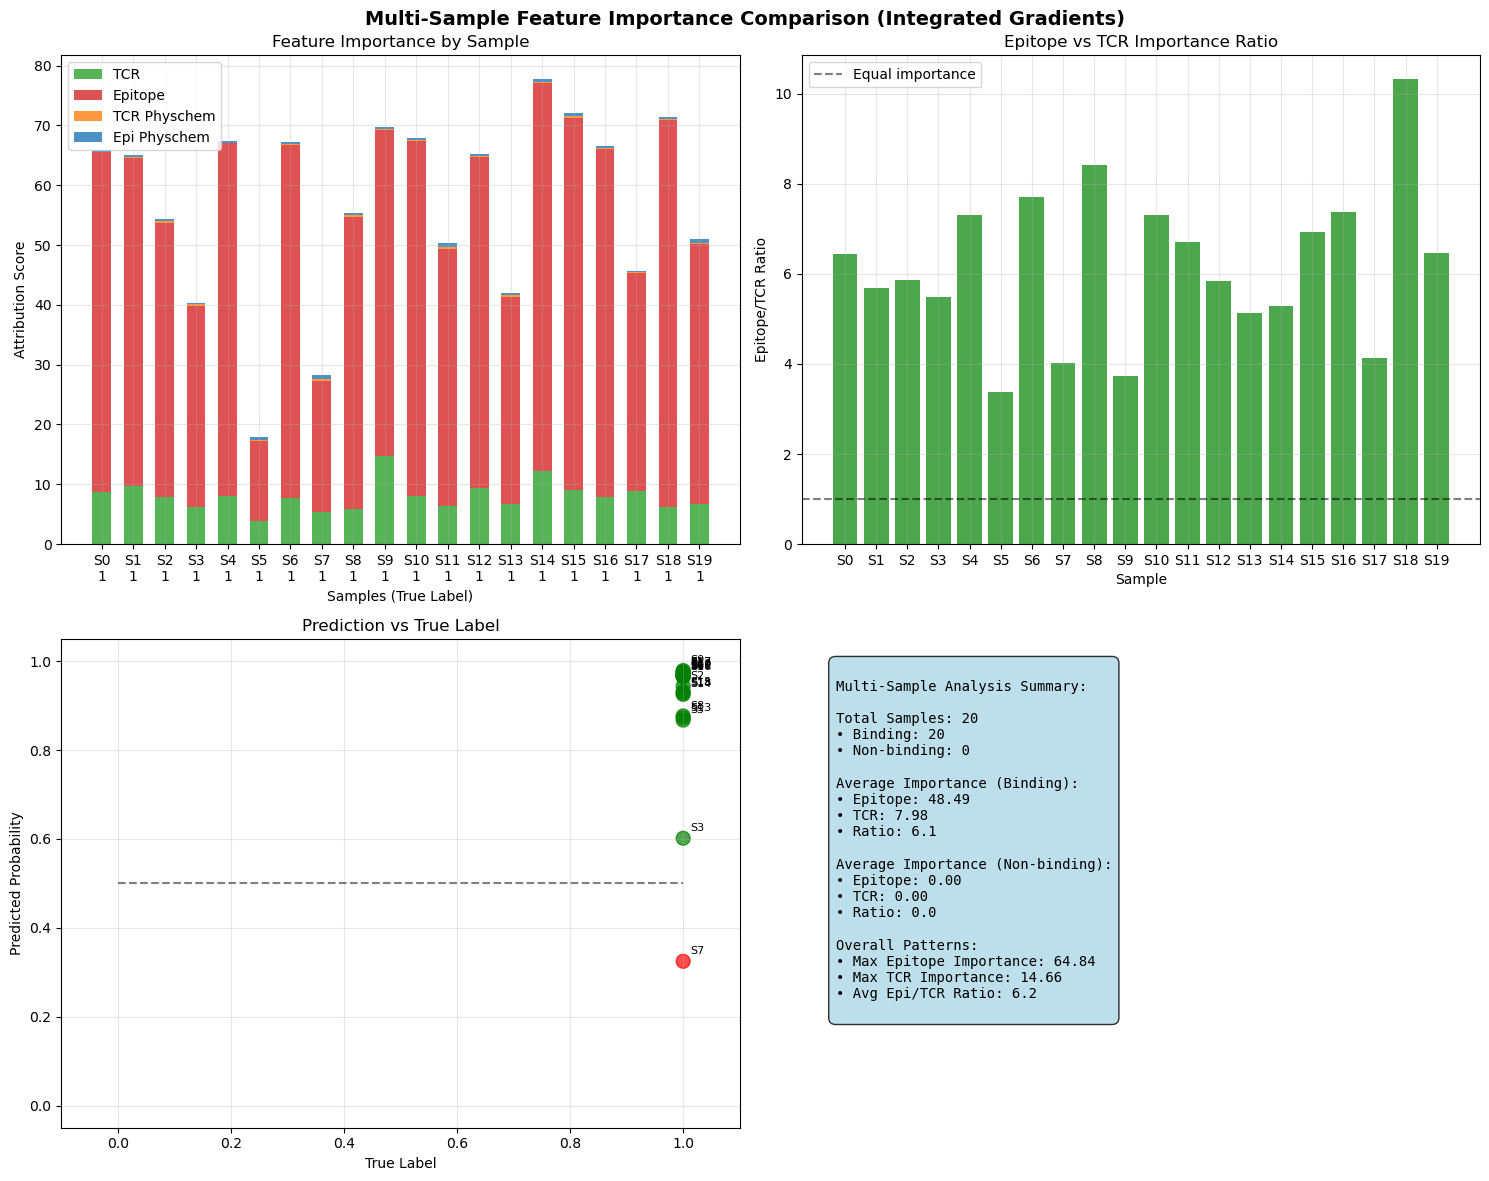


Analyzing Sample 40886:
  TCR: CASSQVTGTGYLTDTQYF
  Epitope: ALIAPVHAV
  True Label: 0
  Prediction: 0.0014
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 17452:
  TCR: CASSLEESGTSYEQYF
  Epitope: ELAGIGILTV
  True Label: 0
  Prediction: 0.9752
  MHC: HLA-A*02

Computing integrated_gradients...

Analyzing Sample 52020:
  TCR: CASSTGTGVYGYTF
  Epitope: CLLGTYTQDV
  True Label: 0
  Prediction: 0.0010
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 32729:
  TCR: CASSLGAGTADFGYTF
  Epitope: FLYALALLL
  True Label: 0
  Prediction: 0.9532
  MHC: HLA-A*02

Computing integrated_gradients...

Analyzing Sample 27457:
  TCR: CASSLGGGGVTEAFF
  Epitope: APRGPHGGAASGL
  True Label: 0
  Prediction: 0.7843
  MHC: HLA-B*07:02

Computing integrated_gradients...

Analyzing Sample 51865:
  TCR: CASSYGLTGSYNEQFF
  Epitope: NLVPMVATV
  True Label: 0
  Prediction: 0.8881
  MHC: HLA-A*02:01

Computing integrated_gradients...

Analyzing Sample 29955:
  TCR: CAI

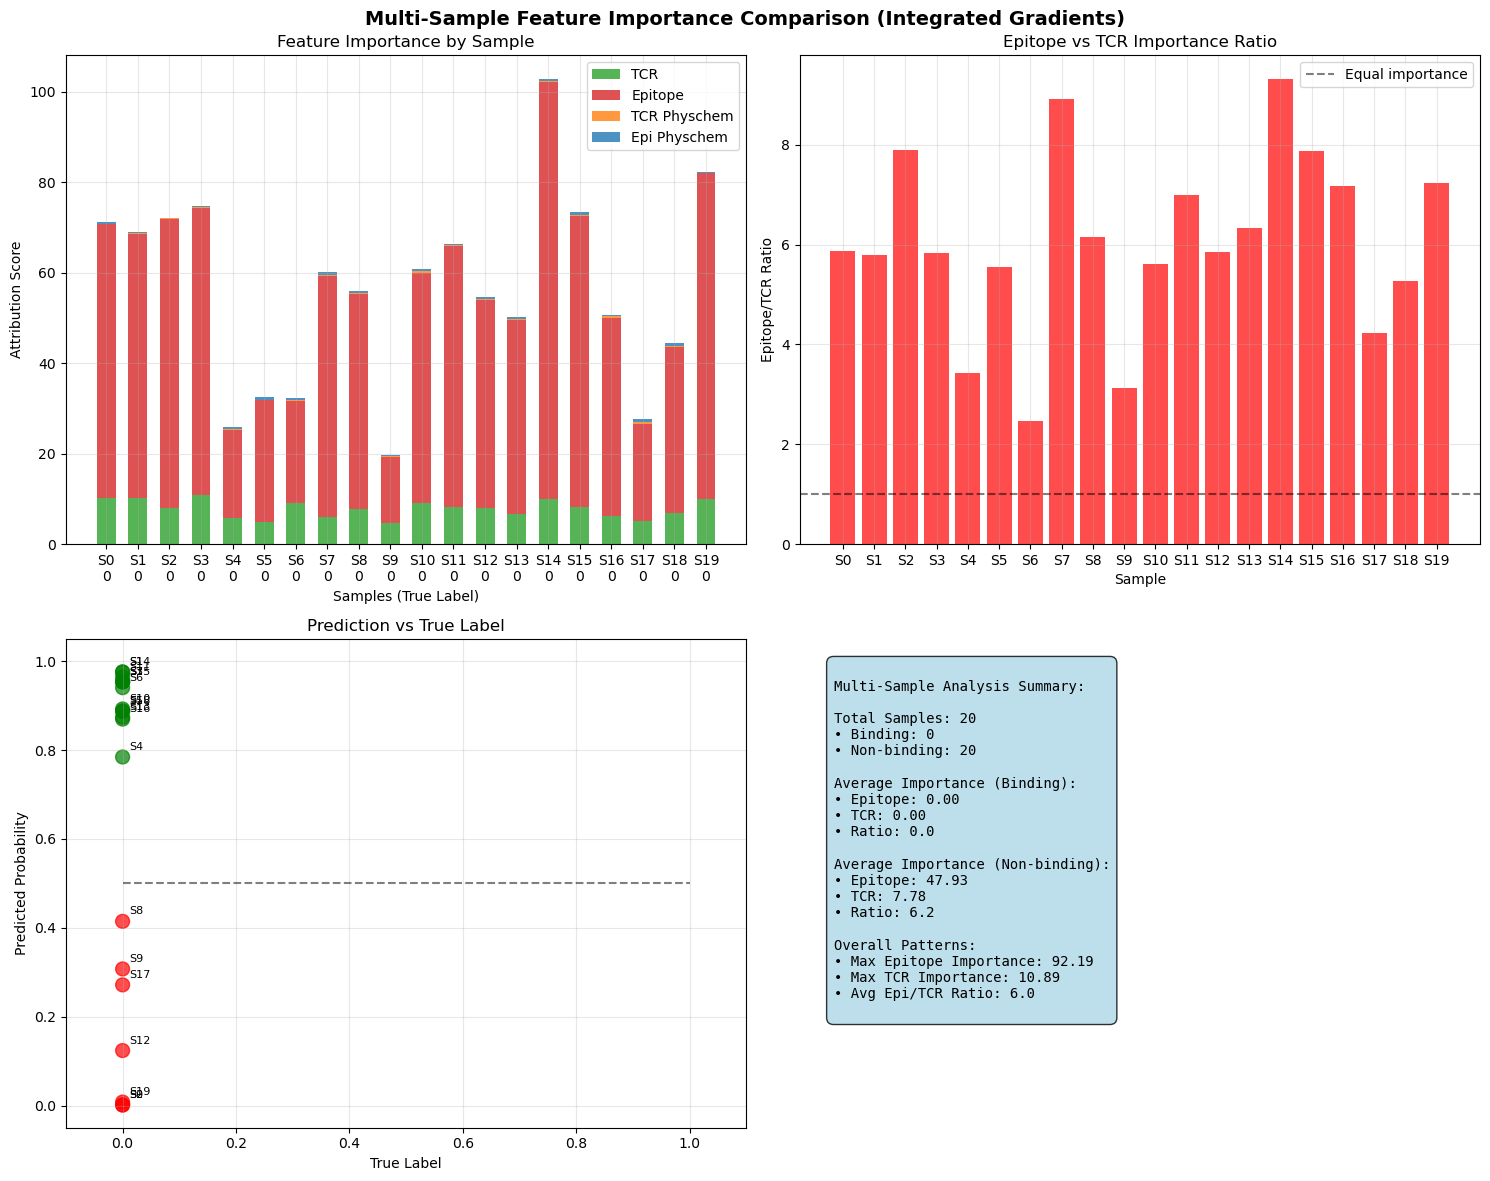

In [50]:
# Compare different groups
binding_analysis = analyze_multiple_samples(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file, sample_indices=binding_samples[:20])
non_binding_analysis = analyze_multiple_samples(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file, sample_indices=non_binding_samples[:20])

=====================================
### Analysis with CF
======================================

In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients, GradientShap, DeepLift, Occlusion
import warnings
warnings.filterwarnings('ignore')

class FullFeatureTCRAnalyzer:
    """
    Complete TCR-Epitope feature importance analyzer including categorical features
    """
    
    def __init__(self, model, device=None):
        self.model = model
        self.device = device or next(model.parameters()).device
        self.model.eval()
        
        # Create model wrapper that handles all features
        def full_model_wrapper(tcr, epitope, tcr_phys, epi_phys, trbv, trbj, mhc):
            # Handle categorical features that might become floats during interpolation
            if trbv.dtype in [torch.float32, torch.float64]:
                trbv = torch.round(trbv).long()
                trbv = torch.clamp(trbv, 0, self.model.trbv_embed.num_embeddings - 1)
            if trbj.dtype in [torch.float32, torch.float64]:
                trbj = torch.round(trbj).long()
                trbj = torch.clamp(trbj, 0, self.model.trbj_embed.num_embeddings - 1)
            if mhc.dtype in [torch.float32, torch.float64]:
                mhc = torch.round(mhc).long()
                mhc = torch.clamp(mhc, 0, self.model.mhc_embed.num_embeddings - 1)
            
            return self.model(tcr, epitope, tcr_phys, epi_phys, trbv, trbj, mhc)
        
        # Initialize attribution methods for full model
        self.ig = IntegratedGradients(full_model_wrapper)
        self.gs = GradientShap(full_model_wrapper)
        self.dl = DeepLift(full_model_wrapper)
        self.occlusion = Occlusion(full_model_wrapper)
        
        # Set allow_unused for gradient computation
        self.ig.gradient_func = lambda *args, **kwargs: self._compute_gradients_safe(*args, **kwargs)
        self.gs.gradient_func = lambda *args, **kwargs: self._compute_gradients_safe(*args, **kwargs)
        self.dl.gradient_func = lambda *args, **kwargs: self._compute_gradients_safe(*args, **kwargs)
    
    def _compute_gradients_safe(self, forward_fn, inputs, target_ind=None, additional_forward_args=None):
        """Safe gradient computation with allow_unused=True"""
        from captum._utils.gradient import compute_gradients
        import torch
        
        with torch.autograd.set_grad_enabled(True):
            outputs = forward_fn(*inputs) if additional_forward_args is None else forward_fn(*inputs, *additional_forward_args)
            
            if target_ind is not None:
                outputs = outputs[target_ind]
            
            if isinstance(outputs, torch.Tensor):
                outputs = [outputs]
            
            # Compute gradients with allow_unused=True
            grads = torch.autograd.grad(
                outputs=outputs, 
                inputs=inputs, 
                grad_outputs=[torch.ones_like(output) for output in outputs],
                allow_unused=True,
                retain_graph=False
            )
            
            # Replace None gradients with zero tensors
            safe_grads = []
            for grad, inp in zip(grads, inputs):
                if grad is None:
                    safe_grads.append(torch.zeros_like(inp))
                else:
                    safe_grads.append(grad)
            
            return tuple(safe_grads)
    
    def extract_sample_data(self, test_data, tcr_embeddings, epitope_embeddings, physchem_file, sample_idx):
        """Extract and prepare data for a single sample"""
        sample_row = test_data.iloc[sample_idx]
        
        # Extract identifiers and labels
        tcr_id = sample_row["TRB_CDR3"]
        epitope_id = sample_row["Epitope"]
        phys_idx = sample_row["physchem_index"]
        
        # Extract embeddings and features
        tcr_embedding = tcr_embeddings[tcr_id][:]
        epitope_embedding = epitope_embeddings[epitope_id][:]
        tcr_physchem = physchem_file["tcr_encoded"][phys_idx]
        epi_physchem = physchem_file["epi_encoded"][phys_idx]
        
        # Convert to tensors with batch dimension
        sample_tensors = {
            'tcr': torch.tensor(tcr_embedding, dtype=torch.float32).unsqueeze(0).to(self.device),
            'epitope': torch.tensor(epitope_embedding, dtype=torch.float32).unsqueeze(0).to(self.device),
            'tcr_physchem': torch.tensor(tcr_physchem, dtype=torch.float32).unsqueeze(0).to(self.device),
            'epi_physchem': torch.tensor(epi_physchem, dtype=torch.float32).unsqueeze(0).to(self.device),
            'trbv': torch.tensor([sample_row["TRBV_Index"]], dtype=torch.long).to(self.device),
            'trbj': torch.tensor([sample_row["TRBJ_Index"]], dtype=torch.long).to(self.device),
            'mhc': torch.tensor([sample_row["MHC_Index"]], dtype=torch.long).to(self.device)
        }
        
        # Sample metadata
        sample_info = {
            'tcr_sequence': tcr_id,
            'epitope_sequence': epitope_id,
            'true_label': sample_row["Binding"],
            'trbv': sample_row["TRBV"],
            'trbj': sample_row["TRBJ"],
            'mhc': sample_row["MHC"],
            'trbv_index': sample_row["TRBV_Index"],
            'trbj_index': sample_row["TRBJ_Index"],
            'mhc_index': sample_row["MHC_Index"],
            'task': sample_row.get("task", "unknown"),
            'sample_idx': sample_idx
        }
        
        return sample_tensors, sample_info
    
    def get_model_prediction(self, sample_tensors):
        """Get model prediction for a sample"""
        with torch.no_grad():
            output = self.model(
                sample_tensors['tcr'], sample_tensors['epitope'],
                sample_tensors['tcr_physchem'], sample_tensors['epi_physchem'],
                sample_tensors['trbv'], sample_tensors['trbj'], sample_tensors['mhc']
            )
            return torch.sigmoid(output).item()
    
    def compute_full_attributions(self, sample_tensors, method='integrated_gradients', n_steps=50):
        """Compute feature attributions for ALL features including categorical"""
        
        try:
            # First try the full approach
            return self._compute_full_attributions_advanced(sample_tensors, method, n_steps)
        except Exception as e:
            print(f"Advanced attribution failed: {str(e)}")
            print("Falling back to hybrid approach...")
            return self._compute_hybrid_attributions(sample_tensors, method, n_steps)
    
    def _compute_full_attributions_advanced(self, sample_tensors, method='integrated_gradients', n_steps=50):
        """Advanced method - compute attributions for all features"""
        
        # Prepare all inputs and enable gradients
        inputs = []
        baselines = []
        
        # Continuous features
        for key in ['tcr', 'epitope', 'tcr_physchem', 'epi_physchem']:
            inp = sample_tensors[key].clone().requires_grad_(True)
            baseline = torch.zeros_like(inp)
            inputs.append(inp)
            baselines.append(baseline)
        
        # Categorical features - convert to float for gradient computation
        for key in ['trbv', 'trbj', 'mhc']:
            inp = sample_tensors[key].clone().float().requires_grad_(True)
            baseline = torch.zeros_like(inp)  # Use 0 as baseline (valid index)
            inputs.append(inp)
            baselines.append(baseline)
        
        inputs = tuple(inputs)
        baselines = tuple(baselines)
        
        # Compute attributions based on method
        if method == 'integrated_gradients':
            attributions = self.ig.attribute(inputs, baselines=baselines, n_steps=n_steps)
        elif method == 'gradient_shap':
            attributions = self.gs.attribute(inputs, baselines=baselines, n_samples=50)
        elif method == 'deeplift':
            attributions = self.dl.attribute(inputs, baselines=baselines)
        else:
            raise ValueError(f"Unknown method: {method}")
        
        return attributions
    
    def _compute_hybrid_attributions(self, sample_tensors, method='integrated_gradients', n_steps=50):
        """Hybrid method - continuous features via gradients, categorical via perturbation"""
        
        print("Using hybrid approach: gradients for continuous, perturbation for categorical")
        
        # Create continuous-only model wrapper
        def continuous_model_wrapper(tcr, epitope, tcr_phys, epi_phys):
            # Use original categorical values
            return self.model(
                tcr, epitope, tcr_phys, epi_phys,
                sample_tensors['trbv'], sample_tensors['trbj'], sample_tensors['mhc']
            )
        
        # Initialize IG for continuous features
        continuous_ig = IntegratedGradients(continuous_model_wrapper)
        
        # Prepare continuous inputs
        continuous_inputs = []
        continuous_baselines = []
        
        for key in ['tcr', 'epitope', 'tcr_physchem', 'epi_physchem']:
            inp = sample_tensors[key].clone().requires_grad_(True)
            baseline = torch.zeros_like(inp)
            continuous_inputs.append(inp)
            continuous_baselines.append(baseline)
        
        continuous_inputs = tuple(continuous_inputs)
        continuous_baselines = tuple(continuous_baselines)
        
        # Compute continuous attributions
        if method == 'integrated_gradients':
            continuous_attributions = continuous_ig.attribute(
                continuous_inputs, baselines=continuous_baselines, n_steps=n_steps
            )
        else:
            # Fallback to IG for other methods
            continuous_attributions = continuous_ig.attribute(
                continuous_inputs, baselines=continuous_baselines, n_steps=n_steps
            )
        
        # Compute categorical attributions via perturbation
        categorical_attributions = []
        
        for feature_name, tensor_key in [('TRBV', 'trbv'), ('TRBJ', 'trbj'), ('MHC', 'mhc')]:
            original_prediction = self.get_model_prediction(sample_tensors)
            
            # Test with baseline value (0)
            modified_tensors = sample_tensors.copy()
            modified_tensors[tensor_key] = torch.tensor([0], dtype=torch.long, device=self.device)
            baseline_prediction = self.get_model_prediction(modified_tensors)
            
            # Attribution is the difference
            attribution_value = original_prediction - baseline_prediction
            
            # Create attribution tensor with same shape as input
            attr_tensor = torch.tensor([[attribution_value]], dtype=torch.float32, device=self.device)
            categorical_attributions.append(attr_tensor)
        
        # Combine all attributions
        all_attributions = list(continuous_attributions) + categorical_attributions
        
        return tuple(all_attributions)
    
    def analyze_categorical_importance(self, sample_tensors, sample_info, method='occlusion'):
        """
        Special analysis for categorical features using occlusion/perturbation
        """
        print(f"\nAnalyzing categorical features using {method}...")
        
        categorical_importance = {}
        
        # Test each categorical feature by replacing with different values
        for feature_name, tensor_key in [('TRBV', 'trbv'), ('TRBJ', 'trbj'), ('MHC', 'mhc')]:
            original_value = sample_tensors[tensor_key].item()
            original_prediction = self.get_model_prediction(sample_tensors)
            
            # Get embedding vocabulary size
            if feature_name == 'TRBV':
                vocab_size = self.model.trbv_embed.num_embeddings
            elif feature_name == 'TRBJ':
                vocab_size = self.model.trbj_embed.num_embeddings
            else:  # MHC
                vocab_size = self.model.mhc_embed.num_embeddings
            
            # Test with different values (sample a subset for efficiency)
            test_values = [0, 1, 2, vocab_size//4, vocab_size//2, vocab_size-2]
            test_values = [v for v in test_values if v < vocab_size and v != original_value]
            
            prediction_changes = []
            
            for test_value in test_values[:5]:  # Limit to 5 tests for efficiency
                # Create modified sample
                modified_tensors = sample_tensors.copy()
                modified_tensors[tensor_key] = torch.tensor([test_value], dtype=torch.long, device=self.device)
                
                # Get prediction with modified value
                modified_prediction = self.get_model_prediction(modified_tensors)
                change = abs(modified_prediction - original_prediction)
                prediction_changes.append(change)
            
            # Average change represents importance
            avg_change = np.mean(prediction_changes) if prediction_changes else 0
            categorical_importance[feature_name] = avg_change
            
            print(f"{feature_name}: {sample_info[feature_name.lower()]} (idx: {original_value}) -> "
                  f"Avg change: {avg_change:.4f}")
        
        return categorical_importance
    
    def analyze_sample_complete(self, test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                               sample_idx, methods=['integrated_gradients'], include_categorical=True):
        """Complete analysis of a single sample including categorical features"""
        
        # Extract sample data
        sample_tensors, sample_info = self.extract_sample_data(
            test_data, tcr_embeddings, epitope_embeddings, physchem_file, sample_idx
        )
        
        # Get prediction
        prediction = self.get_model_prediction(sample_tensors)
        sample_info['predicted_prob'] = prediction
        
        print(f"Analyzing Sample {sample_idx} (Complete Feature Analysis):")
        print(f"  TCR: {sample_info['tcr_sequence']}")
        print(f"  Epitope: {sample_info['epitope_sequence']}")
        print(f"  True Label: {sample_info['true_label']}")
        print(f"  Prediction: {prediction:.4f}")
        print(f"  TRBV: {sample_info['trbv']} (idx: {sample_info['trbv_index']})")
        print(f"  TRBJ: {sample_info['trbj']} (idx: {sample_info['trbj_index']})")
        print(f"  MHC: {sample_info['mhc']} (idx: {sample_info['mhc_index']})")
        
        results = {}
        
        for method in methods:
            print(f"\nComputing {method} for all features...")
            
            # Compute attributions for all features
            attributions = self.compute_full_attributions(sample_tensors, method=method)
            
            # Calculate importance scores for continuous features
            importance_scores = {
                'TCR': torch.abs(attributions[0]).sum().item(),
                'Epitope': torch.abs(attributions[1]).sum().item(),
                'TCR_physchem': torch.abs(attributions[2]).sum().item(),
                'Epi_physchem': torch.abs(attributions[3]).sum().item(),
                'TRBV': torch.abs(attributions[4]).sum().item(),
                'TRBJ': torch.abs(attributions[5]).sum().item(),
                'MHC': torch.abs(attributions[6]).sum().item()
            }
            
            # Store results
            results[method] = {
                'attributions': attributions,
                'importance_scores': importance_scores,
                'sample_info': sample_info
            }
        
        # Analyze categorical features with perturbation method
        if include_categorical:
            categorical_importance = self.analyze_categorical_importance(sample_tensors, sample_info)
            
            # Add categorical analysis to results
            for method in methods:
                results[method]['categorical_perturbation'] = categorical_importance
        
        return results
    
    def create_complete_visualization(self, all_results, sample_info):
        """Create comprehensive visualization including categorical features"""
        
        fig, axes = plt.subplots(3, 3, figsize=(20, 16))
        fig.suptitle(f'Complete TCR-Epitope Feature Importance Analysis\n'
                    f'TCR: {sample_info["tcr_sequence"]} | Epitope: {sample_info["epitope_sequence"]}\n'
                    f'True: {sample_info["true_label"]} | Pred: {sample_info["predicted_prob"]:.3f} | '
                    f'TRBV: {sample_info["trbv"]} | TRBJ: {sample_info["trbj"]} | MHC: {sample_info["mhc"]}', 
                    fontsize=14, fontweight='bold')
        
        methods = list(all_results.keys())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(methods)]
        
        # Use primary method for analysis
        primary_method = methods[0]
        scores = all_results[primary_method]['importance_scores']
        attributions = all_results[primary_method]['attributions']
        
        # 1. Complete feature importance (all 7 features)
        ax1 = axes[0, 0]
        feature_names = ['TCR', 'Epitope', 'TCR_phys', 'Epi_phys', 'TRBV', 'TRBJ', 'MHC']
        feature_scores = [scores[name] for name in ['TCR', 'Epitope', 'TCR_physchem', 'Epi_physchem', 'TRBV', 'TRBJ', 'MHC']]
        
        bars = ax1.bar(feature_names, feature_scores, color=['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4', '#9467bd', '#8c564b', '#e377c2'], alpha=0.7)
        ax1.set_ylabel('Attribution Score')
        ax1.set_title('Complete Feature Importance')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, score in zip(bars, feature_scores):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_scores)*0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=10)
        
        # 2. Feature groups (sequence, physchem, categorical)
        ax2 = axes[0, 1]
        sequence_score = scores['TCR'] + scores['Epitope']
        physchem_score = scores['TCR_physchem'] + scores['Epi_physchem']
        categorical_score = scores['TRBV'] + scores['TRBJ'] + scores['MHC']
        
        group_data = [sequence_score, physchem_score, categorical_score]
        group_labels = ['Sequence', 'Physicochemical', 'Categorical']
        group_colors = ['#ff9999', '#66b2ff', '#99ff99']
        
        wedges, texts, autotexts = ax2.pie(group_data, labels=group_labels, autopct='%1.1f%%',
                                          colors=group_colors, startangle=90)
        ax2.set_title('Feature Group Distribution')
        
        # 3. TCR vs Epitope detailed
        ax3 = axes[0, 2]
        tcr_epitope_data = [scores['TCR'], scores['Epitope']]
        tcr_epitope_labels = ['TCR', 'Epitope']
        tcr_epitope_colors = ['#2ca02c', '#d62728']
        
        bars = ax3.bar(tcr_epitope_labels, tcr_epitope_data, color=tcr_epitope_colors, alpha=0.7)
        ax3.set_ylabel('Attribution Score')
        ax3.set_title('TCR vs Epitope Importance')
        ax3.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, tcr_epitope_data):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tcr_epitope_data)*0.01,
                    f'{value:.2f}', ha='center', va='bottom')
        
        # 4. Categorical features detailed
        ax4 = axes[1, 0]
        cat_names = ['TRBV', 'TRBJ', 'MHC']
        cat_scores = [scores['TRBV'], scores['TRBJ'], scores['MHC']]
        cat_colors = ['#9467bd', '#8c564b', '#e377c2']
        
        bars = ax4.bar(cat_names, cat_scores, color=cat_colors, alpha=0.7)
        ax4.set_ylabel('Attribution Score')
        ax4.set_title('Categorical Feature Importance')
        ax4.grid(True, alpha=0.3)
        
        # Add categorical labels
        cat_labels = [f"{sample_info['trbv']}", f"{sample_info['trbj']}", f"{sample_info['mhc']}"]
        for bar, score, label in zip(bars, cat_scores, cat_labels):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(cat_scores)*0.01,
                    f'{score:.4f}', ha='center', va='bottom', fontsize=10)
            ax4.text(bar.get_x() + bar.get_width()/2, -max(cat_scores)*0.05,
                    label, ha='center', va='top', fontsize=9, rotation=45)
        
        # 5. TCR sequence positions
        ax5 = axes[1, 1]
        tcr_attr = attributions[0].squeeze(0).detach().cpu()
        tcr_pos_importance = torch.abs(tcr_attr).sum(dim=-1).numpy()
        
        positions = np.arange(len(tcr_pos_importance))
        ax5.plot(positions, tcr_pos_importance, 'o-', color='#2ca02c', linewidth=2, markersize=4)
        ax5.fill_between(positions, tcr_pos_importance, alpha=0.3, color='#2ca02c')
        ax5.set_xlabel('TCR Position')
        ax5.set_ylabel('Attribution Score')
        ax5.set_title('TCR Position Importance')
        ax5.grid(True, alpha=0.3)
        
        # Highlight top 3 positions
        top_positions = np.argsort(tcr_pos_importance)[-3:]
        for pos in top_positions:
            ax5.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
            ax5.text(pos, tcr_pos_importance[pos], f'{pos}', ha='center', va='bottom', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        # 6. Epitope sequence positions
        ax6 = axes[1, 2]
        epitope_attr = attributions[1].squeeze(0).detach().cpu()
        epitope_pos_importance = torch.abs(epitope_attr).sum(dim=-1).numpy()
        
        positions = np.arange(len(epitope_pos_importance))
        ax6.plot(positions, epitope_pos_importance, 'o-', color='#d62728', linewidth=2, markersize=4)
        ax6.fill_between(positions, epitope_pos_importance, alpha=0.3, color='#d62728')
        ax6.set_xlabel('Epitope Position')
        ax6.set_ylabel('Attribution Score')
        ax6.set_title('Epitope Position Importance')
        ax6.grid(True, alpha=0.3)
        
        # Highlight top 3 positions
        top_positions = np.argsort(epitope_pos_importance)[-3:]
        for pos in top_positions:
            ax6.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
            ax6.text(pos, epitope_pos_importance[pos], f'{pos}', ha='center', va='bottom', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        # 7. Physicochemical features comparison
        ax7 = axes[2, 0]
        phys_names = ['TCR_physchem', 'Epi_physchem']
        phys_scores = [scores['TCR_physchem'], scores['Epi_physchem']]
        phys_colors = ['#ff7f0e', '#1f77b4']
        
        bars = ax7.bar(phys_names, phys_scores, color=phys_colors, alpha=0.7)
        ax7.set_ylabel('Attribution Score')
        ax7.set_title('Physicochemical Feature Importance')
        ax7.grid(True, alpha=0.3)
        
        for bar, score in zip(bars, phys_scores):
            ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(phys_scores)*0.01,
                    f'{score:.4f}', ha='center', va='bottom')
        
        # 8. Perturbation analysis (if available)
        ax8 = axes[2, 1]
        if 'categorical_perturbation' in all_results[primary_method]:
            pert_scores = all_results[primary_method]['categorical_perturbation']
            pert_names = list(pert_scores.keys())
            pert_values = list(pert_scores.values())
            
            bars = ax8.bar(pert_names, pert_values, color=['#9467bd', '#8c564b', '#e377c2'], alpha=0.7)
            ax8.set_ylabel('Prediction Change')
            ax8.set_title('Categorical Feature Perturbation Effect')
            ax8.grid(True, alpha=0.3)
            
            for bar, value in zip(bars, pert_values):
                ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(pert_values)*0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontsize=10)
        else:
            ax8.text(0.5, 0.5, 'Perturbation analysis\nnot available', 
                    ha='center', va='center', transform=ax8.transAxes)
            ax8.set_title('Categorical Perturbation Analysis')
        
        # 9. Complete summary
        ax9 = axes[2, 2]
        ax9.axis('off')
        
        total_attribution = sum(scores.values())
        sequence_pct = (sequence_score / total_attribution) * 100 if total_attribution > 0 else 0
        physchem_pct = (physchem_score / total_attribution) * 100 if total_attribution > 0 else 0
        categorical_pct = (categorical_score / total_attribution) * 100 if total_attribution > 0 else 0
        
        # Handle division by zero for ratios
        epitope_tcr_ratio = scores['Epitope']/scores['TCR'] if scores['TCR'] > 0 else float('inf')
        sequence_context_ratio = sequence_score/categorical_score if categorical_score > 0 else float('inf')
        
        # Format ratios safely
        epitope_tcr_str = f"{epitope_tcr_ratio:.1f}x" if epitope_tcr_ratio != float('inf') else "∞x"
        sequence_context_str = f"{sequence_context_ratio:.1f}x" if sequence_context_ratio != float('inf') else "∞x"
        
        # Get top 3 features safely
        sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        top_features = []
        for i in range(min(3, len(sorted_features))):
            feature_name, feature_score = sorted_features[i]
            top_features.append(f"{i+1}. {feature_name}: {feature_score:.3f}")
        
        summary_text = f"""
Complete Feature Analysis Summary:

Sample Information:
• Sample ID: {sample_info['sample_idx']}
• Task: {sample_info['task']}
• Prediction Confidence: {abs(sample_info['predicted_prob'] - 0.5)*2:.1%}
• Correct: {'✓' if (sample_info['predicted_prob'] > 0.5) == sample_info['true_label'] else '✗'}

Feature Group Breakdown:
• Sequence: {sequence_pct:.1f}% ({sequence_score:.3f})
• Physicochemical: {physchem_pct:.1f}% ({physchem_score:.3f})
• Categorical: {categorical_pct:.1f}% ({categorical_score:.3f})

Individual Feature Ranking:
{chr(10).join(top_features)}

Ratios:
• Epitope/TCR: {epitope_tcr_str}
• Sequence/Context: {sequence_context_str}
        """
        
        ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        return fig

# Usage functions
def analyze_complete_sample(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                           sample_idx=0, methods=['integrated_gradients']):
    """Analyze a single sample with ALL features including categorical"""
    
    analyzer = FullFeatureTCRAnalyzer(model)
    results = analyzer.analyze_sample_complete(
        test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
        sample_idx, methods=methods, include_categorical=True
    )
    
    # Create comprehensive visualization
    sample_info = results[methods[0]]['sample_info']
    fig = analyzer.create_complete_visualization(results, sample_info)
    plt.show()
    
    return results

# Example usage
print("""
Complete TCR Feature Importance Analysis (Including Categorical Features)

SINGLE SAMPLE COMPLETE ANALYSIS:
results = analyze_complete_sample(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients']
)

This will analyze ALL 7 feature types:
1. TCR sequence embeddings
2. Epitope sequence embeddings  
3. TCR physicochemical properties
4. Epitope physicochemical properties
5. TRBV (categorical)
6. TRBJ (categorical)
7. MHC (categorical)
""")


Complete TCR Feature Importance Analysis (Including Categorical Features)

SINGLE SAMPLE COMPLETE ANALYSIS:
results = analyze_complete_sample(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients']
)

This will analyze ALL 7 feature types:
1. TCR sequence embeddings
2. Epitope sequence embeddings  
3. TCR physicochemical properties
4. Epitope physicochemical properties
5. TRBV (categorical)
6. TRBJ (categorical)
7. MHC (categorical)



Analyzing Sample 0 (Complete Feature Analysis):
  TCR: CASSPSQGMNTEAFF
  Epitope: RTLNAWVKV
  True Label: 0
  Prediction: 0.0048
  TRBV: TRBV5-1 (idx: 4)
  TRBJ: TRBJ1-1 (idx: 6)
  MHC: HLA-A*02:01 (idx: 0)

Computing integrated_gradients for all features...

Analyzing categorical features using occlusion...
TRBV: TRBV5-1 (idx: 4) -> Avg change: 0.0003
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1851
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0000


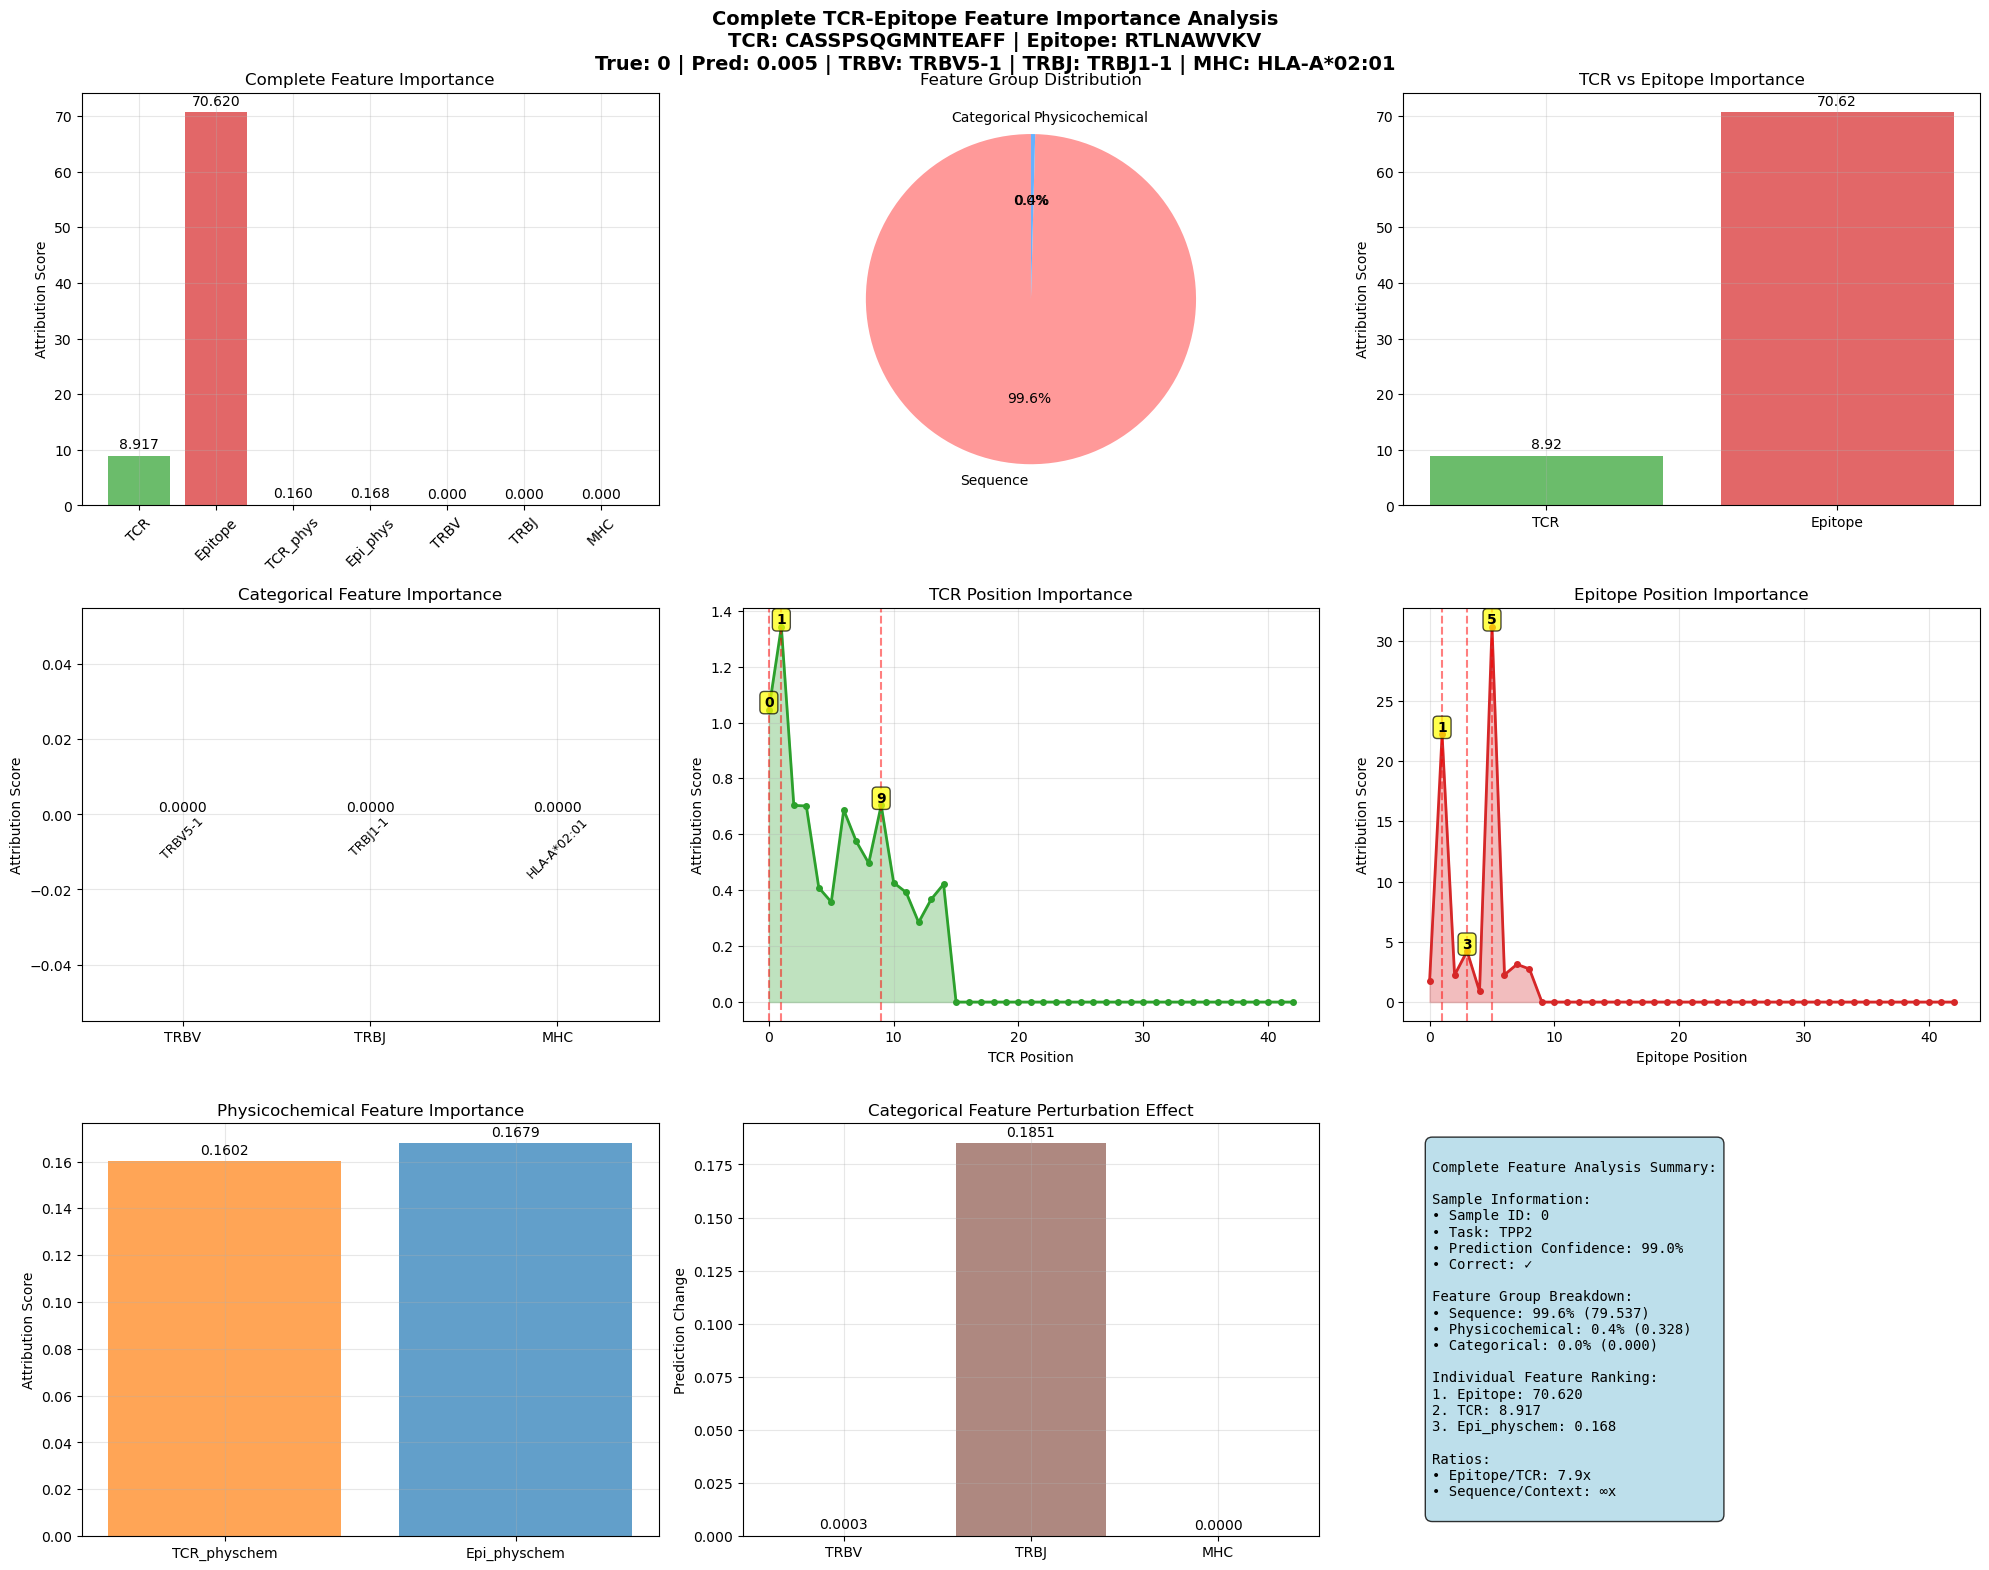

In [10]:
# Analyze a sample with ALL features
results = analyze_complete_sample(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients']
)

### Reducing the plot

In [18]:
def create_reduced_complete_visualization(all_results, sample_info):
    """Create reduced comprehensive visualization with 6 plots (3x2 grid)"""
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle(f'Complete TCR-Epitope Feature Importance Analysis\n'
                f'TCR: {sample_info["tcr_sequence"]} | Epitope: {sample_info["epitope_sequence"]}\n'
                f'True: {sample_info["true_label"]} | Pred: {sample_info["predicted_prob"]:.3f} | '
                f'TRBV: {sample_info["trbv"]} | TRBJ: {sample_info["trbj"]} | MHC: {sample_info["mhc"]}', 
                fontsize=14, fontweight='bold')
    
    methods = list(all_results.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(methods)]
    
    # Use primary method for analysis
    primary_method = methods[0]
    scores = all_results[primary_method]['importance_scores']
    attributions = all_results[primary_method]['attributions']
    
    # ROW 1: TCR and Epitope Position Importance
    
    # 1. TCR sequence positions - TOP LEFT
    ax1 = axes[0, 0]
    tcr_attr = attributions[0].squeeze(0).detach().cpu()
    tcr_pos_importance = torch.abs(tcr_attr).sum(dim=-1).numpy()
    
    positions = np.arange(len(tcr_pos_importance))
    ax1.plot(positions, tcr_pos_importance, 'o-', color='#2ca02c', linewidth=2, markersize=4)
    ax1.fill_between(positions, tcr_pos_importance, alpha=0.3, color='#2ca02c')
    ax1.set_xlabel('TCR Position')
    ax1.set_ylabel('Attribution Score')
    ax1.set_title('TCR Position Importance')
    ax1.grid(True, alpha=0.3)
    
    # Highlight top 3 positions
    top_positions = np.argsort(tcr_pos_importance)[-3:]
    for pos in top_positions:
        ax1.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
        ax1.text(pos, tcr_pos_importance[pos], f'{pos}', ha='center', va='bottom', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 2. Epitope sequence positions - TOP RIGHT
    ax2 = axes[0, 1]
    epitope_attr = attributions[1].squeeze(0).detach().cpu()
    epitope_pos_importance = torch.abs(epitope_attr).sum(dim=-1).numpy()
    
    positions = np.arange(len(epitope_pos_importance))
    ax2.plot(positions, epitope_pos_importance, 'o-', color='#d62728', linewidth=2, markersize=4)
    ax2.fill_between(positions, epitope_pos_importance, alpha=0.3, color='#d62728')
    ax2.set_xlabel('Epitope Position')
    ax2.set_ylabel('Attribution Score')
    ax2.set_title('Epitope Position Importance')
    ax2.grid(True, alpha=0.3)
    
    # Highlight top 3 positions
    top_positions = np.argsort(epitope_pos_importance)[-3:]
    for pos in top_positions:
        ax2.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
        ax2.text(pos, epitope_pos_importance[pos], f'{pos}', ha='center', va='bottom', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # ROW 2: Physicochemical and Perturbation Analysis
    
    # 3. Physicochemical features comparison - MIDDLE LEFT
    ax3 = axes[1, 0]
    phys_names = ['TCR_physchem', 'Epi_physchem']
    phys_scores = [scores['TCR_physchem'], scores['Epi_physchem']]
    phys_colors = ['#ff7f0e', '#1f77b4']
    
    bars = ax3.bar(phys_names, phys_scores, color=phys_colors, alpha=0.7)
    ax3.set_ylabel('Attribution Score')
    ax3.set_title('Physicochemical Feature Importance')
    ax3.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, phys_scores):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(phys_scores)*0.01,
                f'{score:.4f}', ha='center', va='bottom')
    
    # 4. Perturbation analysis (if available) - MIDDLE RIGHT
    ax4 = axes[1, 1]
    if 'categorical_perturbation' in all_results[primary_method]:
        pert_scores = all_results[primary_method]['categorical_perturbation']
        pert_names = list(pert_scores.keys())
        pert_values = list(pert_scores.values())
        
        bars = ax4.bar(pert_names, pert_values, color=['#9467bd', '#8c564b', '#e377c2'], alpha=0.7)
        ax4.set_ylabel('Prediction Change')
        ax4.set_title('Categorical Feature Perturbation Effect')
        ax4.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, pert_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(pert_values)*0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'Perturbation analysis\nnot available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Categorical Perturbation Analysis')
    
    # ROW 3: Complete Feature Importance and Summary
    
    # 5. Complete feature importance (all 7 features) - BOTTOM LEFT
    ax5 = axes[2, 0]
    feature_names = ['TCR', 'Epitope', 'TCR_phys', 'Epi_phys', 'TRBV', 'TRBJ', 'MHC']
    feature_scores = [scores[name] for name in ['TCR', 'Epitope', 'TCR_physchem', 'Epi_physchem', 'TRBV', 'TRBJ', 'MHC']]
    
    bars = ax5.bar(feature_names, feature_scores, color=['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4', '#9467bd', '#8c564b', '#e377c2'], alpha=0.7)
    ax5.set_ylabel('Attribution Score')
    ax5.set_title('Complete Feature Importance')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, feature_scores):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_scores)*0.01,
                f'{score:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 6. Complete summary - BOTTOM RIGHT
    ax6 = axes[2, 1]
    ax6.axis('off')
    
    sequence_score = scores['TCR'] + scores['Epitope']
    physchem_score = scores['TCR_physchem'] + scores['Epi_physchem']
    categorical_score = scores['TRBV'] + scores['TRBJ'] + scores['MHC']
    
    total_attribution = sum(scores.values())
    sequence_pct = (sequence_score / total_attribution) * 100 if total_attribution > 0 else 0
    physchem_pct = (physchem_score / total_attribution) * 100 if total_attribution > 0 else 0
    categorical_pct = (categorical_score / total_attribution) * 100 if total_attribution > 0 else 0
    
    # Handle division by zero for ratios
    epitope_tcr_ratio = scores['Epitope']/scores['TCR'] if scores['TCR'] > 0 else float('inf')
    sequence_context_ratio = sequence_score/categorical_score if categorical_score > 0 else float('inf')
    
    # Format ratios safely
    epitope_tcr_str = f"{epitope_tcr_ratio:.1f}x" if epitope_tcr_ratio != float('inf') else "∞x"
    sequence_context_str = f"{sequence_context_ratio:.1f}x" if sequence_context_ratio != float('inf') else "∞x"
    
    # Get top 3 features safely
    sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_features = []
    for i in range(min(3, len(sorted_features))):
        feature_name, feature_score = sorted_features[i]
        top_features.append(f"{i+1}. {feature_name}: {feature_score:.3f}")
    
    summary_text = f"""
Complete Feature Analysis Summary:

Sample Information:
• Sample ID: {sample_info['sample_idx']}
• Task: {sample_info['task']}
• Prediction Confidence: {abs(sample_info['predicted_prob'] - 0.5)*2:.1%}
• Correct: {'✓' if (sample_info['predicted_prob'] > 0.5) == sample_info['true_label'] else '✗'}

Feature Group Breakdown:
• Sequence: {sequence_pct:.1f}% ({sequence_score:.3f})
• Physicochemical: {physchem_pct:.1f}% ({physchem_score:.3f})
• Categorical: {categorical_pct:.1f}% ({categorical_score:.3f})

Individual Feature Ranking:
{chr(10).join(top_features)}

Ratios:
• Epitope/TCR: {epitope_tcr_str}
• Sequence/Context: {sequence_context_str}
    """
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=13,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.9, 
                     edgecolor='navy', linewidth=2))
    
    plt.tight_layout()
    return fig

# Usage function for the reduced visualization
def analyze_complete_sample_reduced(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                                   sample_idx=0, methods=['integrated_gradients']):
    """Analyze a single sample with reduced 6-panel visualization"""
    
    analyzer = FullFeatureTCRAnalyzer(model)
    results = analyzer.analyze_sample_complete(
        test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
        sample_idx, methods=methods, include_categorical=True
    )
    
    # Create reduced visualization
    sample_info = results[methods[0]]['sample_info']
    fig = create_reduced_complete_visualization(results, sample_info)
    plt.show()
    
    return results

print("""
To use the reduced 6-panel visualization:

# Option 1: New analysis with reduced plots
results = analyze_complete_sample_reduced(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients']
)

# Option 2: Apply to existing results
fig = create_reduced_complete_visualization(your_existing_results, sample_info)

The 6 plots are now arranged as:
Top row:    [Complete Features] [TCR Positions] [Epitope Positions]
Bottom row: [Physicochemical]  [Perturbation]  [Summary]
""")


To use the reduced 6-panel visualization:

# Option 1: New analysis with reduced plots
results = analyze_complete_sample_reduced(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients']
)

# Option 2: Apply to existing results
fig = create_reduced_complete_visualization(your_existing_results, sample_info)

The 6 plots are now arranged as:
Top row:    [Complete Features] [TCR Positions] [Epitope Positions]
Bottom row: [Physicochemical]  [Perturbation]  [Summary]



Analyzing Sample 0 (Complete Feature Analysis):
  TCR: CASSPSQGMNTEAFF
  Epitope: RTLNAWVKV
  True Label: 0
  Prediction: 0.0048
  TRBV: TRBV5-1 (idx: 4)
  TRBJ: TRBJ1-1 (idx: 6)
  MHC: HLA-A*02:01 (idx: 0)

Computing integrated_gradients for all features...

Analyzing categorical features using occlusion...
TRBV: TRBV5-1 (idx: 4) -> Avg change: 0.0003
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1851
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0000


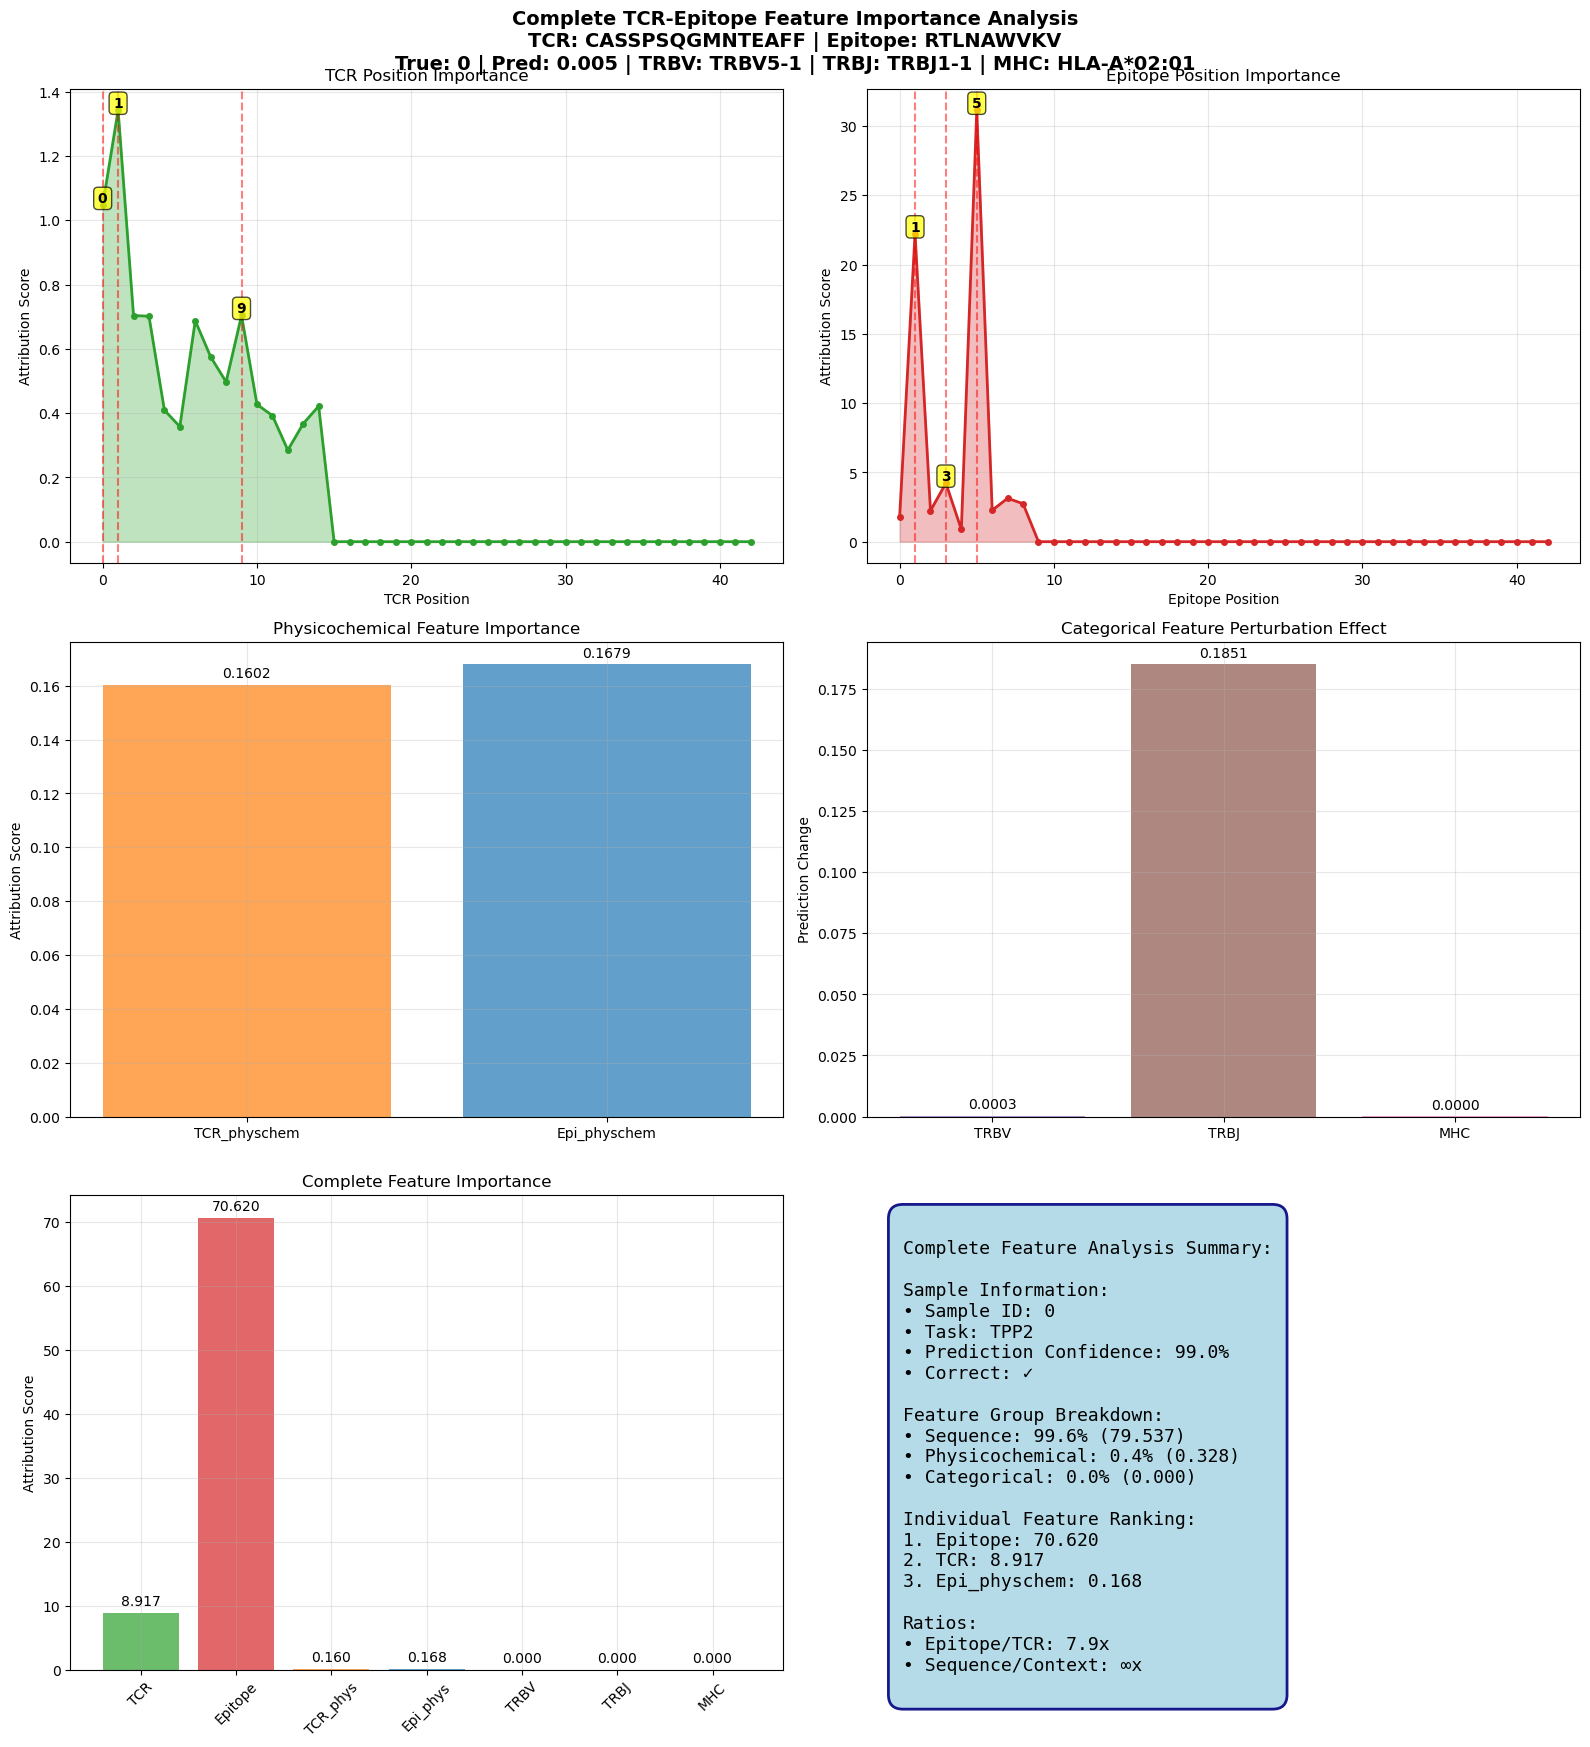

In [29]:
results = analyze_complete_sample_reduced(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    sample_idx=0, 
    methods=['integrated_gradients']
)

### Plots separately

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def create_tcr_position_plot(attributions, sample_info):
    """
    Create TCR position importance plot
    """
    tcr_attr = attributions[0].squeeze(0).detach().cpu()
    tcr_pos_importance = torch.abs(tcr_attr).sum(dim=-1).numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    positions = np.arange(len(tcr_pos_importance))
    ax.plot(positions, tcr_pos_importance, 'o-', color='#2ca02c', linewidth=2, markersize=4)
    ax.fill_between(positions, tcr_pos_importance, alpha=0.3, color='#2ca02c')
    ax.set_xlabel('TCR Position', fontsize=12)
    ax.set_ylabel('Attribution Score', fontsize=12)
    ax.set_title(f'TCR Position Importance\nTCR: {sample_info["tcr_sequence"]}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Highlight top 3 positions
    top_positions = np.argsort(tcr_pos_importance)[-3:]
    for pos in top_positions:
        ax.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
        ax.text(pos, tcr_pos_importance[pos], f'{pos}', ha='center', va='bottom', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    return fig

def create_epitope_position_plot(attributions, sample_info):
    """
    Create epitope position importance plot
    """
    epitope_attr = attributions[1].squeeze(0).detach().cpu()
    epitope_pos_importance = torch.abs(epitope_attr).sum(dim=-1).numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    positions = np.arange(len(epitope_pos_importance))
    ax.plot(positions, epitope_pos_importance, 'o-', color='#d62728', linewidth=2, markersize=4)
    ax.fill_between(positions, epitope_pos_importance, alpha=0.3, color='#d62728')
    ax.set_xlabel('Epitope Position', fontsize=12)
    ax.set_ylabel('Attribution Score', fontsize=12)
    ax.set_title(f'Epitope Position Importance\nEpitope: {sample_info["epitope_sequence"]}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Highlight top 3 positions
    top_positions = np.argsort(epitope_pos_importance)[-3:]
    for pos in top_positions:
        ax.axvline(x=pos, color='red', linestyle='--', alpha=0.5)
        ax.text(pos, epitope_pos_importance[pos], f'{pos}', ha='center', va='bottom', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    return fig

def create_physicochemical_plot(scores, sample_info):
    """
    Create physicochemical feature importance plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    phys_names = ['TCR_physchem', 'Epi_physchem']
    phys_scores = [scores['TCR_physchem'], scores['Epi_physchem']]
    phys_colors = ['#ff7f0e', '#1f77b4']
    
    bars = ax.bar(phys_names, phys_scores, color=phys_colors, alpha=0.7)
    ax.set_ylabel('Attribution Score', fontsize=12)
    ax.set_title('Physicochemical Feature Importance', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, phys_scores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(phys_scores)*0.01,
                f'{score:.4f}', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    return fig

def create_perturbation_plot(all_results, primary_method, sample_info):
    """
    Create categorical feature perturbation effect plot
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    if 'categorical_perturbation' in all_results[primary_method]:
        pert_scores = all_results[primary_method]['categorical_perturbation']
        pert_names = list(pert_scores.keys())
        pert_values = list(pert_scores.values())
        
        bars = ax.bar(pert_names, pert_values, color=['#9467bd', '#8c564b', '#e377c2'], alpha=0.7)
        ax.set_ylabel('Prediction Change', fontsize=12)
        ax.set_title('Categorical Feature Perturbation Effect', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, pert_values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(pert_values)*0.01,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=11)
    else:
        ax.text(0.5, 0.5, 'Perturbation analysis\nnot available', 
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        ax.set_title('Categorical Perturbation Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

def create_complete_feature_plot(scores, sample_info):
    """
    Create complete feature importance plot (all 7 features)
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    feature_names = ['TCR', 'Epitope', 'TCR_phys', 'Epi_phys', 'TRBV', 'TRBJ', 'MHC']
    feature_scores = [scores[name] for name in ['TCR', 'Epitope', 'TCR_physchem', 'Epi_physchem', 'TRBV', 'TRBJ', 'MHC']]
    
    bars = ax.bar(feature_names, feature_scores, 
                  color=['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4', '#9467bd', '#8c564b', '#e377c2'], 
                  alpha=0.7)
    ax.set_ylabel('Attribution Score', fontsize=12)
    ax.set_title('Complete Feature Importance', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, feature_scores):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_scores)*0.01,
                f'{score:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    return fig

def create_summary_text_plot(all_results, sample_info, primary_method):
    """
    Create summary statistics plot
    """
    scores = all_results[primary_method]['importance_scores']
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.axis('off')
    
    sequence_score = scores['TCR'] + scores['Epitope']
    physchem_score = scores['TCR_physchem'] + scores['Epi_physchem']
    categorical_score = scores['TRBV'] + scores['TRBJ'] + scores['MHC']
    
    total_attribution = sum(scores.values())
    sequence_pct = (sequence_score / total_attribution) * 100 if total_attribution > 0 else 0
    physchem_pct = (physchem_score / total_attribution) * 100 if total_attribution > 0 else 0
    categorical_pct = (categorical_score / total_attribution) * 100 if total_attribution > 0 else 0
    
    # Handle division by zero for ratios
    epitope_tcr_ratio = scores['Epitope']/scores['TCR'] if scores['TCR'] > 0 else float('inf')
    sequence_context_ratio = sequence_score/categorical_score if categorical_score > 0 else float('inf')
    
    # Format ratios safely
    epitope_tcr_str = f"{epitope_tcr_ratio:.1f}x" if epitope_tcr_ratio != float('inf') else "∞x"
    sequence_context_str = f"{sequence_context_ratio:.1f}x" if sequence_context_ratio != float('inf') else "∞x"
    
    # Get top 3 features safely
    sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_features = []
    for i in range(min(3, len(sorted_features))):
        feature_name, feature_score = sorted_features[i]
        top_features.append(f"{i+1}. {feature_name}: {feature_score:.3f}")
    
    summary_text = f"""
Complete Feature Analysis Summary:

Sample Information:
• Sample ID: {sample_info['sample_idx']}
• Task: {sample_info['task']}
• Prediction Confidence: {abs(sample_info['predicted_prob'] - 0.5)*2:.1%}
• Correct: {'✓' if (sample_info['predicted_prob'] > 0.5) == sample_info['true_label'] else '✗'}

Feature Group Breakdown:
• Sequence: {sequence_pct:.1f}% ({sequence_score:.3f})
• Physicochemical: {physchem_pct:.1f}% ({physchem_score:.3f})
• Categorical: {categorical_pct:.1f}% ({categorical_score:.3f})

Individual Feature Ranking:
{chr(10).join(top_features)}

Ratios:
• Epitope/TCR: {epitope_tcr_str}
• Sequence/Context: {sequence_context_str}
    """
    
    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.9, 
                     edgecolor='navy', linewidth=2))
    
    ax.set_title('Complete Feature Analysis Summary', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

# Main function to create all separate plots
def create_all_separate_single_sample_plots(all_results, sample_info, primary_method='integrated_gradients', 
                                           save_plots=False, save_dir='./'):
    """
    Create all 6 plots from single sample analysis separately
    
    Args:
        all_results: Results dictionary from complete sample analysis
        sample_info: Sample information dictionary
        primary_method: Method to use for analysis
        save_plots: Whether to save plots to files
        save_dir: Directory to save plots
    
    Returns:
        Dictionary containing all figure objects
    """
    
    plots = {}
    scores = all_results[primary_method]['importance_scores']
    attributions = all_results[primary_method]['attributions']
    
    print("Creating separate single-sample plots...")
    
    # 1. TCR Position Importance
    print("  - Creating TCR position plot...")
    plots['tcr_position'] = create_tcr_position_plot(attributions, sample_info)
    if save_plots:
        plots['tcr_position'].savefig(f"{save_dir}/tcr_position_importance.png", dpi=300, bbox_inches='tight')
    
    # 2. Epitope Position Importance
    print("  - Creating epitope position plot...")
    plots['epitope_position'] = create_epitope_position_plot(attributions, sample_info)
    if save_plots:
        plots['epitope_position'].savefig(f"{save_dir}/epitope_position_importance.png", dpi=300, bbox_inches='tight')
    
    # 3. Physicochemical Features
    print("  - Creating physicochemical plot...")
    plots['physicochemical'] = create_physicochemical_plot(scores, sample_info)
    if save_plots:
        plots['physicochemical'].savefig(f"{save_dir}/physicochemical_importance.png", dpi=300, bbox_inches='tight')
    
    # 4. Perturbation Analysis
    print("  - Creating perturbation plot...")
    plots['perturbation'] = create_perturbation_plot(all_results, primary_method, sample_info)
    if save_plots:
        plots['perturbation'].savefig(f"{save_dir}/categorical_perturbation.png", dpi=300, bbox_inches='tight')
    
    # 5. Complete Feature Importance
    print("  - Creating complete feature plot...")
    plots['complete_features'] = create_complete_feature_plot(scores, sample_info)
    if save_plots:
        plots['complete_features'].savefig(f"{save_dir}/complete_feature_importance.png", dpi=300, bbox_inches='tight')
    
    # 6. Summary
    print("  - Creating summary plot...")
    plots['summary'] = create_summary_text_plot(all_results, sample_info, primary_method)
    if save_plots:
        plots['summary'].savefig(f"{save_dir}/analysis_summary.png", dpi=300, bbox_inches='tight')
    
    # Show all plots
    for plot_name, fig in plots.items():
        plt.show()
    
    print("✅ All single-sample plots created successfully!")
    return plots

# Individual plot creation functions
def plot_tcr_position_only(all_results, sample_info, primary_method='integrated_gradients'):
    """Create only the TCR position plot"""
    attributions = all_results[primary_method]['attributions']
    return create_tcr_position_plot(attributions, sample_info)

def plot_epitope_position_only(all_results, sample_info, primary_method='integrated_gradients'):
    """Create only the epitope position plot"""
    attributions = all_results[primary_method]['attributions']
    return create_epitope_position_plot(attributions, sample_info)

def plot_physicochemical_only(all_results, sample_info, primary_method='integrated_gradients'):
    """Create only the physicochemical plot"""
    scores = all_results[primary_method]['importance_scores']
    return create_physicochemical_plot(scores, sample_info)

def plot_perturbation_only(all_results, sample_info, primary_method='integrated_gradients'):
    """Create only the perturbation plot"""
    return create_perturbation_plot(all_results, primary_method, sample_info)

def plot_complete_features_only(all_results, sample_info, primary_method='integrated_gradients'):
    """Create only the complete features plot"""
    scores = all_results[primary_method]['importance_scores']
    return create_complete_feature_plot(scores, sample_info)

def plot_summary_only(all_results, sample_info, primary_method='integrated_gradients'):
    """Create only the summary plot"""
    return create_summary_text_plot(all_results, sample_info, primary_method)

print("""
Usage Examples:

# From your complete single-sample analysis:
results = analyze_complete_sample_reduced(model, test_data, tcr_test_embeddings, 
                                         epitope_test_embeddings, physchem_file, sample_idx=0)
sample_info = results['integrated_gradients']['sample_info']

# Create all plots separately:
plots = create_all_separate_single_sample_plots(results, sample_info, save_plots=True)

# Create individual plots:
fig1 = plot_tcr_position_only(results, sample_info)
fig2 = plot_epitope_position_only(results, sample_info)
fig3 = plot_physicochemical_only(results, sample_info)
fig4 = plot_perturbation_only(results, sample_info)
fig5 = plot_complete_features_only(results, sample_info)
fig6 = plot_summary_only(results, sample_info)

# Access individual plots:
tcr_fig = plots['tcr_position']
epitope_fig = plots['epitope_position']
phys_fig = plots['physicochemical']
pert_fig = plots['perturbation']
complete_fig = plots['complete_features']
summary_fig = plots['summary']
""")


Usage Examples:

# From your complete single-sample analysis:
results = analyze_complete_sample_reduced(model, test_data, tcr_test_embeddings, 
                                         epitope_test_embeddings, physchem_file, sample_idx=0)
sample_info = results['integrated_gradients']['sample_info']

# Create all plots separately:
plots = create_all_separate_single_sample_plots(results, sample_info, save_plots=True)

# Create individual plots:
fig1 = plot_tcr_position_only(results, sample_info)
fig2 = plot_epitope_position_only(results, sample_info)
fig3 = plot_physicochemical_only(results, sample_info)
fig4 = plot_perturbation_only(results, sample_info)
fig5 = plot_complete_features_only(results, sample_info)
fig6 = plot_summary_only(results, sample_info)

# Access individual plots:
tcr_fig = plots['tcr_position']
epitope_fig = plots['epitope_position']
phys_fig = plots['physicochemical']
pert_fig = plots['perturbation']
complete_fig = plots['complete_features']
summary_fig = plots['s

Analyzing Sample 0 (Complete Feature Analysis):
  TCR: CASSPSQGMNTEAFF
  Epitope: RTLNAWVKV
  True Label: 0
  Prediction: 0.0048
  TRBV: TRBV5-1 (idx: 4)
  TRBJ: TRBJ1-1 (idx: 6)
  MHC: HLA-A*02:01 (idx: 0)

Computing integrated_gradients for all features...

Analyzing categorical features using occlusion...
TRBV: TRBV5-1 (idx: 4) -> Avg change: 0.0003
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1851
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0000


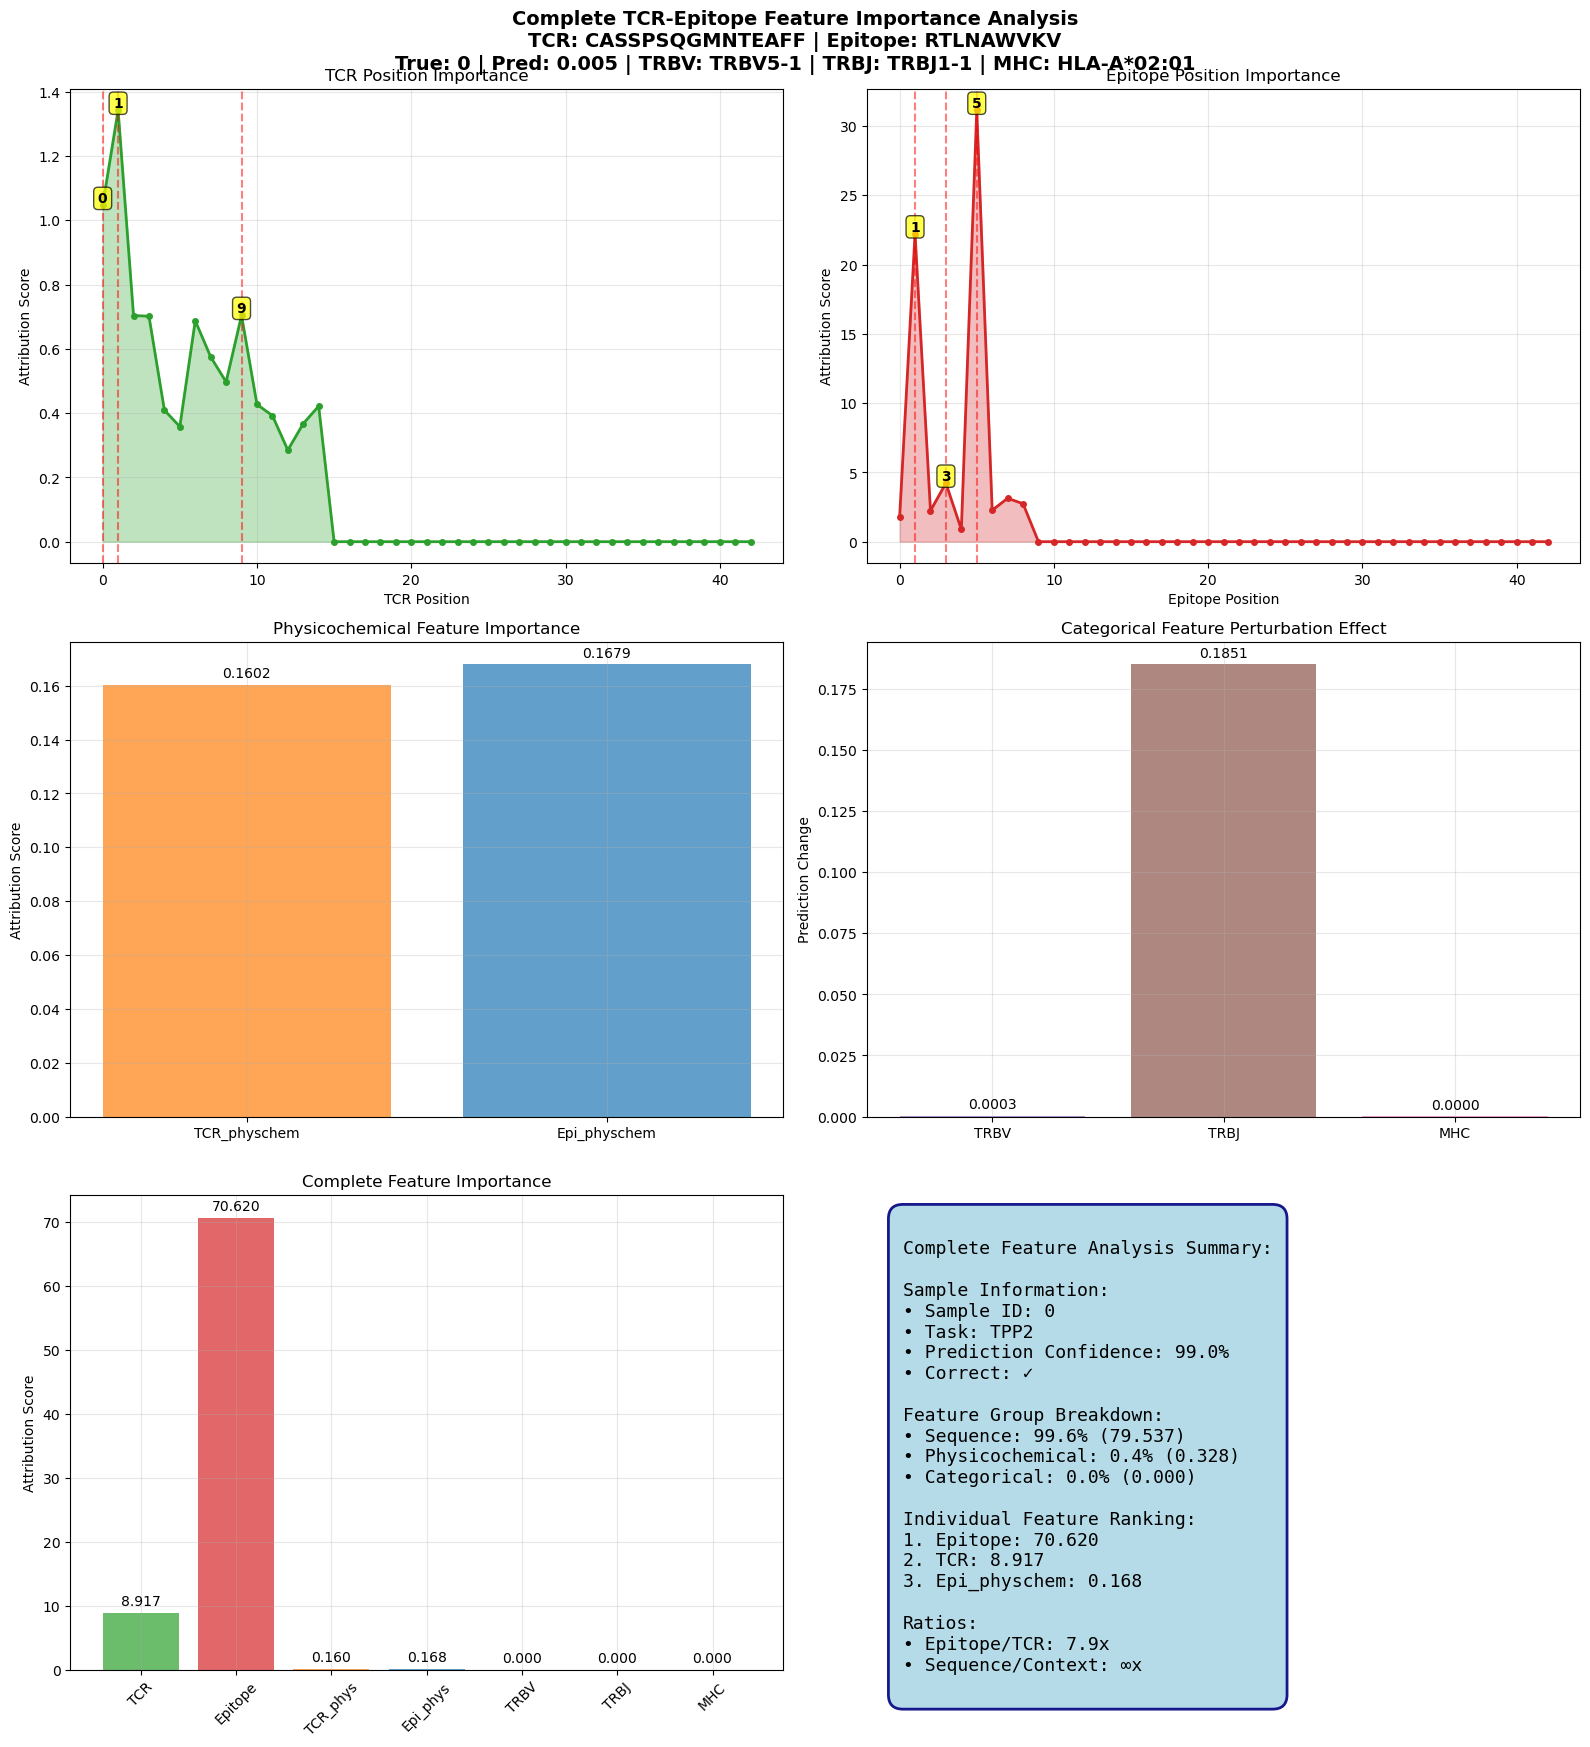

Creating separate single-sample plots...
  - Creating TCR position plot...
  - Creating epitope position plot...
  - Creating physicochemical plot...
  - Creating perturbation plot...
  - Creating complete feature plot...
  - Creating summary plot...


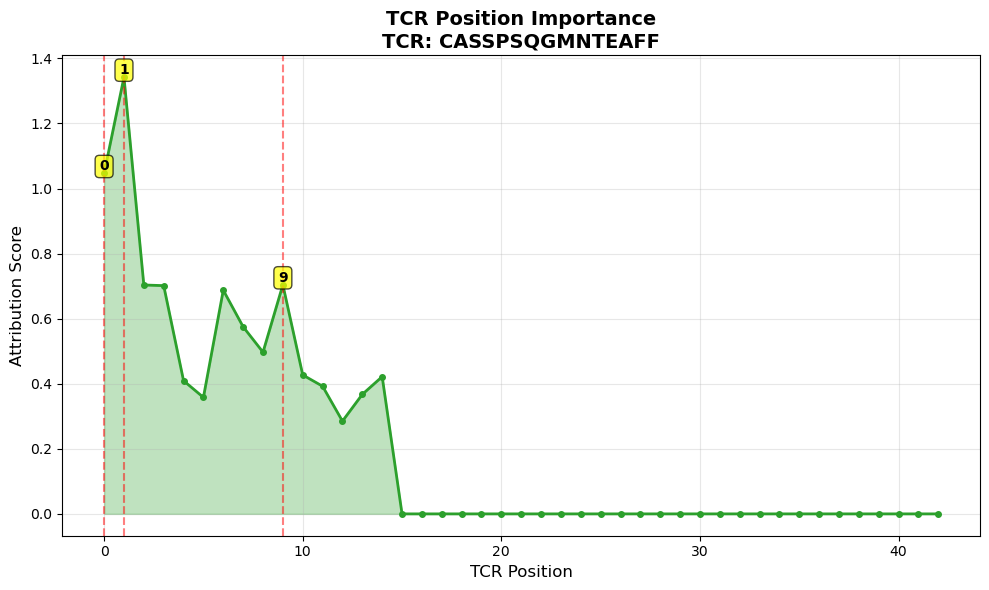

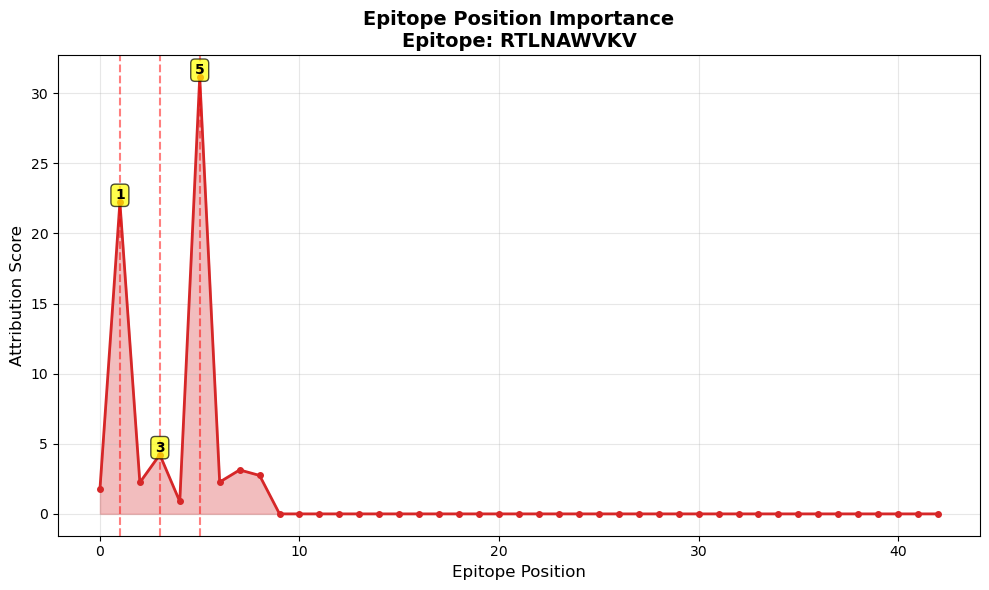

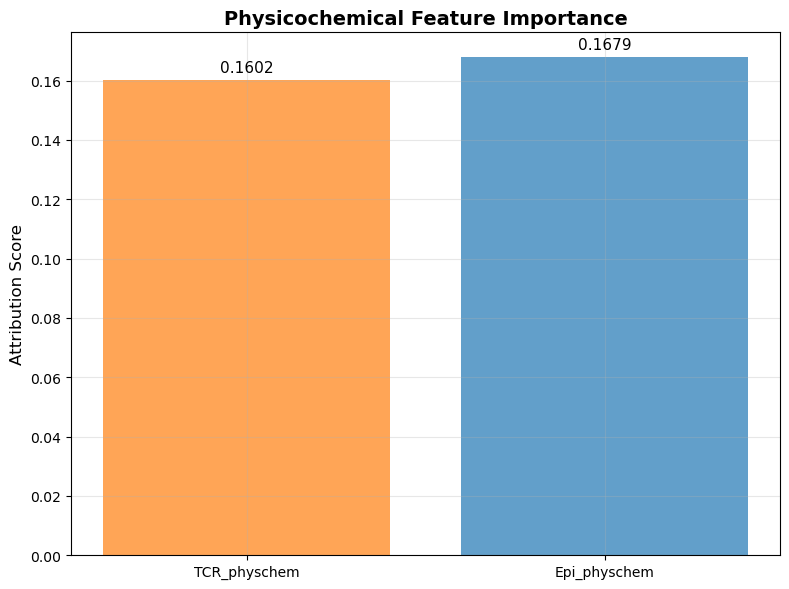

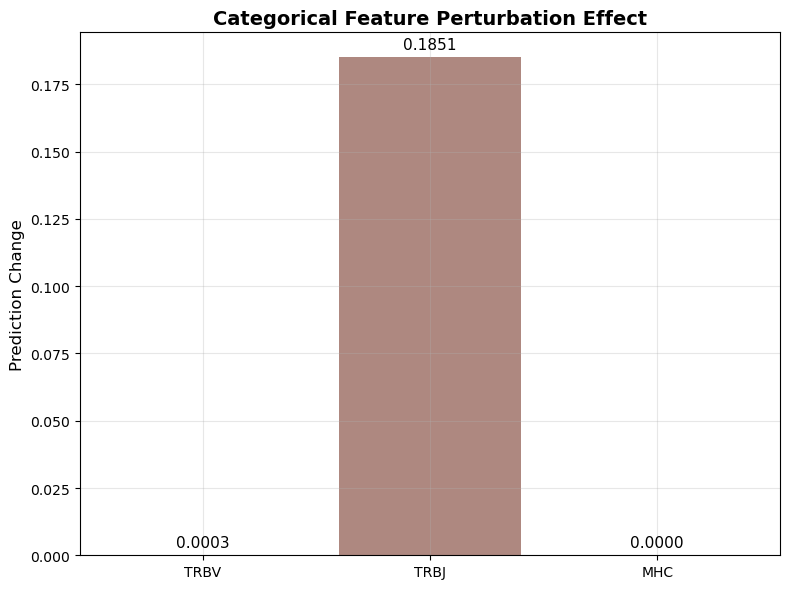

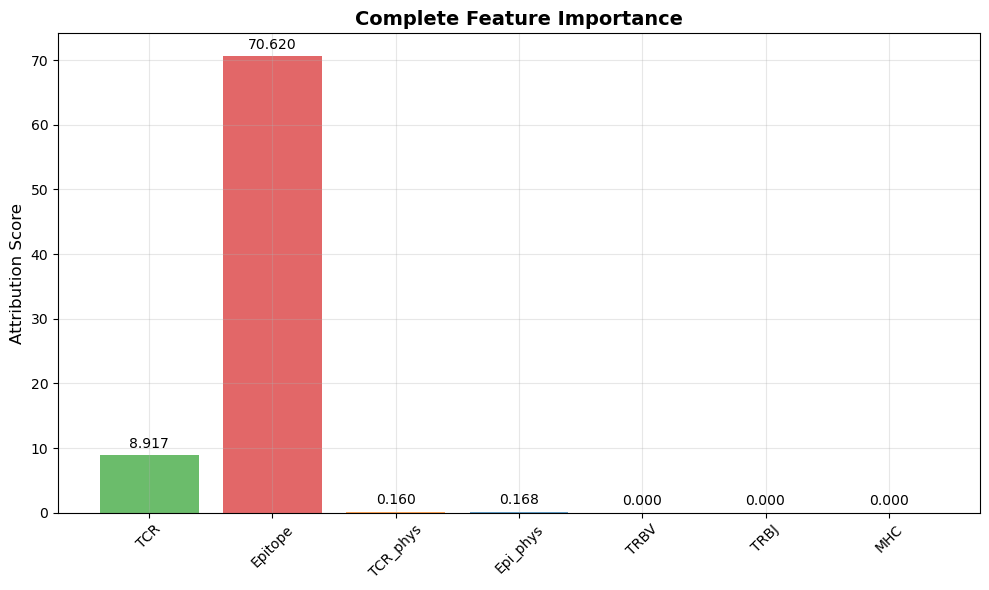

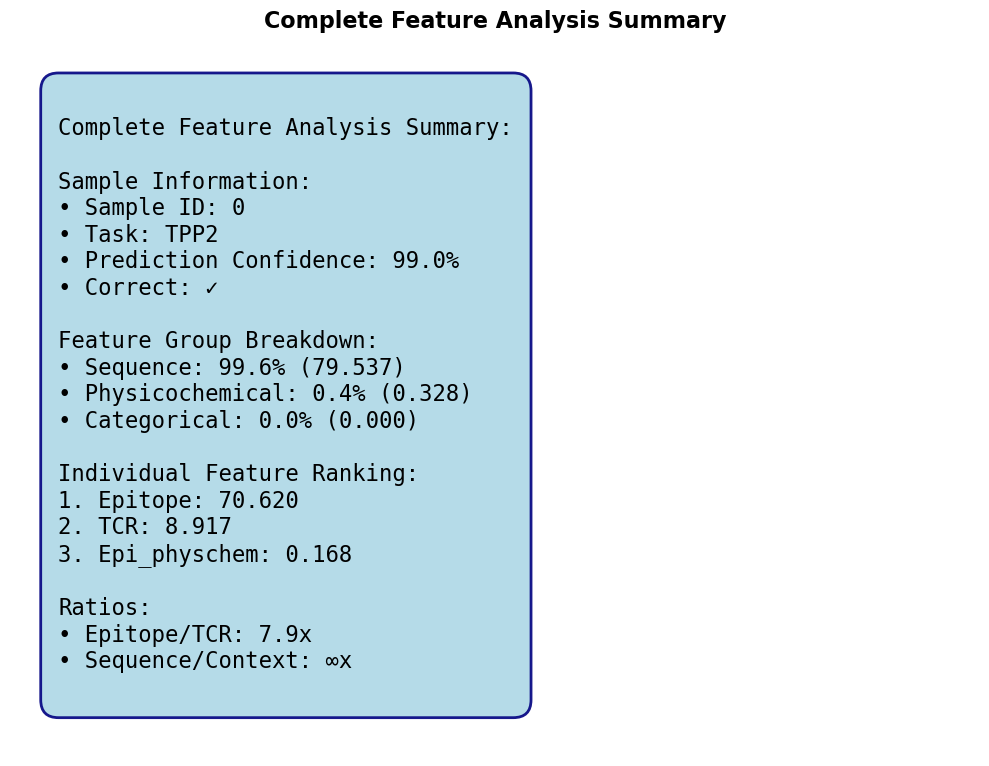

✅ All single-sample plots created successfully!


In [ ]:
results = analyze_complete_sample_reduced(model, test_data, tcr_test_embeddings, 
                                         epitope_test_embeddings, physchem_file, sample_idx=0)
sample_info = results['integrated_gradients']['sample_info']

# Create all plots separately:
plots = create_all_separate_single_sample_plots(results, sample_info, save_plots=True)

### Analyzing CF

In [57]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def analyze_categorical_patterns(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, 
                               n_samples=50, sample_strategy='diverse'):
    """
    Analyze categorical feature importance patterns across multiple samples
    
    Args:
        sample_strategy: 'diverse', 'binding_vs_nonbinding', 'mhc_variety', or 'random'
    """
    
    # Select samples based on strategy
    if sample_strategy == 'diverse':
        # Get diverse samples across different categories
        sample_indices = get_diverse_samples(test_data, n_samples)
    elif sample_strategy == 'binding_vs_nonbinding':
        # Equal numbers of binding and non-binding
        sample_indices = get_binding_comparison_samples(test_data, n_samples)
    elif sample_strategy == 'mhc_variety':
        # Samples across different MHC alleles
        sample_indices = get_mhc_variety_samples(test_data, n_samples)
    else:  # random
        sample_indices = test_data.sample(n_samples, random_state=42).index.tolist()
    
    print(f"Analyzing {len(sample_indices)} samples using '{sample_strategy}' strategy...")
    
    # Initialize analyzer
    from importlib import reload
    analyzer = FullFeatureTCRAnalyzer(model)
    
    # Store results
    results_data = []
    
    # Analyze each sample
    for i, sample_idx in enumerate(tqdm(sample_indices, desc="Processing samples")):
        try:
            # Extract sample data
            sample_tensors, sample_info = analyzer.extract_sample_data(
                test_data, tcr_embeddings, epitope_embeddings, physchem_file, sample_idx
            )
            
            # Get prediction
            prediction = analyzer.get_model_prediction(sample_tensors)
            
            # Quick gradient-based attribution (just for categorical)
            try:
                attributions = analyzer._compute_hybrid_attributions(sample_tensors, 'integrated_gradients', 20)
                cat_attr_scores = {
                    'TRBV_attr': torch.abs(attributions[4]).sum().item(),
                    'TRBJ_attr': torch.abs(attributions[5]).sum().item(),
                    'MHC_attr': torch.abs(attributions[6]).sum().item()
                }
            except:
                cat_attr_scores = {'TRBV_attr': 0, 'TRBJ_attr': 0, 'MHC_attr': 0}
            
            # Perturbation analysis
            perturbation_scores = analyzer.analyze_categorical_importance(sample_tensors, sample_info, method='perturbation')
            
            # Store all data
            result = {
                'sample_idx': sample_idx,
                'tcr_sequence': sample_info['tcr_sequence'],
                'epitope_sequence': sample_info['epitope_sequence'],
                'true_label': sample_info['true_label'],
                'predicted_prob': prediction,
                'trbv': sample_info['trbv'],
                'trbj': sample_info['trbj'],
                'mhc': sample_info['mhc'],
                'trbv_index': sample_info['trbv_index'],
                'trbj_index': sample_info['trbj_index'],
                'mhc_index': sample_info['mhc_index'],
                'task': sample_info['task'],
                
                # Attribution scores
                'TRBV_attribution': cat_attr_scores['TRBV_attr'],
                'TRBJ_attribution': cat_attr_scores['TRBJ_attr'],
                'MHC_attribution': cat_attr_scores['MHC_attr'],
                
                # Perturbation scores
                'TRBV_perturbation': perturbation_scores.get('TRBV', 0),
                'TRBJ_perturbation': perturbation_scores.get('TRBJ', 0),
                'MHC_perturbation': perturbation_scores.get('MHC', 0),
                
                # Prediction confidence
                'confidence': abs(prediction - 0.5) * 2,
                'correct_prediction': (prediction > 0.5) == sample_info['true_label']
            }
            
            results_data.append(result)
            
        except Exception as e:
            print(f"Error processing sample {sample_idx}: {str(e)}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results_data)
    
    # Create comprehensive visualizations
    create_categorical_analysis_plots(results_df, sample_strategy)
    
    return results_df

def get_diverse_samples(test_data, n_samples):
    """Get diverse samples across different categories"""
    samples = []
    
    # Binding vs non-binding
    binding_samples = test_data[test_data['Binding'] == 1].sample(min(n_samples//2, len(test_data[test_data['Binding'] == 1]))).index.tolist()
    non_binding_samples = test_data[test_data['Binding'] == 0].sample(min(n_samples//2, len(test_data[test_data['Binding'] == 0]))).index.tolist()
    samples.extend(binding_samples + non_binding_samples)
    
    # Different MHC alleles
    top_mhcs = test_data['MHC'].value_counts().head(5).index
    for mhc in top_mhcs:
        mhc_samples = test_data[test_data['MHC'] == mhc].sample(min(2, len(test_data[test_data['MHC'] == mhc]))).index.tolist()
        samples.extend(mhc_samples)
    
    # Different tasks
    if 'task' in test_data.columns:
        for task in test_data['task'].unique()[:4]:
            task_samples = test_data[test_data['task'] == task].sample(min(3, len(test_data[test_data['task'] == task]))).index.tolist()
            samples.extend(task_samples)
    
    # Remove duplicates and limit
    samples = list(set(samples))[:n_samples]
    return samples

def get_binding_comparison_samples(test_data, n_samples):
    """Get equal numbers of binding and non-binding samples"""
    n_each = n_samples // 2
    binding_samples = test_data[test_data['Binding'] == 1].sample(n_each).index.tolist()
    non_binding_samples = test_data[test_data['Binding'] == 0].sample(n_each).index.tolist()
    return binding_samples + non_binding_samples

def get_mhc_variety_samples(test_data, n_samples):
    """Get samples across different MHC alleles"""
    samples = []
    top_mhcs = test_data['MHC'].value_counts().head(10).index
    samples_per_mhc = max(1, n_samples // len(top_mhcs))
    
    for mhc in top_mhcs:
        mhc_samples = test_data[test_data['MHC'] == mhc].sample(min(samples_per_mhc, len(test_data[test_data['MHC'] == mhc]))).index.tolist()
        samples.extend(mhc_samples)
    
    return samples[:n_samples]

def create_categorical_analysis_plots(results_df, strategy_name):
    """Create comprehensive plots for categorical feature analysis"""
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f'Categorical Feature Analysis - {strategy_name.title()} Strategy\n'
                f'({len(results_df)} samples)', fontsize=16, fontweight='bold')
    
    # 1. Overall attribution distributions
    ax1 = axes[0, 0]
    attr_data = results_df[['TRBV_attribution', 'TRBJ_attribution', 'MHC_attribution']]
    attr_data.columns = ['TRBV', 'TRBJ', 'MHC']
    
    bp1 = ax1.boxplot([attr_data['TRBV'], attr_data['TRBJ'], attr_data['MHC']], 
                      labels=['TRBV', 'TRBJ', 'MHC'], patch_artist=True)
    colors = ['#9467bd', '#8c564b', '#e377c2']
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Attribution Score')
    ax1.set_title('Attribution Score Distributions')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Perturbation effect distributions
    ax2 = axes[0, 1]
    pert_data = results_df[['TRBV_perturbation', 'TRBJ_perturbation', 'MHC_perturbation']]
    pert_data.columns = ['TRBV', 'TRBJ', 'MHC']
    
    bp2 = ax2.boxplot([pert_data['TRBV'], pert_data['TRBJ'], pert_data['MHC']], 
                      labels=['TRBV', 'TRBJ', 'MHC'], patch_artist=True)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Perturbation Effect')
    ax2.set_title('Perturbation Effect Distributions')
    ax2.grid(True, alpha=0.3)
    
    # 3. Binding vs Non-binding comparison (Attribution)
    ax3 = axes[0, 2]
    binding_attr = results_df[results_df['true_label'] == 1][['TRBV_attribution', 'TRBJ_attribution', 'MHC_attribution']].mean()
    nonbinding_attr = results_df[results_df['true_label'] == 0][['TRBV_attribution', 'TRBJ_attribution', 'MHC_attribution']].mean()
    
    x = np.arange(3)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, binding_attr.values, width, label='Binding', color='green', alpha=0.7)
    bars2 = ax3.bar(x + width/2, nonbinding_attr.values, width, label='Non-binding', color='red', alpha=0.7)
    
    ax3.set_xlabel('Categorical Feature')
    ax3.set_ylabel('Mean Attribution Score')
    ax3.set_title('Attribution: Binding vs Non-binding')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['TRBV', 'TRBJ', 'MHC'])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Binding vs Non-binding comparison (Perturbation)
    ax4 = axes[0, 3]
    binding_pert = results_df[results_df['true_label'] == 1][['TRBV_perturbation', 'TRBJ_perturbation', 'MHC_perturbation']].mean()
    nonbinding_pert = results_df[results_df['true_label'] == 0][['TRBV_perturbation', 'TRBJ_perturbation', 'MHC_perturbation']].mean()
    
    bars1 = ax4.bar(x - width/2, binding_pert.values, width, label='Binding', color='green', alpha=0.7)
    bars2 = ax4.bar(x + width/2, nonbinding_pert.values, width, label='Non-binding', color='red', alpha=0.7)
    
    ax4.set_xlabel('Categorical Feature')
    ax4.set_ylabel('Mean Perturbation Effect')
    ax4.set_title('Perturbation: Binding vs Non-binding')
    ax4.set_xticks(x)
    ax4.set_xticklabels(['TRBV', 'TRBJ', 'MHC'])
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. MHC-specific patterns
    ax5 = axes[1, 0]
    top_mhcs = results_df['mhc'].value_counts().head(8).index
    mhc_pert_means = []
    mhc_labels = []
    
    for mhc in top_mhcs:
        mhc_data = results_df[results_df['mhc'] == mhc]
        if len(mhc_data) > 0:
            mean_pert = mhc_data['MHC_perturbation'].mean()
            mhc_pert_means.append(mean_pert)
            mhc_labels.append(mhc.split('-')[0] if '-' in str(mhc) else str(mhc)[:8])
    
    bars = ax5.bar(range(len(mhc_pert_means)), mhc_pert_means, color='#e377c2', alpha=0.7)
    ax5.set_xlabel('MHC Allele')
    ax5.set_ylabel('Mean MHC Perturbation Effect')
    ax5.set_title('MHC Perturbation by Allele')
    ax5.set_xticks(range(len(mhc_labels)))
    ax5.set_xticklabels(mhc_labels, rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # 6. Correlation between attribution and perturbation
    ax6 = axes[1, 1]
    for i, (feature, color) in enumerate(zip(['TRBV', 'TRBJ', 'MHC'], colors)):
        x_vals = results_df[f'{feature}_attribution']
        y_vals = results_df[f'{feature}_perturbation']
        
        # Filter out zeros for better visualization
        mask = (x_vals > 0) & (y_vals > 0)
        if mask.sum() > 0:
            ax6.scatter(x_vals[mask], y_vals[mask], alpha=0.6, color=color, label=feature, s=30)
    
    ax6.set_xlabel('Attribution Score')
    ax6.set_ylabel('Perturbation Effect')
    ax6.set_title('Attribution vs Perturbation Correlation')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_xscale('log')
    
    # 7. Confidence vs categorical importance
    ax7 = axes[1, 2]
    total_categorical = (results_df['TRBV_perturbation'] + 
                        results_df['TRBJ_perturbation'] + 
                        results_df['MHC_perturbation'])
    
    scatter = ax7.scatter(results_df['confidence'], total_categorical, 
                         c=results_df['true_label'], cmap='RdYlGn', alpha=0.6, s=30)
    ax7.set_xlabel('Prediction Confidence')
    ax7.set_ylabel('Total Categorical Perturbation')
    ax7.set_title('Confidence vs Categorical Importance')
    ax7.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax7, label='True Label')
    
    # 8. Task-specific patterns (if available)
    ax8 = axes[1, 3]
    if 'task' in results_df.columns and results_df['task'].nunique() > 1:
        task_means = results_df.groupby('task')[['TRBV_perturbation', 'TRBJ_perturbation', 'MHC_perturbation']].mean()
        
        task_means.plot(kind='bar', ax=ax8, color=colors, alpha=0.7)
        ax8.set_xlabel('Task')
        ax8.set_ylabel('Mean Perturbation Effect')
        ax8.set_title('Categorical Importance by Task')
        ax8.legend(['TRBV', 'TRBJ', 'MHC'])
        ax8.tick_params(axis='x', rotation=45)
        ax8.grid(True, alpha=0.3)
    else:
        ax8.text(0.5, 0.5, 'Task analysis\nnot available', ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Task-specific Analysis')
    
    # 9. Zero importance samples analysis
    ax9 = axes[2, 0]
    zero_counts = {
        'TRBV': (results_df['TRBV_perturbation'] == 0).sum(),
        'TRBJ': (results_df['TRBJ_perturbation'] == 0).sum(),
        'MHC': (results_df['MHC_perturbation'] == 0).sum()
    }
    
    bars = ax9.bar(zero_counts.keys(), zero_counts.values(), color=colors, alpha=0.7)
    ax9.set_ylabel('Number of Zero-Effect Samples')
    ax9.set_title('Samples with Zero Categorical Effect')
    ax9.grid(True, alpha=0.3)
    
    # Add percentage labels
    total_samples = len(results_df)
    for bar, count in zip(bars, zero_counts.values()):
        percentage = (count / total_samples) * 100
        ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total_samples*0.01,
                f'{percentage:.1f}%', ha='center', va='bottom')
    
    # 10. Distribution of non-zero effects
    ax10 = axes[2, 1]
    non_zero_data = []
    labels = []
    
    for feature in ['TRBV', 'TRBJ', 'MHC']:
        non_zero_vals = results_df[results_df[f'{feature}_perturbation'] > 0][f'{feature}_perturbation']
        if len(non_zero_vals) > 0:
            non_zero_data.append(non_zero_vals)
            labels.append(feature)
    
    if non_zero_data:
        bp = ax10.boxplot(non_zero_data, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(labels)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax10.set_ylabel('Perturbation Effect (Non-zero only)')
    ax10.set_title('Non-zero Effect Distributions')
    ax10.grid(True, alpha=0.3)
    
    # 11. Summary statistics table
    ax11 = axes[2, 2]
    ax11.axis('off')
    
    # Calculate summary statistics
    summary_stats = []
    for feature in ['TRBV', 'TRBJ', 'MHC']:
        pert_col = f'{feature}_perturbation'
        attr_col = f'{feature}_attribution'
        
        pert_mean = results_df[pert_col].mean()
        pert_std = results_df[pert_col].std()
        zero_pct = (results_df[pert_col] == 0).mean() * 100
        attr_mean = results_df[attr_col].mean()
        
        summary_stats.append([feature, f'{pert_mean:.4f}', f'{pert_std:.4f}', 
                             f'{zero_pct:.1f}%', f'{attr_mean:.4f}'])
    
    # Create table
    table_data = [['Feature', 'Mean Pert.', 'Std Pert.', '% Zero', 'Mean Attr.']] + summary_stats
    table = ax11.table(cellText=table_data, cellLoc='center', loc='center',
                      bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # Style header row
    for i in range(5):
        table[(0, i)].set_facecolor('#E6E6FA')
        table[(0, i)].set_text_props(weight='bold')
    
    ax11.set_title('Summary Statistics')
    
    # 12. Individual sample ranking
    ax12 = axes[2, 3]
    
    # Find samples with highest categorical effects
    results_df['total_categorical'] = (results_df['TRBV_perturbation'] + 
                                      results_df['TRBJ_perturbation'] + 
                                      results_df['MHC_perturbation'])
    
    top_samples = results_df.nlargest(10, 'total_categorical')
    
    y_pos = np.arange(len(top_samples))
    bars = ax12.barh(y_pos, top_samples['total_categorical'], alpha=0.7, color='purple')
    
    ax12.set_yticks(y_pos)
    ax12.set_yticklabels([f"S{idx}" for idx in top_samples['sample_idx']], fontsize=8)
    ax12.set_xlabel('Total Categorical Effect')
    ax12.set_title('Top 10 Samples by Categorical Effect')
    ax12.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Convenience functions for different analyses
def quick_categorical_analysis(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, n_samples=30):
    """Quick analysis with diverse samples"""
    return analyze_categorical_patterns(
        model, test_data, tcr_embeddings, epitope_embeddings, physchem_file,
        n_samples=n_samples, sample_strategy='diverse'
    )

def binding_comparison_analysis(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, n_samples=40):
    """Compare binding vs non-binding samples"""
    return analyze_categorical_patterns(
        model, test_data, tcr_embeddings, epitope_embeddings, physchem_file,
        n_samples=n_samples, sample_strategy='binding_vs_nonbinding'
    )

def mhc_focused_analysis(model, test_data, tcr_embeddings, epitope_embeddings, physchem_file, n_samples=50):
    """Focus on MHC allele variety"""
    return analyze_categorical_patterns(
        model, test_data, tcr_embeddings, epitope_embeddings, physchem_file,
        n_samples=n_samples, sample_strategy='mhc_variety'
    )

# Usage examples
print("""
Categorical Feature Analysis Across Multiple Samples

QUICK DIVERSE ANALYSIS (30 samples):
results_df = quick_categorical_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

BINDING VS NON-BINDING COMPARISON (40 samples):
results_df = binding_comparison_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

MHC-FOCUSED ANALYSIS (50 samples):
results_df = mhc_focused_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

CUSTOM ANALYSIS:
results_df = analyze_categorical_patterns(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    n_samples=100, sample_strategy='random'
)

The results_df contains all the detailed data for further analysis.
""")


Categorical Feature Analysis Across Multiple Samples

QUICK DIVERSE ANALYSIS (30 samples):
results_df = quick_categorical_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

BINDING VS NON-BINDING COMPARISON (40 samples):
results_df = binding_comparison_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

MHC-FOCUSED ANALYSIS (50 samples):
results_df = mhc_focused_analysis(model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file)

CUSTOM ANALYSIS:
results_df = analyze_categorical_patterns(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file,
    n_samples=100, sample_strategy='random'
)

The results_df contains all the detailed data for further analysis.



Analyzing 30 samples using 'diverse' strategy...


Processing samples:   3%|▎         | 1/30 [00:00<00:03,  8.94it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg change: 0.0018
TRBJ: TRBJ1-4*01 (idx: 23) -> Avg change: 0.7564
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0129
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV3-1*01 (idx: 113) -> Avg change: 0.0342
TRBJ: TRBJ2-5*01 (idx: 16) -> Avg change: 0.3348
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.3438
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9 (idx: 2) -> Avg change: 0.0002
TRBJ: TRBJ1-2 (idx: 5) -> Avg change: 0.1879


Processing samples:  17%|█▋        | 5/30 [00:00<00:01, 14.24it/s]

MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0014
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV24-1*01 (idx: 90) -> Avg change: 0.0008
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.5350
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0106
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0014
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.8056
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0030
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV27*01 (idx: 66) -> Avg change: 0.0002
TRBJ: TRBJ1-2*01 (idx: 17) -> Avg change: 0.0016
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0007
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using pe

Processing samples:  23%|██▎       | 7/30 [00:00<00:01, 16.08it/s]

TRBV: TRBV28 (idx: 22) -> Avg change: 0.0505
TRBJ: TRBJ1-5 (idx: 9) -> Avg change: 0.1297
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.2173
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV27*01 (idx: 66) -> Avg change: 0.0357
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.8726
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.7542
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV4-3*01 (idx: 68) -> Avg change: 0.0405
TRBJ: TRBJ2-5*01 (idx: 16) -> Avg change: 0.2299
MHC: HLA-B*15 (idx: 58) -> Avg change: 0.1124
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV4-1 (idx: 3) -> Avg change: 0.0000
TRBJ: TRBJ1-5 (idx: 9) -> Avg change: 0.1676


Processing samples:  33%|███▎      | 10/30 [00:00<00:01, 18.05it/s]

MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0000
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0011


Processing samples:  40%|████      | 12/30 [00:00<00:01, 18.00it/s]

TRBJ: TRBJ1-5*01 (idx: 22) -> Avg change: 0.0187
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.0143
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0003
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.3849
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0412
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0051
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.1692
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0028
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0100


Processing samples:  47%|████▋     | 14/30 [00:00<00:00, 18.31it/s]

TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.7035
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0040
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0012


Processing samples:  57%|█████▋    | 17/30 [00:00<00:00, 19.32it/s]

TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7625
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0019
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0057
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.0591
MHC: HLA-B*35:01 (idx: 7) -> Avg change: 0.0178
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV5-4*01 (idx: 82) -> Avg change: 0.0039
TRBJ: TRBJ1-3*01 (idx: 25) -> Avg change: 0.0694
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0289
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV25-1*01 (idx: 97) -> Avg change: 0.0031
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.0692
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0175
Using hybrid approach: gradients for continuous, perturbation for categor

Processing samples:  70%|███████   | 21/30 [00:01<00:00, 18.71it/s]

MHC: HLA-B*27:05 (idx: 11) -> Avg change: 0.3111
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-3 (idx: 25) -> Avg change: 0.0000
TRBJ: TRBJ1-2 (idx: 5) -> Avg change: 0.1723
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0000
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV3-1 (idx: 9) -> Avg change: 0.0000
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1772
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0000
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV5-4*01 (idx: 82) -> Avg change: 0.0072
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7135
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0101
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...


Processing samples:  87%|████████▋ | 26/30 [00:01<00:00, 19.43it/s]

TRBV: TRBV7-8*01 (idx: 95) -> Avg change: 0.0009
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.5371
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0040
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-5*01 (idx: 110) -> Avg change: 0.0033
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.0557
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.0101
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-6*01 (idx: 93) -> Avg change: 0.0461
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.3303
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.1860
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0050
TRBJ: TRBJ1-5*01 (idx: 22) -> Avg change: 0.0589
MHC: HLA-B*07 (idx: 35) -> Avg change: 0.0107
Using hybrid approach: g

Processing samples: 100%|██████████| 30/30 [00:01<00:00, 18.12it/s]

MHC: HLA-B*57:01 (idx: 9) -> Avg change: 0.0004
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV28*01 (idx: 62) -> Avg change: 0.0003
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.4900
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0214
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0142
TRBJ: TRBJ2-5*01 (idx: 16) -> Avg change: 0.0399
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0249
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV10-1 (idx: 30) -> Avg change: 0.0000
TRBJ: TRBJ2-7 (idx: 0) -> Avg change: 0.1898
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.0000


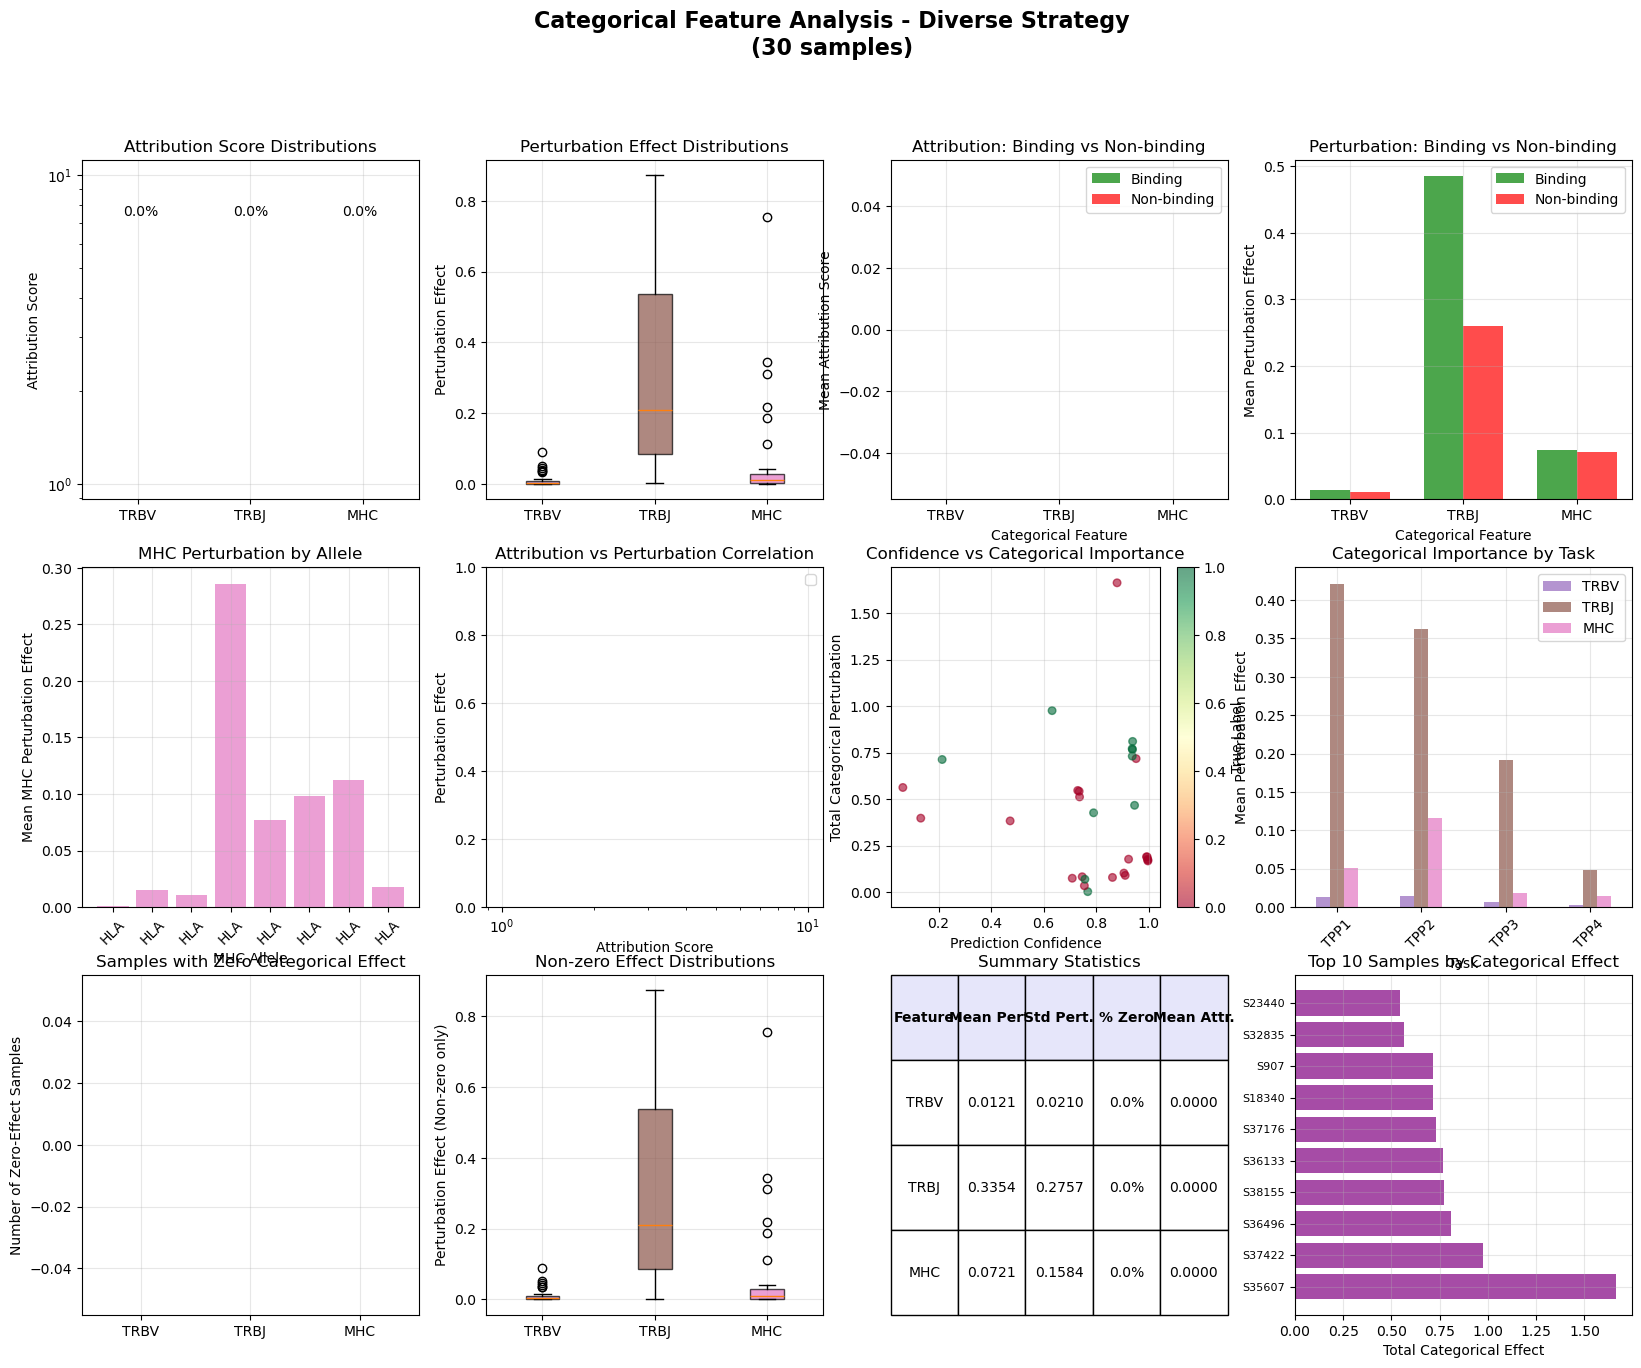

In [58]:
results_df = quick_categorical_analysis(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file
)

Analyzing 40 samples using 'binding_vs_nonbinding' strategy...


Processing samples:   5%|▌         | 2/40 [00:00<00:02, 17.68it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-2*01 (idx: 121) -> Avg change: 0.0006
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.5146
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0142
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV2*01 (idx: 102) -> Avg change: 0.0704
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.7109
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0856
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0012
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7561
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0025
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg c

Processing samples:  12%|█▎        | 5/40 [00:00<00:01, 20.13it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-3*01 (idx: 161) -> Avg change: 0.0020
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.7622
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0135
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV11-1*01 (idx: 94) -> Avg change: 0.0025
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.0142
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0780
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV14*01 (idx: 69) -> Avg change: 0.0012
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.0067
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0149


Processing samples:  22%|██▎       | 9/40 [00:00<00:02, 15.29it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg change: 0.0031
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.7342
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0611
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-3*01 (idx: 72) -> Avg change: 0.0011
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.0012
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0465
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-2*01 (idx: 115) -> Avg change: 0.0021
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.7586
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0124
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg

Processing samples:  38%|███▊      | 15/40 [00:00<00:01, 18.50it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-2*01 (idx: 115) -> Avg change: 0.0151
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.1430
MHC: HLA-B*42:01 (idx: 41) -> Avg change: 0.0599
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0012
TRBJ: TRBJ1-2*01 (idx: 17) -> Avg change: 0.0045
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0062
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV13*01 (idx: 86) -> Avg change: 0.0058
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7192
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0063
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg 

Processing samples:  45%|████▌     | 18/40 [00:00<00:01, 18.91it/s]

TRBV: TRBV25-1*01 (idx: 97) -> Avg change: 0.0109
TRBJ: TRBJ2-6*01 (idx: 24) -> Avg change: 0.7454
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0582
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9*01 (idx: 78) -> Avg change: 0.0003
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.4899
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0003
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9*01 (idx: 78) -> Avg change: 0.0260
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.7553
MHC: HLA-B*27:05 (idx: 11) -> Avg change: 0.2939
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-3*01 (idx: 104) -> Avg change: 0.0008
TRBJ: TRBJ2-5*01 (idx: 16) -> Avg change: 0.5344
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0027
Using hybrid appro

Processing samples:  57%|█████▊    | 23/40 [00:01<00:00, 19.45it/s]

TRBV: TRBV9*01 (idx: 64) -> Avg change: 0.0386
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.7132
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.7438
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV29-1 (idx: 5) -> Avg change: 0.0002
TRBJ: TRBJ1-3 (idx: 12) -> Avg change: 0.1877
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0008
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0590
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.7314
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0587
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9*01 (idx: 78) -> Avg change: 0.0010
TRBJ: TRBJ1-2*01 (idx: 17) -> Avg change: 0.0274
MHC: HLA-B*08 (idx: 39) -> Avg change: 0.0079
Using hybrid approach: gradients 

Processing samples:  65%|██████▌   | 26/40 [00:01<00:00, 19.79it/s]

TRBJ: TRBJ2-4*01 (idx: 20) -> Avg change: 0.7372
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0753
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-4*01 (idx: 118) -> Avg change: 0.0001
TRBJ: TRBJ1-6*01 (idx: 27) -> Avg change: 0.0089
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0018
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1 (idx: 0) -> Avg change: 0.0007
TRBJ: TRBJ1-6 (idx: 8) -> Avg change: 0.1870
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0019
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-3*01 (idx: 104) -> Avg change: 0.0010
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.3765
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0058
Using hybrid approach: gradients for continuous, perturbation for categori

Processing samples:  80%|████████  | 32/40 [00:01<00:00, 20.27it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV27 (idx: 17) -> Avg change: 0.0030
TRBJ: TRBJ1-2 (idx: 5) -> Avg change: 0.1887
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0063
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV18*01 (idx: 75) -> Avg change: 0.0002
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.0176
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0054
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5*01 (idx: 59) -> Avg change: 0.0317
TRBJ: TRBJ1-6*01 (idx: 27) -> Avg change: 0.7368
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0565
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV30 (idx: 31) -> Avg change: 0.001

Processing samples:  88%|████████▊ | 35/40 [00:01<00:00, 20.01it/s]

TRBV: TRBV5-1 (idx: 4) -> Avg change: 0.0197
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1827
MHC: HLA-B*08:01 (idx: 1) -> Avg change: 0.0207
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9*01 (idx: 78) -> Avg change: 0.0303
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.2186
MHC: HLA-B*81:01 (idx: 58) -> Avg change: 0.1146
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg change: 0.0001
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.0028
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0007
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-2*01 (idx: 115) -> Avg change: 0.0006
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.0090
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0253
Using hybrid approach: gr

Processing samples: 100%|██████████| 40/40 [00:02<00:00, 19.21it/s]

TRBJ: TRBJ1-2*01 (idx: 17) -> Avg change: 0.0020
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0007
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV15*01 (idx: 73) -> Avg change: 0.0001
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.5227
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0379
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV29-1*01 (idx: 52) -> Avg change: 0.1060
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.2253
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.1938
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9*01 (idx: 78) -> Avg change: 0.0098
TRBJ: TRBJ1-5*01 (idx: 22) -> Avg change: 0.3635
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0152


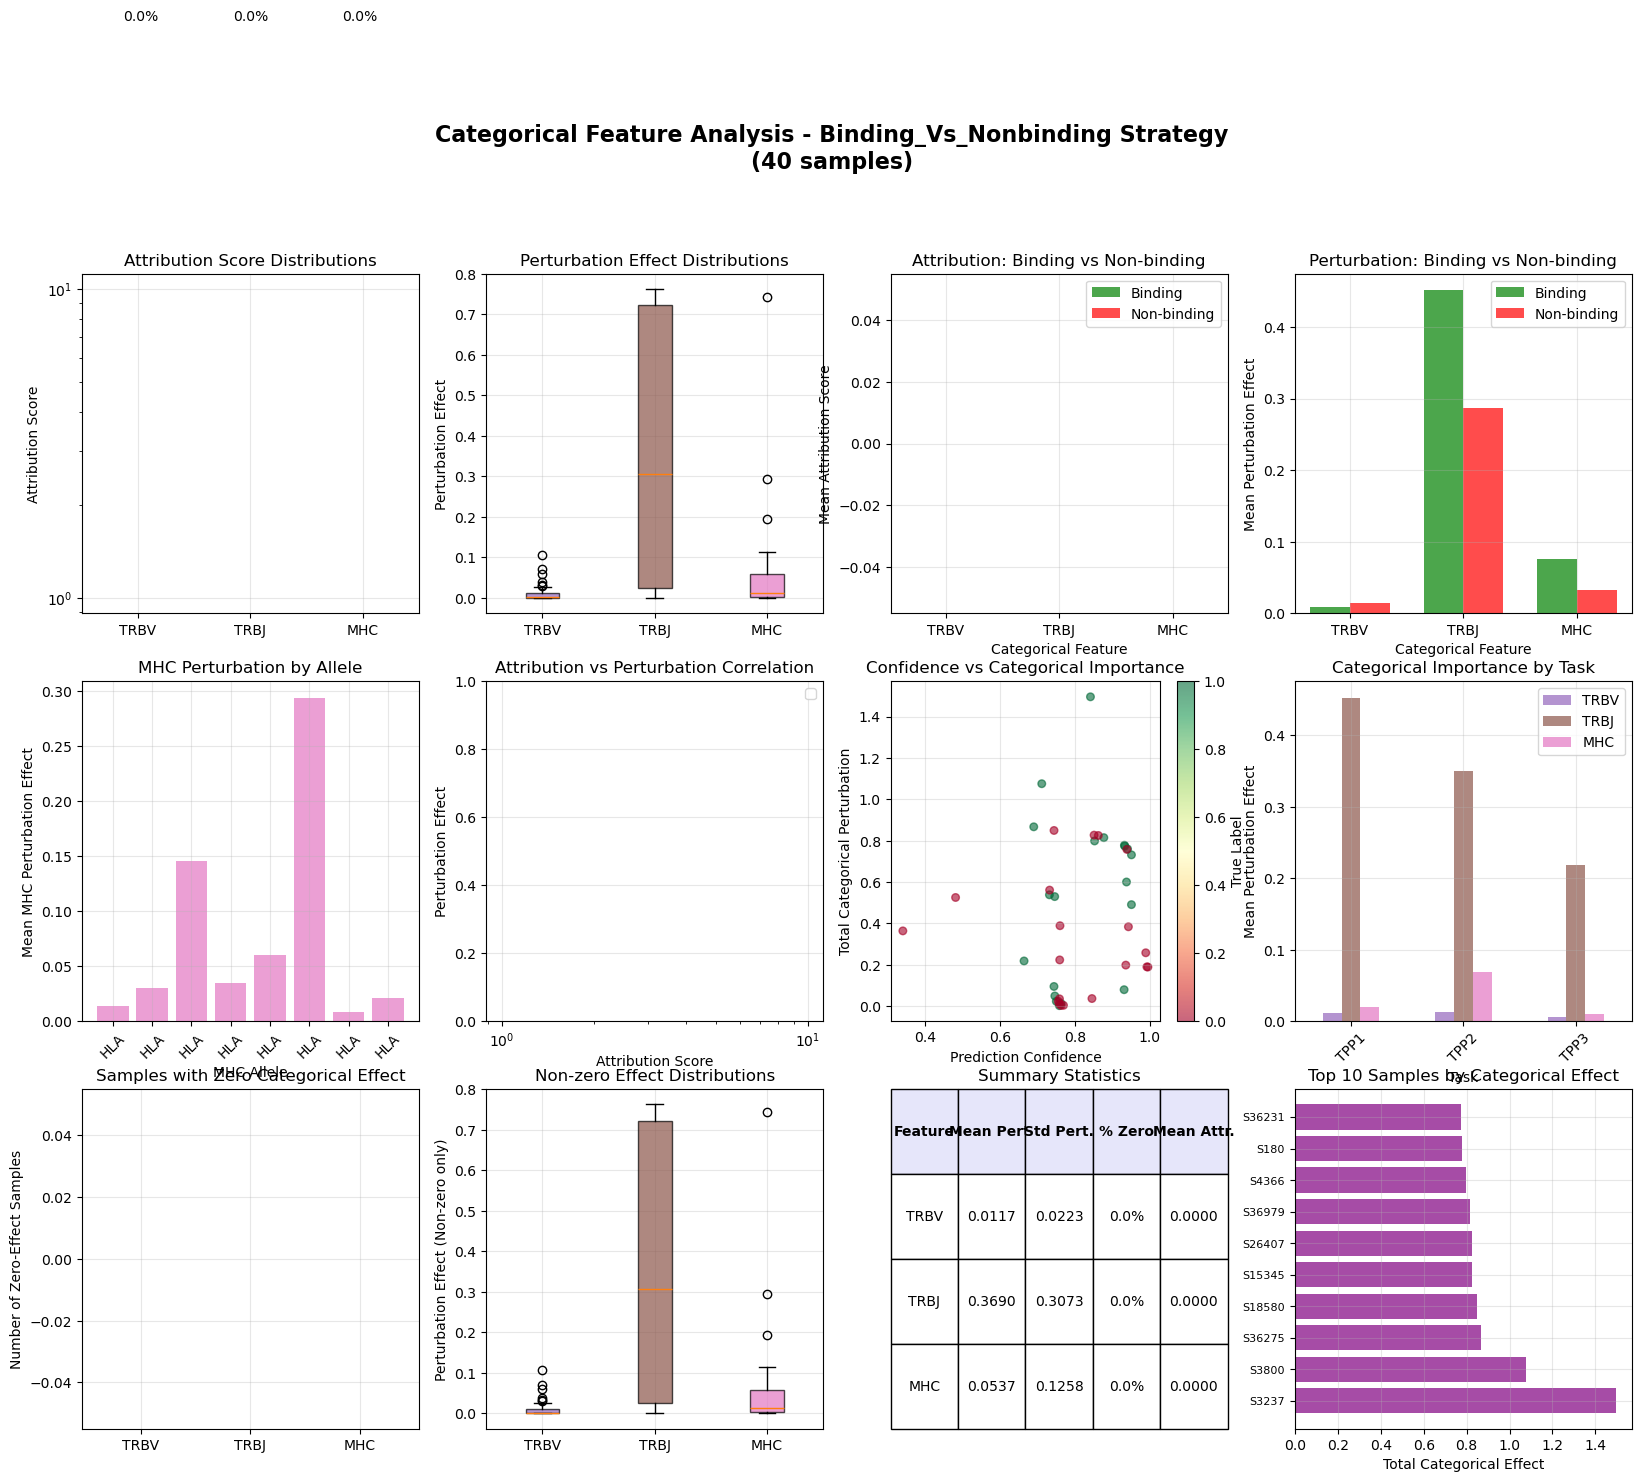

In [59]:
results_df = binding_comparison_analysis(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file
)

Analyzing 50 samples using 'mhc_variety' strategy...


Processing samples:   4%|▍         | 2/50 [00:00<00:02, 18.14it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-4*01 (idx: 118) -> Avg change: 0.0009
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.1277
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0006
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0019
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.6067
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0008
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-8*01 (idx: 95) -> Avg change: 0.0000
TRBJ: TRBJ1-6*01 (idx: 27) -> Avg change: 0.0101
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0005
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV10-1*01 (idx: 88) -> Av

Processing samples:   8%|▊         | 4/50 [00:00<00:02, 18.85it/s]

TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.0003
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0050


Processing samples:  12%|█▏        | 6/50 [00:00<00:02, 18.92it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV9 (idx: 20) -> Avg change: 0.0041
TRBJ: TRBJ2-1 (idx: 1) -> Avg change: 0.1982
MHC: HLA-A*02:01 (idx: 0) -> Avg change: 0.0167
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg change: 0.0004
TRBJ: TRBJ2-5*01 (idx: 16) -> Avg change: 0.0779
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0013
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV10-1*01 (idx: 88) -> Avg change: 0.0014
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.0732
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0083
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-8*02 (idx: 146) -> Avg change: 0.

Processing samples:  16%|█▌        | 8/50 [00:00<00:02, 19.01it/s]

TRBJ: TRBJ1-5*01 (idx: 22) -> Avg change: 0.0594
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0379


Processing samples:  22%|██▏       | 11/50 [00:00<00:02, 19.28it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV3-1*01 (idx: 113) -> Avg change: 0.0006
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.5424
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0030
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV4-3*01 (idx: 68) -> Avg change: 0.0005
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.0071
MHC: HLA-A*02 (idx: 10) -> Avg change: 0.0087
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9*01 (idx: 78) -> Avg change: 0.0118
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.5397
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0160
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV5-1*01 (idx: 70) -> Avg cha

Processing samples:  30%|███       | 15/50 [00:00<00:01, 19.56it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-6*01 (idx: 74) -> Avg change: 0.0229
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.6929
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0414
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV29-1*01 (idx: 52) -> Avg change: 0.0006
TRBJ: TRBJ2-3*01 (idx: 18) -> Avg change: 0.4022
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0511
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-9 (idx: 2) -> Avg change: 0.0032
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1777
MHC: HLA-A*11:01 (idx: 6) -> Avg change: 0.0893
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV9*01 (idx: 64) -> Avg change: 0

Processing samples:  40%|████      | 20/50 [00:01<00:01, 20.08it/s]


Analyzing categorical features using perturbation...
TRBV: TRBV15*01 (idx: 73) -> Avg change: 0.0064
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.7594
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0296
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV5-8*01 (idx: 96) -> Avg change: 0.0012
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.8773
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0097
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV9*01 (idx: 64) -> Avg change: 0.0016
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7604
MHC: HLA-A*03:01 (idx: 5) -> Avg change: 0.0022
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV5-6*01 (idx: 71) -> Avg change: 0.0006
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7635
MHC: HLA-A*03:01 

Processing samples:  46%|████▌     | 23/50 [00:01<00:01, 20.18it/s]

TRBV: TRBV19*01 (idx: 58) -> Avg change: 0.0011
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.0295
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.0286
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV19 (idx: 26) -> Avg change: 0.1512
TRBJ: TRBJ2-7 (idx: 0) -> Avg change: 0.0813
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.1011
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV13 (idx: 1) -> Avg change: 0.0949
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1143
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.2111
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV4-3*01 (idx: 68) -> Avg change: 0.0039
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.1024
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.0705
Using hybrid approach: gradients for c

Processing samples:  52%|█████▏    | 26/50 [00:01<00:01, 20.09it/s]

TRBJ: TRBJ2-1 (idx: 1) -> Avg change: 0.2376
MHC: HLA-B*07:02 (idx: 2) -> Avg change: 0.1040
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV4-3 (idx: 28) -> Avg change: 0.0000
TRBJ: TRBJ2-1 (idx: 1) -> Avg change: 0.2198
MHC: HLA-B*08:01 (idx: 1) -> Avg change: 0.0001
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-6*01 (idx: 74) -> Avg change: 0.0005
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.5918
MHC: HLA-B*08:01 (idx: 1) -> Avg change: 0.0002
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV27*01 (idx: 66) -> Avg change: 0.0026
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.6007
MHC: HLA-B*08:01 (idx: 1) -> Avg change: 0.0005
Using hybrid approach: gradients for continuous, perturbation for categorical

An

Processing samples:  64%|██████▍   | 32/50 [00:01<00:00, 20.38it/s]

MHC: HLA-B*08:01 (idx: 1) -> Avg change: 0.0008
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-3 (idx: 12) -> Avg change: 0.0003
TRBJ: TRBJ1-4 (idx: 7) -> Avg change: 0.2161
MHC: HLA-B*08:01 (idx: 1) -> Avg change: 0.0000
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV9*01 (idx: 64) -> Avg change: 0.0405
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.0720
MHC: HLA-A*01:01 (idx: 4) -> Avg change: 0.2707
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5 (idx: 7) -> Avg change: 0.0168
TRBJ: TRBJ2-1 (idx: 1) -> Avg change: 0.2244
MHC: HLA-A*01:01 (idx: 4) -> Avg change: 0.0460
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRB

Processing samples:  70%|███████   | 35/50 [00:01<00:00, 20.57it/s]

Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-5 (idx: 7) -> Avg change: 0.0180
TRBJ: TRBJ2-1 (idx: 1) -> Avg change: 0.2308
MHC: HLA-A*01:01 (idx: 4) -> Avg change: 0.0486
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV11-2 (idx: 35) -> Avg change: 0.0000
TRBJ: TRBJ1-1 (idx: 6) -> Avg change: 0.1816
MHC: HLA-A*01:01 (idx: 4) -> Avg change: 0.0001
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-1*01 (idx: 61) -> Avg change: 0.0006
TRBJ: TRBJ1-5*01 (idx: 22) -> Avg change: 0.1604
MHC: HLA-B*08 (idx: 39) -> Avg change: 0.0008
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-4*01 (idx: 118) -> Avg change: 0.0012

Processing samples:  82%|████████▏ | 41/50 [00:02<00:00, 20.48it/s]

TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.0832
MHC: HLA-B*08 (idx: 39) -> Avg change: 0.0500
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV20-1*01 (idx: 56) -> Avg change: 0.0113
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.2609
MHC: HLA-B*08 (idx: 39) -> Avg change: 0.0111
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV3-1*01 (idx: 113) -> Avg change: 0.0013
TRBJ: TRBJ1-1*01 (idx: 21) -> Avg change: 0.2522
MHC: HLA-B*08 (idx: 39) -> Avg change: 0.0009
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV6-1 (idx: 6) -> Avg change: 0.0010
TRBJ: TRBJ1-6 (idx: 8) -> Avg change: 0.1925
MHC: HLA-A*24:02 (idx: 3) -> Avg change: 0.0015
Using hybrid approach: gradients for continuous, perturbation for categorical

An

Processing samples:  88%|████████▊ | 44/50 [00:02<00:00, 20.27it/s]

TRBJ: TRBJ2-5 (idx: 2) -> Avg change: 0.2739
MHC: HLA-A*24:02 (idx: 3) -> Avg change: 0.0001
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV14 (idx: 11) -> Avg change: 0.0000
TRBJ: TRBJ2-1 (idx: 1) -> Avg change: 0.1933
MHC: HLA-A*24:02 (idx: 3) -> Avg change: 0.0000
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV5-4*01 (idx: 82) -> Avg change: 0.0044
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.7604
MHC: HLA-A*24:02 (idx: 3) -> Avg change: 0.0108
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV15*01 (idx: 73) -> Avg change: 0.0002


Processing samples:  94%|█████████▍| 47/50 [00:02<00:00, 16.90it/s]

TRBJ: TRBJ1-3*01 (idx: 25) -> Avg change: 0.0075
MHC: HLA-A*24:02 (idx: 3) -> Avg change: 0.0009
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-8*01 (idx: 95) -> Avg change: 0.0213
TRBJ: TRBJ2-2*01 (idx: 14) -> Avg change: 0.1968
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.0735
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV28*01 (idx: 62) -> Avg change: 0.1124
TRBJ: TRBJ2-7*01 (idx: 19) -> Avg change: 0.4305
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.1704
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV7-2*01 (idx: 115) -> Avg change: 0.0311
TRBJ: TRBJ2-5*01 (idx: 16) -> Avg change: 0.2248
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.1032
Using hybrid approach: gradients for continuous, perturbation for categoric

Processing samples: 100%|██████████| 50/50 [00:02<00:00, 19.22it/s]



Analyzing categorical features using perturbation...
TRBV: TRBV12-3*01 (idx: 104) -> Avg change: 0.0507
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.5262
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.2383
Using hybrid approach: gradients for continuous, perturbation for categorical

Analyzing categorical features using perturbation...
TRBV: TRBV12-4*01 (idx: 118) -> Avg change: 0.0280
TRBJ: TRBJ2-1*01 (idx: 15) -> Avg change: 0.4456
MHC: HLA-B*27 (idx: 36) -> Avg change: 0.1455


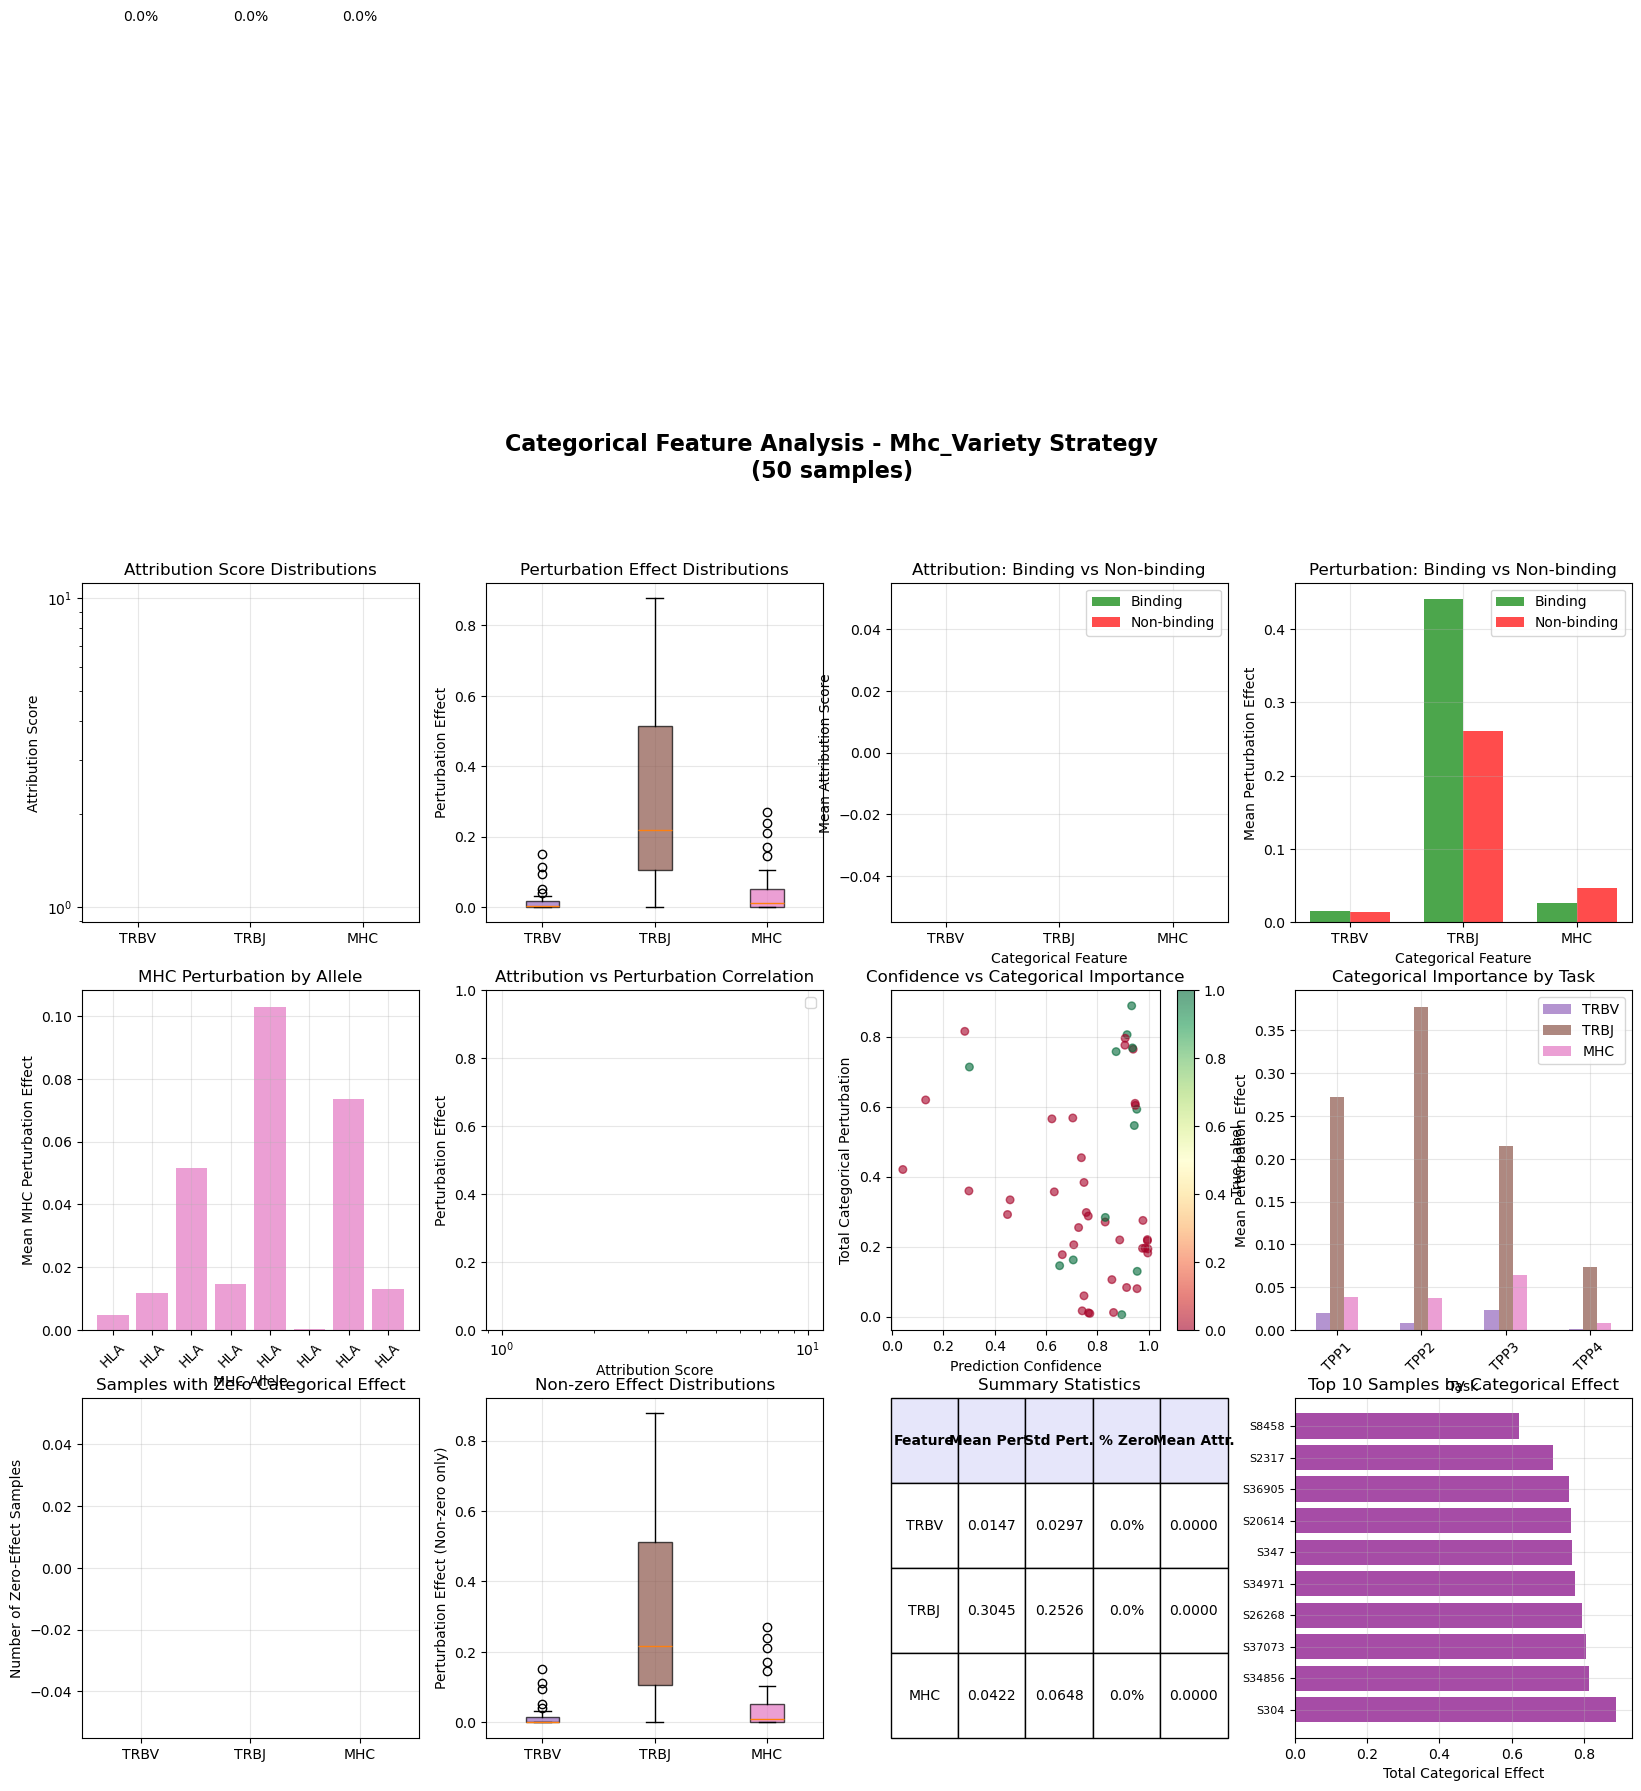

In [60]:
results_df = mhc_focused_analysis(
    model, test_data, tcr_test_embeddings, epitope_test_embeddings, physchem_file
)